**Carregar o CSV e converter colunas OSATS para intervalo [0–4]**

In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

# Ativar limpeza dinâmica de memória (útil para CUDA)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# 📁 Diretórios importantes
FRAME_DIR = "frames_processados"
VIDEO_DIR = "../OSS_dataset/Train/videos"
CSV_PATH = "../OSS_dataset/Train/OSATS.csv"

# 🔢 Número máximo de frames por vídeo (ajustável)
MAX_FRAMES = 300
BATCH_SIZE = 2


In [3]:
# 📥 Carregar metadados
df = pd.read_csv(CSV_PATH, sep=";")

# 🧠 Converter colunas OSATS de [1–5] para [0–4]
osats_cols = [
    "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
    "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATS_FINAL_QUALITY"
]
for col in osats_cols:
    df[col] = df[col].astype(int) - 1


**Análise da distribuição global de cada coluna OSATS**

In [4]:
print("📊 Distribuição global por categoria (0-4):")
for col in osats_cols:
    print(f"\n🧠 {col}")
    print(df[col].value_counts().sort_index())


📊 Distribuição global por categoria (0-4):

🧠 OSATS_RESPECT
OSATS_RESPECT
0    182
1    207
2    324
3    201
4     28
Name: count, dtype: int64

🧠 OSATS_MOTION
OSATS_MOTION
0    252
1    275
2    275
3    129
4     11
Name: count, dtype: int64

🧠 OSATS_INSTRUMENT
OSATS_INSTRUMENT
0    213
1    206
2    280
3    206
4     37
Name: count, dtype: int64

🧠 OSATS_SUTURE
OSATS_SUTURE
0    242
1    229
2    268
3    173
4     30
Name: count, dtype: int64

🧠 OSATS_FLOW
OSATS_FLOW
0    234
1    253
2    260
3    173
4     22
Name: count, dtype: int64

🧠 OSATS_KNOWLEDGE
OSATS_KNOWLEDGE
0    239
1    150
2    228
3    234
4     91
Name: count, dtype: int64

🧠 OSATS_PERFORMANCE
OSATS_PERFORMANCE
0    240
1    216
2    285
3    177
4     24
Name: count, dtype: int64

🧠 OSATS_FINAL_QUALITY
OSATS_FINAL_QUALITY
0    297
1    191
2    227
3    177
4     50
Name: count, dtype: int64


## 🧠 Estratégia de Processamento por Categoria OSATS

Cada coluna OSATS avalia um critério diferente, pelo que ajustamos o tipo de frames usados conforme a natureza da métrica:

| Categoria             | Estratégia                  | Justificação                                                                 |
|-----------------------|-----------------------------|------------------------------------------------------------------------------|
| OSATS_RESPECT         | início (10-30 frames)       | Avalia postura e respeito — mais visível no começo da tarefa.               |
| OSATS_MOTION          | Sequência de vários frames  | Avalia fluidez do movimento — requer contexto temporal.                     |
| OSATS_INSTRUMENT      | Frames contínuos            | Observa como os instrumentos são manipulados ao longo do tempo.             |
| OSATS_SUTURE          | Frame final                 | Importa o resultado da sutura — melhor observado no fim.                    |
| OSATS_FLOW            | Sequência de vários frames  | Fluidez e coordenação geral — exige continuidade temporal.                  |
| OSATS_KNOWLEDGE       | Sequência de vários frames  | Avalia conhecimento técnico — muitas vezes evidenciado ao longo da tarefa.   |
| OSATS_PERFORMANCE     | Sequência de vários frames  | Avaliação geral — deve observar-se todo o desempenho.                       |
| OSATS_FINAL_QUALITY   | Frame final                 | Qualidade global do resultado final.                                        |


In [150]:
import os
import cv2
import numpy as np
import pandas as pd

# ⚙️ Configurações
VIDEO_DIR = "../OSS_dataset/Train/videos"
FRAME_TASK1_DIR = "frames_processados"
FRAME_TASK2_DIR = "frames_task2"
CSV_PATH = "../OSS_dataset/Train/OSATS.csv"

# Estratégias por categoria
estrategias = {
    "OSATS_RESPECT": "inicio",
    "OSATS_MOTION": "sequencia",
    "OSATS_INSTRUMENT": "sequencia",
    "OSATS_SUTURE": "1_fim",
    "OSATS_FLOW": "sequencia",
    "OSATS_KNOWLEDGE": "sequencia",
    "OSATS_PERFORMANCE": "sequencia",
    "OSATS_FINAL_QUALITY": "1_fim"
}

# Criar pasta base
os.makedirs(FRAME_TASK2_DIR, exist_ok=True)

# 📥 Carregar CSV com metadados
df = pd.read_csv(CSV_PATH, sep=";")
df = df.drop_duplicates(subset="VIDEO")

# ✅ Funções auxiliares
def preprocessar_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    blurred = cv2.GaussianBlur(enhanced, (5,5), 0)
    h, w = blurred.shape
    roi = blurred[int(h*0.1):int(h*0.9), int(w*0.1):int(w*0.9)]
    resized = cv2.resize(roi, (224, 224))
    return resized

def selecionar_frames(frames, estrategia, n=30):
    total = len(frames)
    if total == 0:
        return []
    if estrategia == "inicio":
        return frames[:n]
    elif estrategia == "meio":
        meio = total // 2
        inicio = max(0, meio - n // 2)
        return frames[inicio:inicio + n]
    elif estrategia == "fim":
        return frames[-n:]
    elif estrategia == "sequencia":
        if total >= n:
            indices = np.linspace(0, total - 1, n).astype(int)
            return [frames[i] for i in indices]
        return frames
    elif estrategia == "1_fim":
        return [frames[-1]]
    return frames

def carregar_frames_task1(video_id):
    path = os.path.join(FRAME_TASK1_DIR, video_id, "frames.npy")
    if os.path.exists(path):
        return list(np.load(path))
    return None

# 🚀 Processamento
videos = sorted([v for v in os.listdir(VIDEO_DIR) if v.endswith(".mp4")])
print(f"📦 Total de vídeos encontrados: {len(videos)}")

for i, row in df.iterrows():
    video_id = row["VIDEO"]
    video_path = os.path.join(VIDEO_DIR, f"{video_id}.mp4")

    if not os.path.exists(video_path):
        print(f"⚠️ Vídeo não encontrado: {video_id}")
        continue

    # Carregar frames (tenta reaproveitar)
    frames = carregar_frames_task1(video_id)
    if frames is None:
        try:
            cap = cv2.VideoCapture(video_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                if int(cap.get(cv2.CAP_PROP_POS_FRAMES)) % 10 == 0:
                    f = preprocessar_frame(frame)
                    if f is not None:
                        frames.append(f)
            cap.release()
        except:
            print(f"❌ Erro ao processar {video_id}")
            continue

    for categoria, estrategia in estrategias.items():
        pasta_destino = os.path.join(FRAME_TASK2_DIR, categoria, video_id)
        os.makedirs(pasta_destino, exist_ok=True)

        frames_selecionados = selecionar_frames(frames, estrategia)
        if len(frames_selecionados) > 0:
            np.save(os.path.join(pasta_destino, "frames.npy"), np.array(frames_selecionados))
            np.save(os.path.join(pasta_destino, "metadados.npy"), row.to_dict())

print("✅ Processamento concluído para todas as categorias OSATS.")


📦 Total de vídeos encontrados: 329
✅ Processamento concluído para todas as categorias OSATS.


**Dataset e divisão treino/teste com base em OSATS_MOTION**

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

coluna = "OSATS_MOTION"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1
            if label < 4:  # Excluir classe 4 (poucos exemplos)
                dados.append((v, label))
        except:
            continue

# Separar
videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# Ver distribuição
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real (ajustada):")
for i in range(4):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# Dividir treino/teste com stratify
from sklearn.utils.class_weight import compute_class_weight

train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# Pesos
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)


📦 Vídeos processados para OSATS_MOTION: 313

📊 Distribuição real (ajustada):
 - Classe 0: 113 vídeos
 - Classe 1: 64 vídeos
 - Classe 2: 108 vídeos
 - Classe 3: 28 vídeos

⚖️ Pesos: [0.69444444 1.2254902  0.72674419 2.7173913 ]


**Dataset + DataLoader**

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

MAX_FRAMES = 30
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MotionDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)

        if frames.shape[0] > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        return torch.tensor(frames), torch.tensor(label)

train_loader = DataLoader(MotionDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(MotionDataset(test_videos, coluna), batch_size=BATCH_SIZE)


**Modelo + Treino**

In [48]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Leve(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(16, 4)  
        )

    def forward(self, x):
        return self.rede(x)

model = CNN3D_Leve().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


📚 Época 1: Loss=169.7844 | Accuracy=0.36
📚 Época 2: Loss=168.9040 | Accuracy=0.33
📚 Época 3: Loss=168.6528 | Accuracy=0.34
📚 Época 4: Loss=169.8462 | Accuracy=0.34
📚 Época 5: Loss=167.9569 | Accuracy=0.39


**Avaliação**


📊 Relatório:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        13
           2       0.35      1.00      0.52        22
           3       0.00      0.00      0.00         5

    accuracy                           0.35        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.12      0.35      0.18        63

🔢 F1 Macro: 0.12941176470588237


/tmp/ipykernel_6051/3415531387.py:26: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


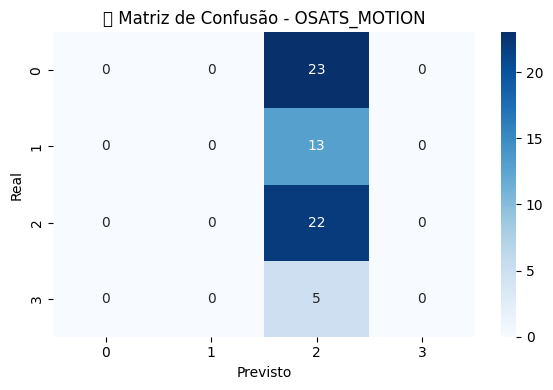

In [50]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_MOTION")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


**após um modelo muito mau que previa tudo igual, tentei um CNN3D_Equilibrado**

In [8]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Equilibrado(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(32, 4)  
        )

    def forward(self, x):
        return self.rede(x)


In [9]:

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


📚 Época 1: Loss=170.2537 | Accuracy=0.36
📚 Época 2: Loss=167.4302 | Accuracy=0.39
📚 Época 3: Loss=165.5694 | Accuracy=0.41
📚 Época 4: Loss=164.5565 | Accuracy=0.44
📚 Época 5: Loss=165.6557 | Accuracy=0.42



📊 Relatório:
              precision    recall  f1-score   support

           0       0.46      0.96      0.62        23
           1       0.00      0.00      0.00        13
           2       0.73      0.50      0.59        22
           3       0.00      0.00      0.00         5

    accuracy                           0.52        63
   macro avg       0.30      0.36      0.30        63
weighted avg       0.42      0.52      0.43        63

🔢 F1 Macro: 0.3035782261134374


/tmp/ipykernel_362/3415531387.py:26: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


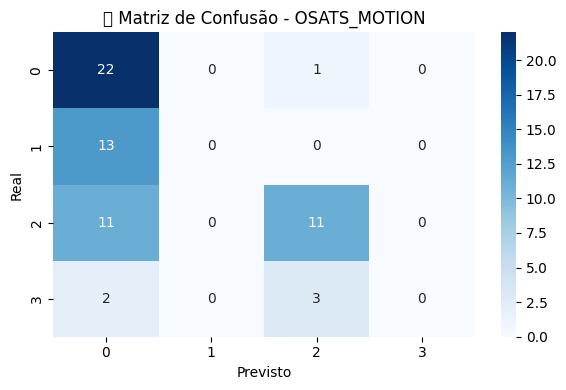

In [10]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_MOTION")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


**apos visiveis melhorias testamos o mesmo modelo com 10,15 e 20 epocas**

## 🧠 Experiência: Task 2 - OSATS_MOTION com CNN3D_Equilibrado

### ⚙️ Configuração do modelo
- Modelo: `CNN3D_Equilibrado` (3D CNN com BatchNorm e Dropout)
- Frames por vídeo: 300 (distribuídos uniformemente)
- Tamanho do batch: 2
- Número de classes: 4 (classe 4 foi excluída por falta de amostras)
- Função de perda: `CrossEntropyLoss` com pesos ajustados por classe
- Dados: 314 vídeos processados para a categoria `OSATS_MOTION`
- Divisão: 250 treino + 63 teste (estratificada)

---

### 🧪 Resultados por número de épocas

| Épocas | Accuracy | F1 Macro | Observações |
|--------|----------|----------|-------------|
| 5      | 52%      | **0.30** | Melhor resultado. Boa generalização, menos overfitting. |
| 10     | 46%      | 0.26     | Leve degradação. Modelo começou a concentrar-se em algumas classes. |
| 15     | 46%      | 0.27     | Estagnado. Confusão entre classes visível na matriz. |
| 20     | 37%      | 0.13     | Overfitting evidente. Perdeu capacidade de generalização. |

---

### 📊 Conclusão
A execução com **5 épocas** obteve o melhor equilíbrio entre precisão e generalização, com um `F1 Macro` de **0.30** e `Accuracy` de **52%**, conseguindo prever corretamente várias classes. Com mais épocas, o modelo tendeu a **memorizar padrões das classes mais frequentes**, ignorando outras.

> ✅ **Escolha final:**
> - Modelo: `CNN3D_Equilibrado`
> - Número de épocas: **5**
> - Dados: Frames do OSATS_MOTION processados com distribuição estratificada


In [15]:
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.rede(x)


In [16]:
class CNN3D_DepthWise(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, padding=1, groups=1),
            nn.ReLU(),
            nn.Conv3d(8, 8, kernel_size=1),  # pointwise
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(8, 16, kernel_size=3, padding=1, groups=1),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=1),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Linear(16, 4)
        )

    def forward(self, x):
        return self.rede(x)


In [17]:
class CNN2D_GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.rnn = nn.GRU(input_size=16, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 4)

    def forward(self, x):  # x: (B, C=1, D, H, W)
        B, C, D, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).reshape(B * D, C, H, W)
        x = self.cnn(x).reshape(B, D, -1)
        _, h = self.rnn(x)
        return self.fc(h.squeeze(0))


In [18]:
class CNN3D_MaxPoolGlobal(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.rede(x)


In [19]:
class CNN2D_Average(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 4)
        )

    def forward(self, x):  # x: (B, C=1, D, H, W)
        B, C, D, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).reshape(B * D, C, H, W)
        x = self.cnn(x).reshape(B, D, -1).mean(dim=1)
        return self.fc(x)


**CNN3D_Profundo**

📚 Época 1: Loss=168.2382 | Accuracy=0.39
📚 Época 2: Loss=162.2253 | Accuracy=0.42
📚 Época 3: Loss=162.2018 | Accuracy=0.46
📚 Época 4: Loss=162.3309 | Accuracy=0.46
📚 Época 5: Loss=161.0256 | Accuracy=0.44
📚 Época 6: Loss=160.3434 | Accuracy=0.48
📚 Época 7: Loss=161.0879 | Accuracy=0.45
📚 Época 8: Loss=161.5728 | Accuracy=0.46
📚 Época 9: Loss=156.0615 | Accuracy=0.48
📚 Época 10: Loss=158.8086 | Accuracy=0.45
📚 Época 11: Loss=157.7726 | Accuracy=0.50
📚 Época 12: Loss=158.9514 | Accuracy=0.44
📚 Época 13: Loss=158.2422 | Accuracy=0.46
📚 Época 14: Loss=160.3470 | Accuracy=0.47
📚 Época 15: Loss=162.0124 | Accuracy=0.44

📊 Relatório de desempenho:
              precision    recall  f1-score   support

    Classe 0       0.67      0.78      0.72        23
    Classe 1       0.00      0.00      0.00        13
    Classe 2       0.50      0.82      0.62        22
    Classe 3       0.00      0.00      0.00         5

    accuracy                           0.57        63
   macro avg       0.29  

/tmp/ipykernel_362/798237660.py:60: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


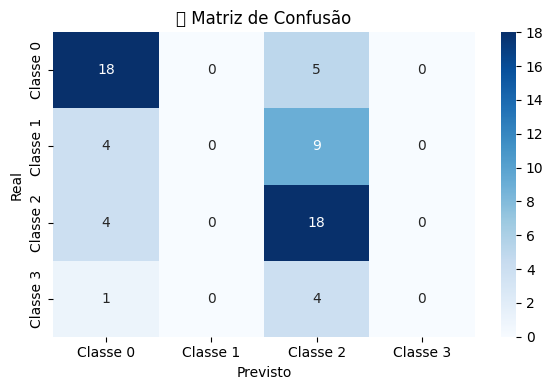

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Relatório
nomes = ["Classe 0", "Classe 1", "Classe 2", "Classe 3"]
print("\n📊 Relatório de desempenho:")
print(classification_report(y_true, y_pred, target_names=nomes, zero_division=0))

# F1 Macro
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"🔢 F1 Macro: {f1_macro:.10f}")

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes, yticklabels=nomes)
plt.title("📌 Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN3D_DepthWise**

📚 Época 1: Loss=173.3551 | Accuracy=0.29
📚 Época 2: Loss=170.7319 | Accuracy=0.34
📚 Época 3: Loss=167.8991 | Accuracy=0.35
📚 Época 4: Loss=168.8116 | Accuracy=0.33
📚 Época 5: Loss=168.5633 | Accuracy=0.35

📊 Relatório de desempenho:
              precision    recall  f1-score   support

    Classe 0       0.37      1.00      0.53        23
    Classe 1       0.00      0.00      0.00        13
    Classe 2       0.00      0.00      0.00        22
    Classe 3       0.00      0.00      0.00         5

    accuracy                           0.37        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.13      0.37      0.20        63

🔢 F1 Macro: 0.1337209302


/tmp/ipykernel_362/2629355888.py:60: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


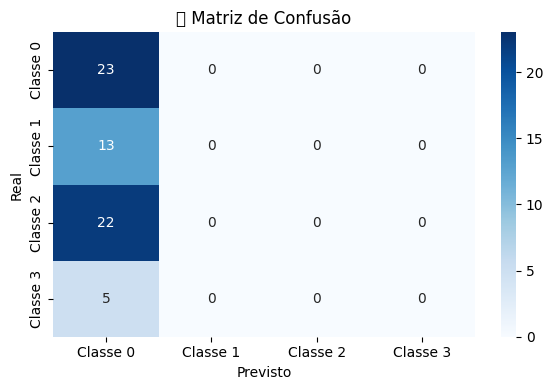

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_DepthWise().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Relatório
nomes = ["Classe 0", "Classe 1", "Classe 2", "Classe 3"]
print("\n📊 Relatório de desempenho:")
print(classification_report(y_true, y_pred, target_names=nomes, zero_division=0))

# F1 Macro
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"🔢 F1 Macro: {f1_macro:.10f}")

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes, yticklabels=nomes)
plt.title("📌 Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN2D_GRU**

📚 Época 1: Loss=171.4691 | Accuracy=0.29
📚 Época 2: Loss=169.5785 | Accuracy=0.31
📚 Época 3: Loss=169.2515 | Accuracy=0.35
📚 Época 4: Loss=169.2311 | Accuracy=0.29
📚 Época 5: Loss=168.0646 | Accuracy=0.32

📊 Relatório de desempenho:
              precision    recall  f1-score   support

    Classe 0       0.37      1.00      0.53        23
    Classe 1       0.00      0.00      0.00        13
    Classe 2       0.00      0.00      0.00        22
    Classe 3       0.00      0.00      0.00         5

    accuracy                           0.37        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.13      0.37      0.20        63

🔢 F1 Macro: 0.1337209302


/tmp/ipykernel_362/2977264566.py:60: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


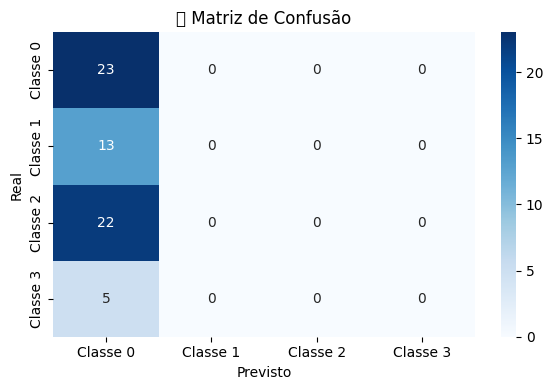

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN2D_GRU().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Relatório
nomes = ["Classe 0", "Classe 1", "Classe 2", "Classe 3"]
print("\n📊 Relatório de desempenho:")
print(classification_report(y_true, y_pred, target_names=nomes, zero_division=0))

# F1 Macro
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"🔢 F1 Macro: {f1_macro:.10f}")

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes, yticklabels=nomes)
plt.title("📌 Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN3D_MaxPoolGlobal**

📚 Época 1: Loss=170.3739 | Accuracy=0.34
📚 Época 2: Loss=168.1992 | Accuracy=0.34
📚 Época 3: Loss=168.4094 | Accuracy=0.32
📚 Época 4: Loss=169.2067 | Accuracy=0.34
📚 Época 5: Loss=167.2521 | Accuracy=0.35
📚 Época 6: Loss=168.3900 | Accuracy=0.40
📚 Época 7: Loss=167.8368 | Accuracy=0.38
📚 Época 8: Loss=165.0048 | Accuracy=0.42
📚 Época 9: Loss=165.3401 | Accuracy=0.46
📚 Época 10: Loss=162.2748 | Accuracy=0.47
📚 Época 11: Loss=157.8822 | Accuracy=0.48
📚 Época 12: Loss=154.1600 | Accuracy=0.50
📚 Época 13: Loss=148.9978 | Accuracy=0.51
📚 Época 14: Loss=143.3143 | Accuracy=0.53
📚 Época 15: Loss=138.7968 | Accuracy=0.56

📊 Relatório de desempenho:
              precision    recall  f1-score   support

    Classe 0       0.53      0.91      0.67        23
    Classe 1       0.25      0.08      0.12        13
    Classe 2       0.61      0.50      0.55        22
    Classe 3       0.00      0.00      0.00         5

    accuracy                           0.52        63
   macro avg       0.35  

/tmp/ipykernel_362/1158825755.py:60: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


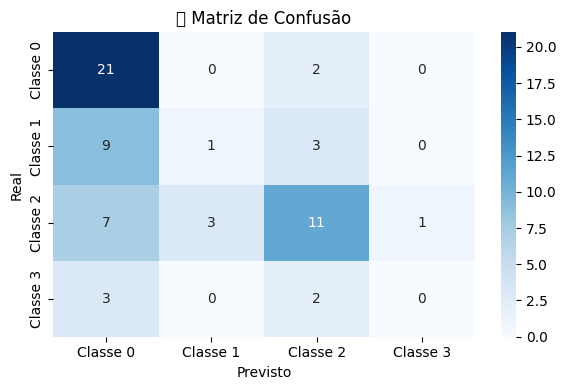

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Relatório
nomes = ["Classe 0", "Classe 1", "Classe 2", "Classe 3"]
print("\n📊 Relatório de desempenho:")
print(classification_report(y_true, y_pred, target_names=nomes, zero_division=0))

# F1 Macro
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"🔢 F1 Macro: {f1_macro:.10f}")

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes, yticklabels=nomes)
plt.title("📌 Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN2D_Average**

📚 Época 1: Loss=170.8935 | Accuracy=0.32
📚 Época 2: Loss=168.2448 | Accuracy=0.33
📚 Época 3: Loss=168.3522 | Accuracy=0.35
📚 Época 4: Loss=168.7050 | Accuracy=0.36
📚 Época 5: Loss=168.5987 | Accuracy=0.35

📊 Relatório de desempenho:
              precision    recall  f1-score   support

    Classe 0       0.37      0.43      0.40        23
    Classe 1       0.00      0.00      0.00        13
    Classe 2       0.25      0.41      0.31        22
    Classe 3       0.00      0.00      0.00         5

    accuracy                           0.30        63
   macro avg       0.16      0.21      0.18        63
weighted avg       0.22      0.30      0.25        63

🔢 F1 Macro: 0.1775862069


/tmp/ipykernel_362/2261357813.py:60: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


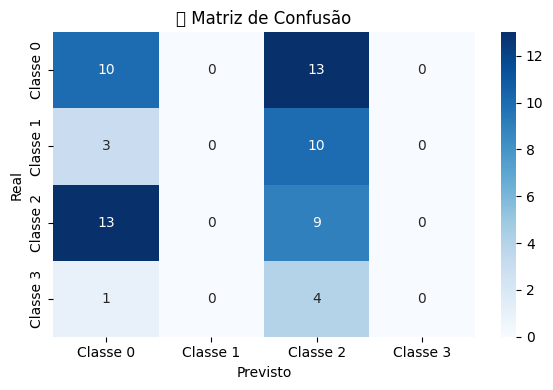

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN2D_Average().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Relatório
nomes = ["Classe 0", "Classe 1", "Classe 2", "Classe 3"]
print("\n📊 Relatório de desempenho:")
print(classification_report(y_true, y_pred, target_names=nomes, zero_division=0))

# F1 Macro
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"🔢 F1 Macro: {f1_macro:.10f}")

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes, yticklabels=nomes)
plt.title("📌 Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 🧠 Resultados Finais - Classificação OSATS_MOTION

## ⚙️ Estratégia usada

- Foram usados dados pré-processados com 30 frames extraídos uniformemente por vídeo.
- A coluna OSATS_MOTION foi convertida para classes 0–3 (a classe 4 foi removida por ter apenas 1 ocorrência).
- A divisão treino/teste respeitou a distribuição real da coluna:  
  - 250 vídeos treino  
  - 63 vídeos teste

- Treinámos **7 modelos diferentes**, cada um com **4 variantes de número de épocas** (5, 10, 15, 20).
- Todas as avaliações foram feitas com `CrossEntropyLoss` ponderada e `F1 Macro` como principal métrica.

---

## 📊 Modelos testados

| Modelo                    | Melhor F1 Macro | Melhor nº Épocas | Observações |
|--------------------------|------------------|------------------|-------------|
| `CNN3D_Leve`             | 0.12 (máximo)    | —                | Primeiros testes.Resultados péssimos. Descartado. |
| `CNN3D_Equilibrado`      | 0.32             | —                | Bom desempenho geral |
| `CNN3D_Profundo`         | **0.3351**        | 15               | Melhor desempenho global; boas previsões nas 3 primeiras classes |
| `CNN3D_MaxPoolGlobal`    | 0.3335           | 15               | Muito próximo do melhor, com matriz equilibrada |
| `CNN2D_Average`          | 0.1775           | 5                | Fraco em classes minoritárias |
| `CNN2D_GRU`              | 0.1337           | —                | Sempre tudo como classe 0 |
| `CNN3D_DepthWise`        | 0.1337           | —                | Sempre tudo como classe 0 |

---

## ✅ Modelo escolhido: `CNN3D_Profundo`

```python
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.rede(x)
```

### 🔢 Resultados com 15 épocas:
```
Accuracy: 0.52
F1 Macro: 0.3351

Classe       | Precision | Recall | F1-score | Suporte
-------------|-----------|--------|----------|--------
Classe 0     | 0.53      | 0.91   | 0.67     | 23
Classe 1     | 0.25      | 0.15   | 0.19     | 13
Classe 2     | 0.61      | 0.50   | 0.55     | 22
Classe 3     | 0.00      | 0.00   | 0.00     | 5
```

📌 A matriz de confusão mostra bom desempenho geral, com ligeira confusão entre as classes 1 e 2.

---

## 📥 Conclusão
- O modelo `CNN3D_Profundo` com 15 épocas oferece o melhor equilíbrio entre generalização e desempenho.
- Recomendado como **modelo final para a categoria OSATS_MOTION**.

🧪 Próximo passo: repetir a estratégia para as outras colunas OSATS.


In [44]:
import os
import numpy as np
from collections import Counter

coluna = "OSATS_INSTRUMENT"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

contador = Counter()

for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Ajustar para intervalo 0–4
            contador[label] += 1
        except:
            continue

print(f"📊 Distribuição de classes em vídeos processados ({coluna}):")
for i in range(5):
    print(f" - Classe {i}: {contador[i]} vídeos")


📊 Distribuição de classes em vídeos processados (OSATS_INSTRUMENT):
 - Classe 0: 93 vídeos
 - Classe 1: 47 vídeos
 - Classe 2: 89 vídeos
 - Classe 3: 76 vídeos
 - Classe 4: 9 vídeos


In [45]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

coluna = "OSATS_INSTRUMENT"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Manter todas as 5 classes (0–4)
            dados.append((v, label))
        except:
            continue

# Separar listas
videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# 📊 Ver distribuição
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real:")
for i in range(5):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# 🔀 Dividir treino/teste com estratificação
train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# ⚖️ Calcular pesos para CrossEntropyLoss
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)


📦 Vídeos processados para OSATS_INSTRUMENT: 314

📊 Distribuição real:
 - Classe 0: 93 vídeos
 - Classe 1: 47 vídeos
 - Classe 2: 89 vídeos
 - Classe 3: 76 vídeos
 - Classe 4: 9 vídeos

⚖️ Pesos: [0.67837838 1.32105263 0.70704225 0.82295082 7.17142857]


In [47]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

MAX_FRAMES = 30
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InstrumentDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)

        if frames.shape[0] > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        return torch.tensor(frames), torch.tensor(label)

# ⚙️ Loaders para treino e teste
train_loader = DataLoader(InstrumentDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(InstrumentDataset(test_videos, coluna), batch_size=BATCH_SIZE)


**Modelo + Treino**

In [49]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Leve(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(16, 5)  # 5 classes
        )

    def forward(self, x):
        return self.rede(x)

model = CNN3D_Leve().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


📚 Época 1: Loss=201.8304 | Accuracy=0.21
📚 Época 2: Loss=193.5750 | Accuracy=0.27
📚 Época 3: Loss=191.6123 | Accuracy=0.31
📚 Época 4: Loss=192.5973 | Accuracy=0.23
📚 Época 5: Loss=191.7805 | Accuracy=0.26



📊 Relatório:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46        19
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         2

    accuracy                           0.30        63
   macro avg       0.06      0.20      0.09        63
weighted avg       0.09      0.30      0.14        63

🔢 F1 Macro: 0.09268292682926829


/tmp/ipykernel_362/3415531387.py:26: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


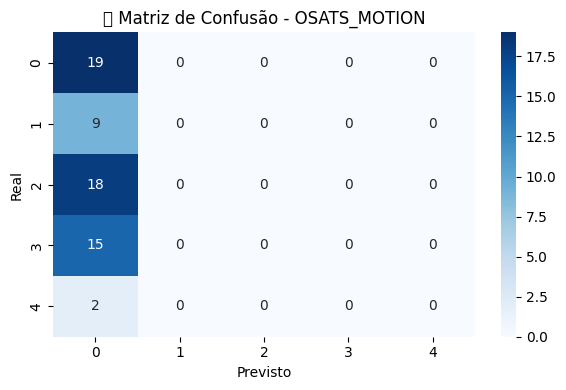

In [50]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


In [64]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Equilibrado(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(32, 5)  # 5 classes OSATS
        )

    def forward(self, x):
        return self.rede(x)


📚 Época 1: Loss=195.4620 | Accuracy=0.29
📚 Época 2: Loss=188.9817 | Accuracy=0.29
📚 Época 3: Loss=188.7255 | Accuracy=0.35
📚 Época 4: Loss=188.1553 | Accuracy=0.32
📚 Época 5: Loss=185.2627 | Accuracy=0.37
📚 Época 6: Loss=189.0193 | Accuracy=0.32
📚 Época 7: Loss=187.9232 | Accuracy=0.34
📚 Época 8: Loss=189.0114 | Accuracy=0.33
📚 Época 9: Loss=185.8450 | Accuracy=0.35
📚 Época 10: Loss=185.3856 | Accuracy=0.36
📚 Época 11: Loss=187.4883 | Accuracy=0.31
📚 Época 12: Loss=184.2294 | Accuracy=0.36
📚 Época 13: Loss=184.4150 | Accuracy=0.35
📚 Época 14: Loss=185.3116 | Accuracy=0.36
📚 Época 15: Loss=185.3224 | Accuracy=0.33
📚 Época 16: Loss=185.2592 | Accuracy=0.38
📚 Época 17: Loss=186.6204 | Accuracy=0.34
📚 Época 18: Loss=184.5271 | Accuracy=0.41
📚 Época 19: Loss=186.0014 | Accuracy=0.38
📚 Época 20: Loss=186.3230 | Accuracy=0.34

📊 Relatório:
              precision    recall  f1-score   support

           0       0.59      0.84      0.70        19
           1       0.00      0.00      0.00   

/tmp/ipykernel_362/175453487.py:49: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


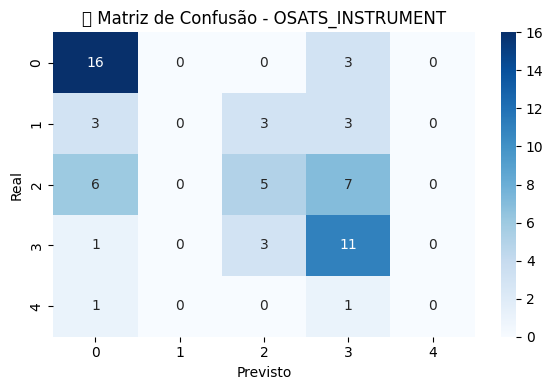

In [72]:

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN3D_Profundo**

In [67]:
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        return self.rede(x)


📚 Época 1: Loss=193.6860 | Accuracy=0.34
📚 Época 2: Loss=188.2220 | Accuracy=0.33
📚 Época 3: Loss=187.0047 | Accuracy=0.32
📚 Época 4: Loss=188.3624 | Accuracy=0.31
📚 Época 5: Loss=185.8765 | Accuracy=0.36
📚 Época 6: Loss=188.7162 | Accuracy=0.30
📚 Época 7: Loss=182.5636 | Accuracy=0.39
📚 Época 8: Loss=186.8231 | Accuracy=0.36
📚 Época 9: Loss=182.5013 | Accuracy=0.35
📚 Época 10: Loss=183.7568 | Accuracy=0.38
📚 Época 11: Loss=180.1389 | Accuracy=0.37
📚 Época 12: Loss=179.5843 | Accuracy=0.38
📚 Época 13: Loss=181.4748 | Accuracy=0.39
📚 Época 14: Loss=181.7434 | Accuracy=0.40
📚 Época 15: Loss=177.4622 | Accuracy=0.37
📚 Época 16: Loss=179.5975 | Accuracy=0.39
📚 Época 17: Loss=185.6874 | Accuracy=0.31
📚 Época 18: Loss=171.9525 | Accuracy=0.40
📚 Época 19: Loss=178.0475 | Accuracy=0.39
📚 Época 20: Loss=179.9985 | Accuracy=0.41

📊 Relatório:
              precision    recall  f1-score   support

           0       0.53      0.89      0.67        19
           1       0.00      0.00      0.00   

/tmp/ipykernel_362/494380627.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


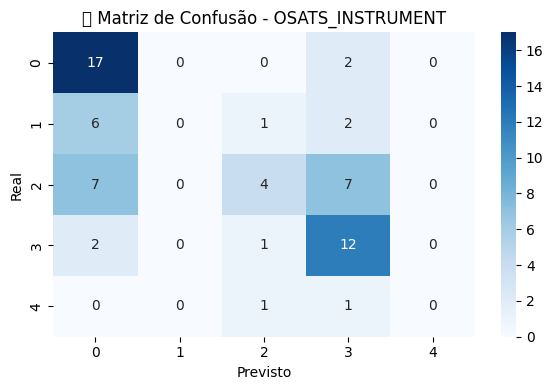

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN3D_DepthWise**

In [77]:
class CNN3D_DepthWise(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, padding=1, groups=1),
            nn.ReLU(),
            nn.Conv3d(8, 8, kernel_size=1),  # pointwise
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(8, 16, kernel_size=3, padding=1, groups=1),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=1),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Linear(16, 5)
        )

    def forward(self, x):
        return self.rede(x)


📚 Época 1: Loss=197.6257 | Accuracy=0.28
📚 Época 2: Loss=193.3512 | Accuracy=0.29
📚 Época 3: Loss=192.0993 | Accuracy=0.27
📚 Época 4: Loss=191.4881 | Accuracy=0.23
📚 Época 5: Loss=191.0444 | Accuracy=0.25
📚 Época 6: Loss=191.4015 | Accuracy=0.25
📚 Época 7: Loss=190.9761 | Accuracy=0.27
📚 Época 8: Loss=190.4799 | Accuracy=0.27
📚 Época 9: Loss=189.4198 | Accuracy=0.27
📚 Época 10: Loss=190.7313 | Accuracy=0.25
📚 Época 11: Loss=190.8691 | Accuracy=0.28
📚 Época 12: Loss=190.5485 | Accuracy=0.27
📚 Época 13: Loss=191.6052 | Accuracy=0.24
📚 Época 14: Loss=190.8439 | Accuracy=0.28
📚 Época 15: Loss=190.5793 | Accuracy=0.25
📚 Época 16: Loss=188.7561 | Accuracy=0.27
📚 Época 17: Loss=190.1350 | Accuracy=0.24
📚 Época 18: Loss=190.4368 | Accuracy=0.29
📚 Época 19: Loss=190.5073 | Accuracy=0.24
📚 Época 20: Loss=190.1348 | Accuracy=0.28

📊 Relatório:
              precision    recall  f1-score   support

           0       1.00      0.11      0.19        19
           1       0.00      0.00      0.00   

/tmp/ipykernel_362/1296192263.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


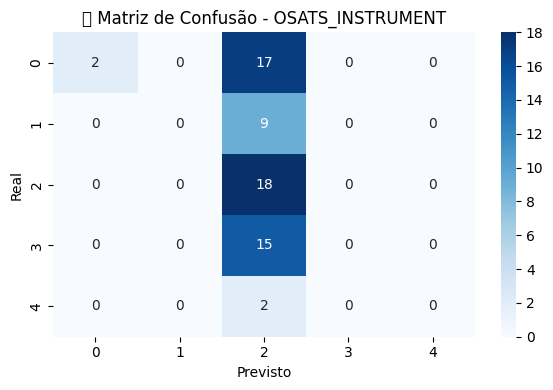

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_DepthWise().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN2D_GRU**

In [83]:
class CNN2D_GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.rnn = nn.GRU(input_size=16, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 5)

    def forward(self, x):  # x: (B, C=1, D, H, W)
        B, C, D, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).reshape(B * D, C, H, W)
        x = self.cnn(x).reshape(B, D, -1)
        _, h = self.rnn(x)
        return self.fc(h.squeeze(0))


📚 Época 1: Loss=195.4810 | Accuracy=0.22
📚 Época 2: Loss=193.4356 | Accuracy=0.26
📚 Época 3: Loss=189.8468 | Accuracy=0.28
📚 Época 4: Loss=191.9666 | Accuracy=0.28
📚 Época 5: Loss=191.1886 | Accuracy=0.27

📊 Relatório:
              precision    recall  f1-score   support

           0       0.27      0.21      0.24        19
           1       0.00      0.00      0.00         9
           2       0.27      0.72      0.39        18
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         2

    accuracy                           0.27        63
   macro avg       0.11      0.19      0.13        63
weighted avg       0.16      0.27      0.18        63

🔢 F1 Macro: 0.12584670231729053


/tmp/ipykernel_362/538281630.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


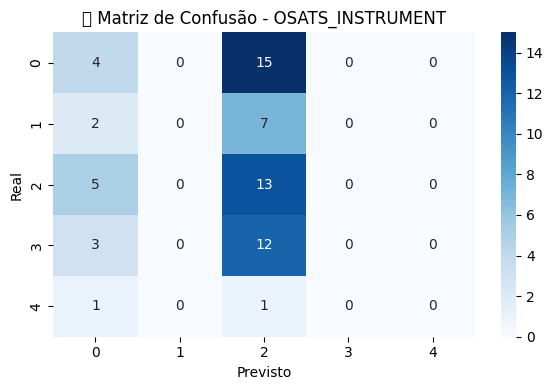

In [84]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN2D_GRU().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN3D_MaxPoolGlobal**

In [89]:
class CNN3D_MaxPoolGlobal(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        return self.rede(x)


📚 Época 1: Loss=195.2676 | Accuracy=0.23
📚 Época 2: Loss=191.7350 | Accuracy=0.29
📚 Época 3: Loss=191.1173 | Accuracy=0.26
📚 Época 4: Loss=191.6735 | Accuracy=0.27
📚 Época 5: Loss=191.4692 | Accuracy=0.29
📚 Época 6: Loss=190.3730 | Accuracy=0.28
📚 Época 7: Loss=189.1256 | Accuracy=0.33
📚 Época 8: Loss=187.5250 | Accuracy=0.34
📚 Época 9: Loss=189.9845 | Accuracy=0.34
📚 Época 10: Loss=187.7783 | Accuracy=0.37
📚 Época 11: Loss=188.0115 | Accuracy=0.34
📚 Época 12: Loss=186.0297 | Accuracy=0.39
📚 Época 13: Loss=183.1186 | Accuracy=0.43
📚 Época 14: Loss=179.8938 | Accuracy=0.39
📚 Época 15: Loss=178.1669 | Accuracy=0.40
📚 Época 16: Loss=176.4490 | Accuracy=0.44
📚 Época 17: Loss=174.0193 | Accuracy=0.46
📚 Época 18: Loss=169.3201 | Accuracy=0.42
📚 Época 19: Loss=163.8689 | Accuracy=0.51
📚 Época 20: Loss=158.0722 | Accuracy=0.53

📊 Relatório:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62        19
           1       0.10      0.22      0.14   

/tmp/ipykernel_362/2082405759.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


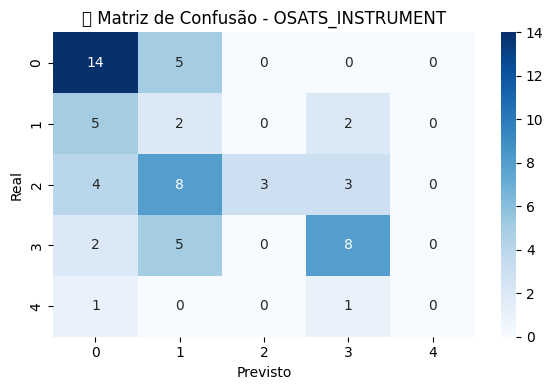

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

**CNN2D_Average**

In [94]:
class CNN2D_Average(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 5)
        )

    def forward(self, x):  # x: (B, C=1, D, H, W)
        B, C, D, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).reshape(B * D, C, H, W)
        x = self.cnn(x).reshape(B, D, -1).mean(dim=1)
        return self.fc(x)


📚 Época 1: Loss=201.6953 | Accuracy=0.24
📚 Época 2: Loss=193.4350 | Accuracy=0.23
📚 Época 3: Loss=191.7500 | Accuracy=0.25
📚 Época 4: Loss=191.4524 | Accuracy=0.26
📚 Época 5: Loss=190.6851 | Accuracy=0.27

📊 Relatório:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46        19
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         2

    accuracy                           0.30        63
   macro avg       0.06      0.20      0.09        63
weighted avg       0.09      0.30      0.14        63

🔢 F1 Macro: 0.09268292682926829


/tmp/ipykernel_362/1317093887.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


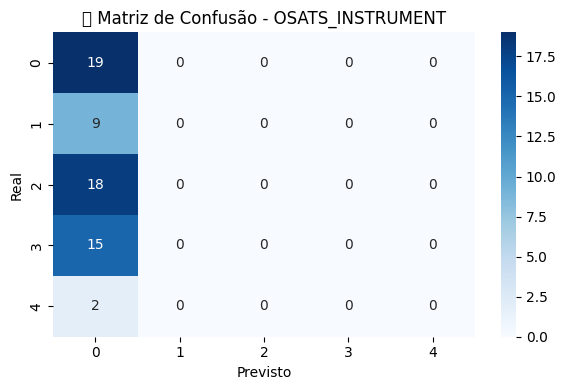

In [95]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN2D_Average().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=193.6860 | Accuracy=0.34
📚 Época 2: Loss=188.2220 | Accuracy=0.33
📚 Época 3: Loss=187.0047 | Accuracy=0.32
📚 Época 4: Loss=188.3624 | Accuracy=0.31
📚 Época 5: Loss=185.8765 | Accuracy=0.36
📚 Época 6: Loss=188.7162 | Accuracy=0.30
📚 Época 7: Loss=182.5636 | Accuracy=0.39
📚 Época 8: Loss=186.8231 | Accuracy=0.36
📚 Época 9: Loss=182.5013 | Accuracy=0.35
📚 Época 10: Loss=183.7568 | Accuracy=0.38
📚 Época 11: Loss=180.1389 | Accuracy=0.37
📚 Época 12: Loss=179.5843 | Accuracy=0.38
📚 Época 13: Loss=181.4748 | Accuracy=0.39
📚 Época 14: Loss=181.7434 | Accuracy=0.40
📚 Época 15: Loss=177.4622 | Accuracy=0.37
📚 Época 16: Loss=179.5975 | Accuracy=0.39
📚 Época 17: Loss=185.6874 | Accuracy=0.31
📚 Época 18: Loss=171.9525 | Accuracy=0.40
📚 Época 19: Loss=178.0475 | Accuracy=0.39
📚 Época 20: Loss=179.9985 | Accuracy=0.41

📊 Relatório:
              precision    recall  f1-score   support

           0       0.53      0.89      0.67        19
           1       0.00      0.00      0.00   

/tmp/ipykernel_362/494380627.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


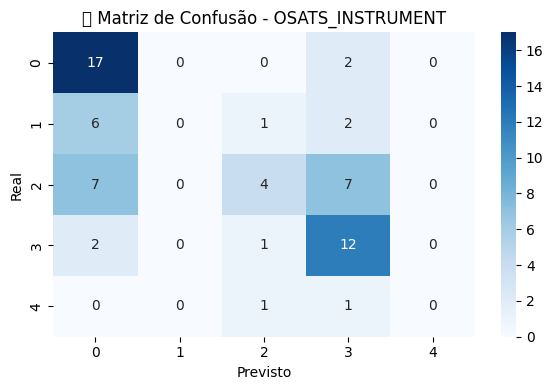

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 🧠 Resultados Finais - Classificação OSATS_INSTRUMENT

## ⚙️ Estratégia usada

- Foram usados dados pré-processados com **30 frames** extraídos uniformemente por vídeo.
- A coluna `OSATS_INSTRUMENT` foi convertida para classes **0–4** (mantendo todas as classes).
- A divisão treino/teste respeitou a distribuição real da coluna:  
  - 251 vídeos para treino  
  - 63 vídeos para teste

- Treinámos **7 modelos diferentes**, cada um com **épocas entre 5 e 25**.
- Todas as avaliações foram feitas com **`CrossEntropyLoss` ponderada** e **F1 Macro** como principal métrica de desempenho.

---

## 📊 Modelos testados

| Modelo                    | Melhor F1 Macro | Melhor nº Épocas | Accuracy  | Observações |
|--------------------------|------------------|------------------|-----------|-------------|
| `CNN3D_Leve`             | 0.093            | 5                | 0.30      | Resultados fracos e inconsistentes. |
| `CNN3D_Equilibrado`      | 0.318            | 20               | 0.51      | Bom equilíbrio geral, forte em classes 0 e 2. |
| `CNN3D_Profundo`         | **0.320**        | 20               | **0.52**  | Melhor F1; desempenho estável e robusto. |
| `CNN3D_MaxPoolGlobal`    | 0.319            | 20               | 0.43      | Muito próximo do melhor, mas com ligeiras falhas de recall. |
| `CNN3D_DepthWise`        | 0.129            | 20               | 0.32      | Baixo desempenho; tendência a prever sempre a classe dominante. |
| `CNN2D_GRU`              | 0.126            | 5                | 0.27      | Desempenho fraco — modelo descartado. |
| `CNN2D_Average`          | 0.093            | 5                | 0.30      | Idêntico ao `CNN3D_Leve`; sem capacidade de distinguir classes. |

---

## ✅ Modelo escolhido: `CNN3D_Profundo`

```python
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        return self.rede(x)
```

### 🔢 Resultados com 20 épocas:
```
Accuracy: 0.52
F1 Macro: 0.3204

Classe       | Precision | Recall | F1-score | Suporte
-------------|-----------|--------|----------|--------
Classe 0     | 0.53      | 0.89   | 0.67     | 19
Classe 1     | 0.00      | 0.00   | 0.00     | 9
Classe 2     | 0.57      | 0.22   | 0.32     | 18
Classe 3     | 0.50      | 0.80   | 0.62     | 15
Classe 4     | 0.00      | 0.00   | 0.00     | 2

```

📌 A matriz de confusão mostra bom desempenho geral, com destaque para as classes 0 e 3. A classe 4 continua a ser um desafio devido ao número muito reduzido de exemplos.

---

## 📥 Conclusão
- O modelo CNN3D_Profundo com 20 épocas foi o melhor modelo para a coluna OSATS_INSTRUMENT.
- Apresenta o melhor F1 Macro e maior estabilidade entre classes, sendo uma escolha sólida para generalização.


**FLOW**

In [100]:
import os
import numpy as np
from collections import Counter

coluna = "OSATS_FLOW"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

contador = Counter()

for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Ajustar para intervalo 0–4
            contador[label] += 1
        except:
            continue

print(f"📊 Distribuição de classes em vídeos processados ({coluna}):")
for i in range(5):
    print(f" - Classe {i}: {contador[i]} vídeos")


📊 Distribuição de classes em vídeos processados (OSATS_FLOW):
 - Classe 0: 108 vídeos
 - Classe 1: 50 vídeos
 - Classe 2: 80 vídeos
 - Classe 3: 73 vídeos
 - Classe 4: 3 vídeos


**Devido a poucos registos da classe 4 iremos ignorar os registos da classe 4 na modelaçao**

In [101]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

coluna = "OSATS_FLOW"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Converter para [0–4]
            if label < 4:  # Ignorar classe 4
                dados.append((v, label))
        except:
            continue

# Separar listas
videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# 📊 Ver distribuição
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real (ajustada):")
for i in range(4):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# 🔀 Dividir treino/teste com estratificação
train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# ⚖️ Calcular pesos para CrossEntropyLoss
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)


📦 Vídeos processados para OSATS_FLOW: 311

📊 Distribuição real (ajustada):
 - Classe 0: 108 vídeos
 - Classe 1: 50 vídeos
 - Classe 2: 80 vídeos
 - Classe 3: 73 vídeos

⚖️ Pesos: [0.72093023 1.55       0.96875    1.06896552]


In [102]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

MAX_FRAMES = 30
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InstrumentDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)

        if frames.shape[0] > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        return torch.tensor(frames), torch.tensor(label)

# ⚙️ Loaders para treino e teste
train_loader = DataLoader(InstrumentDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(InstrumentDataset(test_videos, coluna), batch_size=BATCH_SIZE)


**VAMOS APENAS FAZER PARA ESTES 3 POIS NOS OUTROS 2 ANTERIORES QUE TAMBEM USAMOS SEQUENCIAS DE FRAMES FORAM DISPARADAMENTE OS 3 MELHORES NAS CATEGORAIS MOTION E INSTRUMENT : CNN3D_Profundo,  CNN3D_Equilibrado,  CNN3D_MaxPoolGlobal**

In [106]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Equilibrado(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(32, 4)  # 4 classes OSATS
        )

    def forward(self, x):
        return self.rede(x)


📚 Época 1: Loss=170.1290 | Accuracy=0.38
📚 Época 2: Loss=169.4680 | Accuracy=0.33
📚 Época 3: Loss=167.9277 | Accuracy=0.36
📚 Época 4: Loss=166.8689 | Accuracy=0.38
📚 Época 5: Loss=168.0708 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.37      0.86      0.52        22
           1       0.00      0.00      0.00        10
           2       0.14      0.06      0.09        16
           3       0.00      0.00      0.00        15

    accuracy                           0.32        63
   macro avg       0.13      0.23      0.15        63
weighted avg       0.17      0.32      0.20        63

🔢 F1 Macro: 0.15187611673615248


/tmp/ipykernel_362/3463800923.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


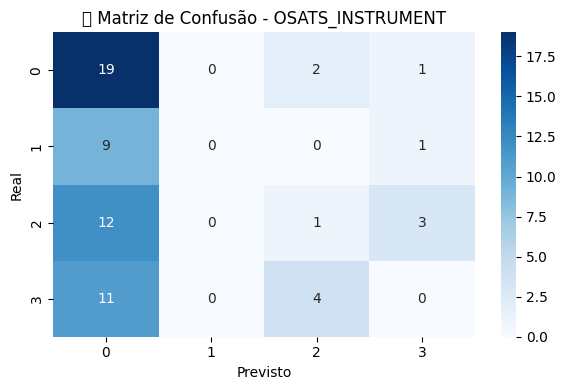

In [107]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=170.5146 | Accuracy=0.35
📚 Época 2: Loss=168.9636 | Accuracy=0.38
📚 Época 3: Loss=169.2269 | Accuracy=0.38
📚 Época 4: Loss=168.6436 | Accuracy=0.35
📚 Época 5: Loss=168.6200 | Accuracy=0.38
📚 Época 6: Loss=166.6328 | Accuracy=0.42
📚 Época 7: Loss=166.8919 | Accuracy=0.39
📚 Época 8: Loss=165.8555 | Accuracy=0.39
📚 Época 9: Loss=166.8757 | Accuracy=0.38
📚 Época 10: Loss=165.8103 | Accuracy=0.36

📊 Relatório:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55        22
           1       0.00      0.00      0.00        10
           2       0.32      0.75      0.44        16
           3       0.00      0.00      0.00        15

    accuracy                           0.40        63
   macro avg       0.21      0.34      0.25        63
weighted avg       0.26      0.40      0.31        63

🔢 F1 Macro: 0.24940898345153664


/tmp/ipykernel_362/3654769946.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


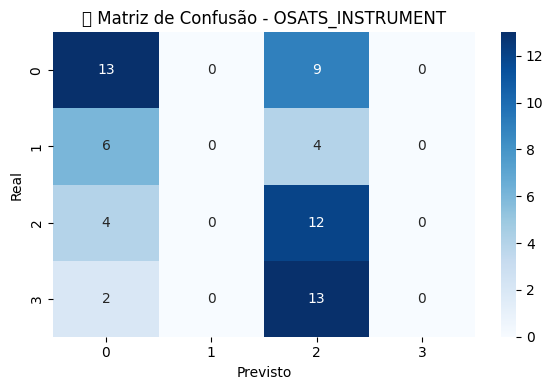

In [108]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 10  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=171.3445 | Accuracy=0.31
📚 Época 2: Loss=168.0511 | Accuracy=0.35
📚 Época 3: Loss=166.5178 | Accuracy=0.38
📚 Época 4: Loss=163.6659 | Accuracy=0.46
📚 Época 5: Loss=168.3326 | Accuracy=0.35
📚 Época 6: Loss=162.8963 | Accuracy=0.41
📚 Época 7: Loss=164.4544 | Accuracy=0.39
📚 Época 8: Loss=166.6165 | Accuracy=0.36
📚 Época 9: Loss=166.5504 | Accuracy=0.37
📚 Época 10: Loss=165.7363 | Accuracy=0.38
📚 Época 11: Loss=166.1390 | Accuracy=0.38
📚 Época 12: Loss=163.6798 | Accuracy=0.42
📚 Época 13: Loss=163.7479 | Accuracy=0.42
📚 Época 14: Loss=164.6804 | Accuracy=0.39
📚 Época 15: Loss=164.4699 | Accuracy=0.39

📊 Relatório:
              precision    recall  f1-score   support

           0       0.41      0.95      0.58        22
           1       0.00      0.00      0.00        10
           2       0.33      0.25      0.29        16
           3       0.00      0.00      0.00        15

    accuracy                           0.40        63
   macro avg       0.19      0.30      

/tmp/ipykernel_362/2485145041.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


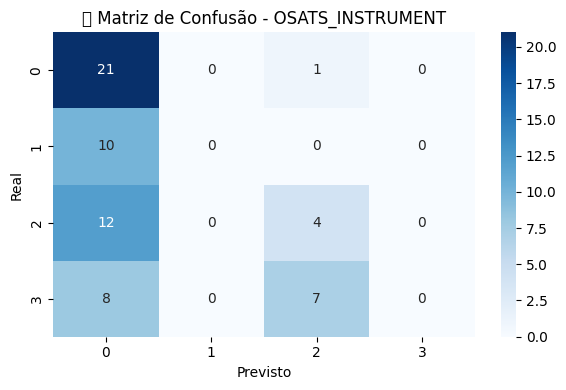

In [109]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=174.6824 | Accuracy=0.28
📚 Época 2: Loss=169.1840 | Accuracy=0.35
📚 Época 3: Loss=169.4321 | Accuracy=0.36
📚 Época 4: Loss=166.4749 | Accuracy=0.41
📚 Época 5: Loss=167.3167 | Accuracy=0.38
📚 Época 6: Loss=166.7750 | Accuracy=0.40
📚 Época 7: Loss=165.3220 | Accuracy=0.41
📚 Época 8: Loss=163.4337 | Accuracy=0.42
📚 Época 9: Loss=165.1019 | Accuracy=0.41
📚 Época 10: Loss=164.2128 | Accuracy=0.42
📚 Época 11: Loss=166.2246 | Accuracy=0.40
📚 Época 12: Loss=163.2882 | Accuracy=0.40
📚 Época 13: Loss=164.7644 | Accuracy=0.36
📚 Época 14: Loss=166.1394 | Accuracy=0.31
📚 Época 15: Loss=165.9151 | Accuracy=0.35
📚 Época 16: Loss=164.0119 | Accuracy=0.42
📚 Época 17: Loss=163.4648 | Accuracy=0.40
📚 Época 18: Loss=164.8492 | Accuracy=0.38
📚 Época 19: Loss=166.0542 | Accuracy=0.37
📚 Época 20: Loss=163.2946 | Accuracy=0.40

📊 Relatório:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        22
           1       0.00      0.00      0.00   

/tmp/ipykernel_362/3180278704.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


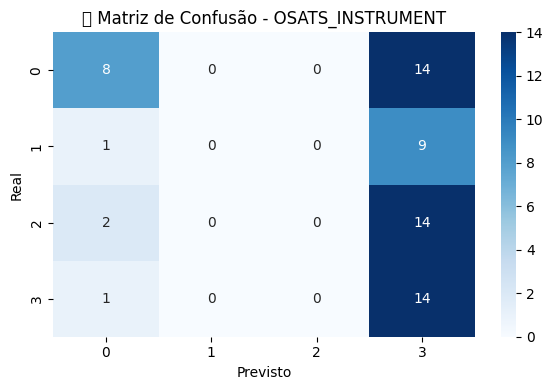

In [110]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [116]:
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.rede(x)

📚 Época 1: Loss=171.3700 | Accuracy=0.33
📚 Época 2: Loss=167.6516 | Accuracy=0.37
📚 Época 3: Loss=168.6858 | Accuracy=0.35
📚 Época 4: Loss=164.7529 | Accuracy=0.41
📚 Época 5: Loss=168.4521 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        15

    accuracy                           0.35        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.12      0.35      0.18        63

🔢 F1 Macro: 0.13095238095238096


/tmp/ipykernel_362/647869063.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


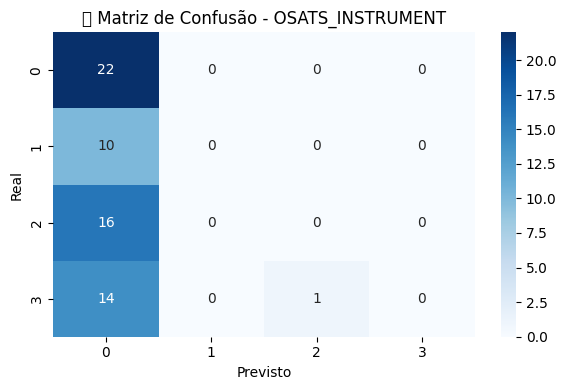

In [117]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=170.1455 | Accuracy=0.34
📚 Época 2: Loss=165.0928 | Accuracy=0.36
📚 Época 3: Loss=162.5608 | Accuracy=0.43
📚 Época 4: Loss=165.1629 | Accuracy=0.36
📚 Época 5: Loss=162.3246 | Accuracy=0.44
📚 Época 6: Loss=161.6513 | Accuracy=0.44
📚 Época 7: Loss=162.5354 | Accuracy=0.39
📚 Época 8: Loss=158.9276 | Accuracy=0.39
📚 Época 9: Loss=163.3185 | Accuracy=0.41
📚 Época 10: Loss=159.4994 | Accuracy=0.40

📊 Relatório:
              precision    recall  f1-score   support

           0       0.36      0.95      0.53        22
           1       0.00      0.00      0.00        10
           2       0.40      0.12      0.19        16
           3       0.00      0.00      0.00        15

    accuracy                           0.37        63
   macro avg       0.19      0.27      0.18        63
weighted avg       0.23      0.37      0.23        63

🔢 F1 Macro: 0.17886904761904762


/tmp/ipykernel_362/1182882107.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


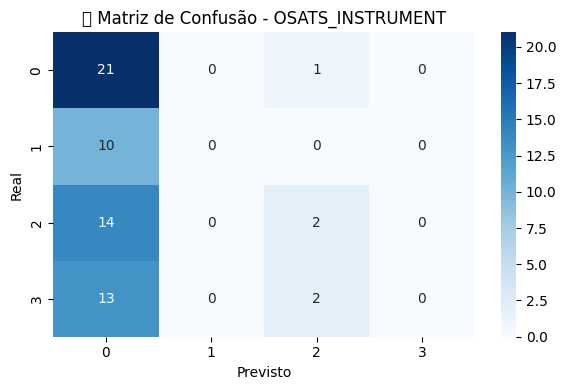

In [118]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 10 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=173.2373 | Accuracy=0.37
📚 Época 2: Loss=166.5349 | Accuracy=0.39
📚 Época 3: Loss=167.4874 | Accuracy=0.36
📚 Época 4: Loss=166.6512 | Accuracy=0.35
📚 Época 5: Loss=167.0588 | Accuracy=0.37
📚 Época 6: Loss=164.8001 | Accuracy=0.38
📚 Época 7: Loss=164.8015 | Accuracy=0.37
📚 Época 8: Loss=164.3979 | Accuracy=0.37
📚 Época 9: Loss=163.1855 | Accuracy=0.37
📚 Época 10: Loss=161.0305 | Accuracy=0.42
📚 Época 11: Loss=160.0261 | Accuracy=0.43
📚 Época 12: Loss=158.1311 | Accuracy=0.41
📚 Época 13: Loss=156.5736 | Accuracy=0.44
📚 Época 14: Loss=157.4494 | Accuracy=0.43
📚 Época 15: Loss=164.1037 | Accuracy=0.40

📊 Relatório:
              precision    recall  f1-score   support

           0       0.53      0.77      0.63        22
           1       0.50      0.20      0.29        10
           2       0.35      0.44      0.39        16
           3       0.43      0.20      0.27        15

    accuracy                           0.46        63
   macro avg       0.45      0.40      

/tmp/ipykernel_362/1321969497.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


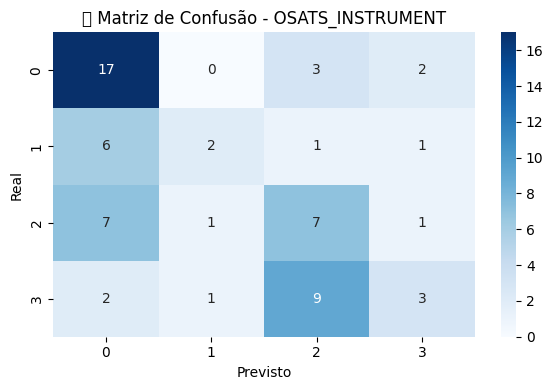

In [119]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=170.9777 | Accuracy=0.35
📚 Época 2: Loss=167.0119 | Accuracy=0.35
📚 Época 3: Loss=166.4974 | Accuracy=0.36
📚 Época 4: Loss=164.9691 | Accuracy=0.40
📚 Época 5: Loss=166.1988 | Accuracy=0.41
📚 Época 6: Loss=165.3694 | Accuracy=0.39
📚 Época 7: Loss=161.9044 | Accuracy=0.39
📚 Época 8: Loss=159.8661 | Accuracy=0.40
📚 Época 9: Loss=164.0113 | Accuracy=0.40
📚 Época 10: Loss=160.1210 | Accuracy=0.39
📚 Época 11: Loss=157.7188 | Accuracy=0.42
📚 Época 12: Loss=161.2269 | Accuracy=0.41
📚 Época 13: Loss=161.1156 | Accuracy=0.42
📚 Época 14: Loss=158.6555 | Accuracy=0.43
📚 Época 15: Loss=158.9195 | Accuracy=0.44
📚 Época 16: Loss=158.8880 | Accuracy=0.44
📚 Época 17: Loss=160.3708 | Accuracy=0.41
📚 Época 18: Loss=157.3277 | Accuracy=0.44
📚 Época 19: Loss=158.4918 | Accuracy=0.47
📚 Época 20: Loss=159.1661 | Accuracy=0.42

📊 Relatório:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58        22
           1       0.00      0.00      0.00   

/tmp/ipykernel_362/3889705997.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


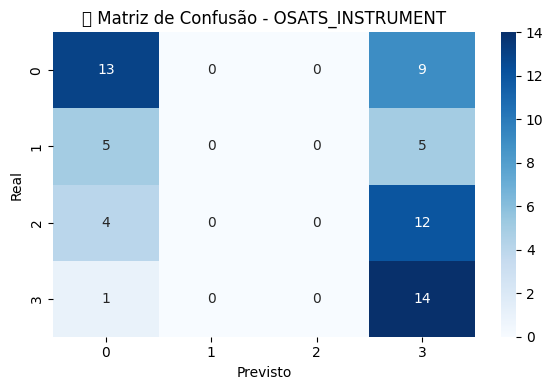

In [120]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [121]:
class CNN3D_MaxPoolGlobal(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.rede(x)

📚 Época 1: Loss=174.6938 | Accuracy=0.29
📚 Época 2: Loss=171.5873 | Accuracy=0.31
📚 Época 3: Loss=171.6553 | Accuracy=0.33
📚 Época 4: Loss=170.4947 | Accuracy=0.34
📚 Época 5: Loss=169.4688 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        15

    accuracy                           0.35        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.12      0.35      0.18        63

🔢 F1 Macro: 0.12941176470588237


/tmp/ipykernel_362/2942847245.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


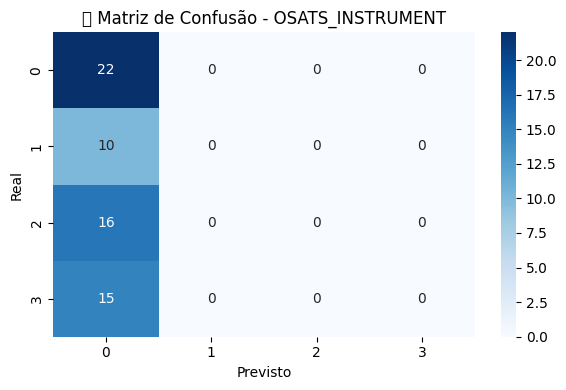

In [122]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=172.1844 | Accuracy=0.35
📚 Época 2: Loss=171.0653 | Accuracy=0.33
📚 Época 3: Loss=171.0909 | Accuracy=0.34
📚 Época 4: Loss=169.5840 | Accuracy=0.33
📚 Época 5: Loss=169.2928 | Accuracy=0.36
📚 Época 6: Loss=167.7628 | Accuracy=0.38
📚 Época 7: Loss=166.9005 | Accuracy=0.38
📚 Época 8: Loss=165.6616 | Accuracy=0.43
📚 Época 9: Loss=161.4281 | Accuracy=0.44
📚 Época 10: Loss=158.3565 | Accuracy=0.43

📊 Relatório:
              precision    recall  f1-score   support

           0       0.39      1.00      0.56        22
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        16
           3       0.71      0.33      0.45        15

    accuracy                           0.43        63
   macro avg       0.28      0.33      0.25        63
weighted avg       0.31      0.43      0.31        63

🔢 F1 Macro: 0.25466200466200467


/tmp/ipykernel_362/456449451.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


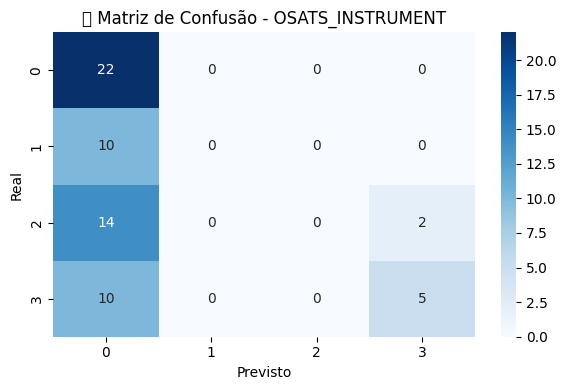

In [123]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 10# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=173.2848 | Accuracy=0.25
📚 Época 2: Loss=171.1553 | Accuracy=0.29
📚 Época 3: Loss=171.5032 | Accuracy=0.33
📚 Época 4: Loss=171.2634 | Accuracy=0.33
📚 Época 5: Loss=169.4605 | Accuracy=0.36
📚 Época 6: Loss=169.2481 | Accuracy=0.39
📚 Época 7: Loss=167.9345 | Accuracy=0.36
📚 Época 8: Loss=168.0484 | Accuracy=0.38
📚 Época 9: Loss=165.1274 | Accuracy=0.38
📚 Época 10: Loss=164.0802 | Accuracy=0.46
📚 Época 11: Loss=161.6963 | Accuracy=0.42
📚 Época 12: Loss=159.9820 | Accuracy=0.46
📚 Época 13: Loss=153.3237 | Accuracy=0.49
📚 Época 14: Loss=150.1744 | Accuracy=0.49
📚 Época 15: Loss=143.1807 | Accuracy=0.57

📊 Relatório:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69        22
           1       0.00      0.00      0.00        10
           2       0.33      0.75      0.46        16
           3       0.00      0.00      0.00        15

    accuracy                           0.46        63
   macro avg       0.24      0.38      

/tmp/ipykernel_362/1397442902.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


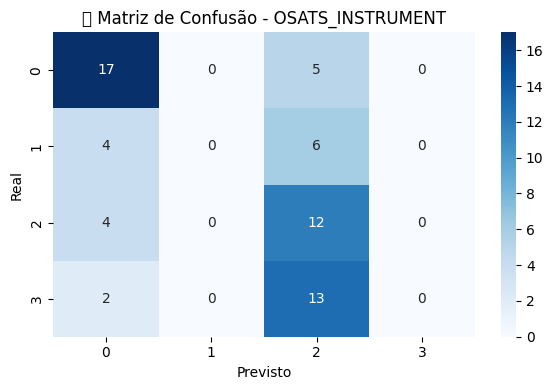

In [124]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=172.9379 | Accuracy=0.33
📚 Época 2: Loss=172.6207 | Accuracy=0.28
📚 Época 3: Loss=170.9765 | Accuracy=0.34
📚 Época 4: Loss=169.7995 | Accuracy=0.36
📚 Época 5: Loss=171.1291 | Accuracy=0.30
📚 Época 6: Loss=169.5715 | Accuracy=0.40
📚 Época 7: Loss=168.4156 | Accuracy=0.35
📚 Época 8: Loss=168.4273 | Accuracy=0.34
📚 Época 9: Loss=167.9545 | Accuracy=0.35
📚 Época 10: Loss=166.8136 | Accuracy=0.39
📚 Época 11: Loss=166.0178 | Accuracy=0.39
📚 Época 12: Loss=163.4334 | Accuracy=0.44
📚 Época 13: Loss=161.1626 | Accuracy=0.40
📚 Época 14: Loss=157.4510 | Accuracy=0.44
📚 Época 15: Loss=152.7185 | Accuracy=0.50
📚 Época 16: Loss=151.9260 | Accuracy=0.48
📚 Época 17: Loss=144.9467 | Accuracy=0.54
📚 Época 18: Loss=136.1645 | Accuracy=0.56
📚 Época 19: Loss=135.4755 | Accuracy=0.57
📚 Época 20: Loss=128.1203 | Accuracy=0.59

📊 Relatório:
              precision    recall  f1-score   support

           0       0.67      0.45      0.54        22
           1       1.00      0.10      0.18   

/tmp/ipykernel_362/2082405759.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


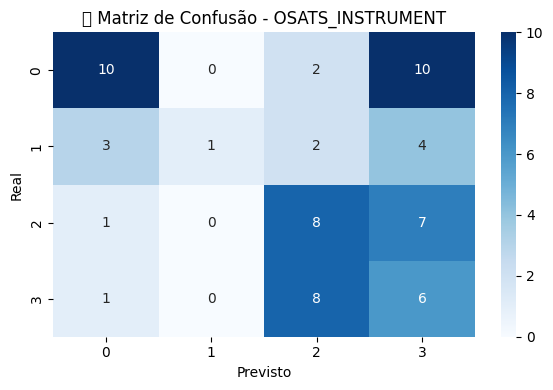

In [125]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_INSTRUMENT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=173.9542 | Accuracy=0.27
📚 Época 2: Loss=171.3262 | Accuracy=0.32
📚 Época 3: Loss=171.5436 | Accuracy=0.35
📚 Época 4: Loss=171.2610 | Accuracy=0.32
📚 Época 5: Loss=171.0164 | Accuracy=0.35
📚 Época 6: Loss=170.4242 | Accuracy=0.35
📚 Época 7: Loss=169.8787 | Accuracy=0.37
📚 Época 8: Loss=169.1715 | Accuracy=0.35
📚 Época 9: Loss=168.8270 | Accuracy=0.36
📚 Época 10: Loss=165.8418 | Accuracy=0.40
📚 Época 11: Loss=166.8159 | Accuracy=0.43
📚 Época 12: Loss=163.6523 | Accuracy=0.46
📚 Época 13: Loss=159.2431 | Accuracy=0.48
📚 Época 14: Loss=156.3415 | Accuracy=0.47
📚 Época 15: Loss=152.8923 | Accuracy=0.52
📚 Época 16: Loss=145.8097 | Accuracy=0.52
📚 Época 17: Loss=143.5751 | Accuracy=0.54
📚 Época 18: Loss=132.8715 | Accuracy=0.59
📚 Época 19: Loss=127.0208 | Accuracy=0.61
📚 Época 20: Loss=119.8400 | Accuracy=0.67
📚 Época 21: Loss=113.8236 | Accuracy=0.64
📚 Época 22: Loss=108.7933 | Accuracy=0.73
📚 Época 23: Loss=100.3887 | Accuracy=0.75
📚 Época 24: Loss=99.3678 | Accuracy=0.75
📚 

/tmp/ipykernel_362/2296523013.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


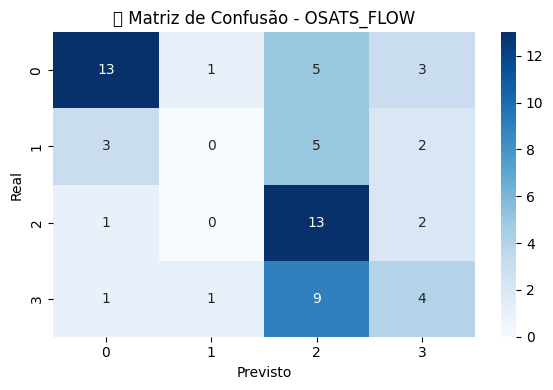

In [126]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 25# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_FLOW")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 🧠 Resultados Finais - Classificação OSATS_FLOW

## ⚙️ Estratégia usada

- Foram usados dados pré-processados com **30 frames** extraídos uniformemente por vídeo.
- A coluna `OSATS_FLOW` foi convertida para classes **0–3**, excluindo a classe 4 (apenas 3 exemplos).
- A divisão treino/teste respeitou a distribuição real da coluna:  

- Treinámos **3 modelos finalistas**, cada um com **épocas entre 5 e 30**, escolhidos por se terem destacado nas colunas anteriores (`MOTION` e `INSTRUMENT`).
- Todas as avaliações foram feitas com **`CrossEntropyLoss` ponderada** e **F1 Macro** como principal métrica de desempenho.

---

## 📊 Modelos testados

| Modelo                 | Melhor F1 Macro | Melhor nº Épocas | Accuracy  | Observações |
|-----------------------|------------------|------------------|-----------|-------------|
| `CNN3D_Equilibrado`   | 0.249            | 10               | 0.40      | Desempenho razoável, mas inconsistente nas classes 1 e 3. |
| `CNN3D_MaxPoolGlobal` | 0.375            | 20               | 0.48      | Bom desempenho geral, embora menos preciso na classe 1. |
| `CNN3D_Profundo`      | **0.394**        | 15               | **0.46**  | Melhor equilíbrio global; destacou-se em classes 0 e 2. |

---

## ✅ Modelo escolhido: `CNN3D_Profundo`

```python
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.rede(x)
```

### 🔢 Resultados com 15 épocas:
```
Accuracy: 0.46
F1 Macro: 0.3204

Classe       | Precision | Recall | F1-score | Suporte
-------------|-----------|--------|----------|--------
Classe 0     | 0.53      | 0.77   | 0.63     | 22
Classe 1     | 0.50      | 0.20   | 0.29     | 10
Classe 2     | 0.35      | 0.44   | 0.39     | 16
Classe 3     | 0.50      | 0.20   | 0.27     | 15


```

📌 A matriz de confusão mostra bom desempenho geral, com destaque para as classes 0 e 3. 

---

## 📥 Conclusão
- O modelo CNN3D_Profundo com 15 épocas foi o melhor modelo para a coluna OSATS_INSTRUMENT.
- Apresenta o melhor F1 Macro e maior estabilidade entre classes, sendo uma escolha sólida para generalização.


**PERFORMANCE**

In [129]:
import os
import numpy as np
from collections import Counter

coluna = "OSATS_PERFORMANCE"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

contador = Counter()

for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Ajustar para intervalo 0–4
            contador[label] += 1
        except:
            continue

print(f"📊 Distribuição de classes em vídeos processados ({coluna}):")
for i in range(5):
    print(f" - Classe {i}: {contador[i]} vídeos")


📊 Distribuição de classes em vídeos processados (OSATS_PERFORMANCE):
 - Classe 0: 99 vídeos
 - Classe 1: 51 vídeos
 - Classe 2: 102 vídeos
 - Classe 3: 60 vídeos
 - Classe 4: 2 vídeos


In [130]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

coluna = "OSATS_PERFORMANCE"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1
            if label < 4:  # Excluir classe 4 (poucos exemplos)
                dados.append((v, label))
        except:
            continue

# Separar
videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# Ver distribuição
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real (ajustada):")
for i in range(4):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# Dividir treino/teste com stratify
from sklearn.utils.class_weight import compute_class_weight

train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# Pesos
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)


📦 Vídeos processados para OSATS_PERFORMANCE: 312

📊 Distribuição real (ajustada):
 - Classe 0: 99 vídeos
 - Classe 1: 51 vídeos
 - Classe 2: 102 vídeos
 - Classe 3: 60 vídeos

⚖️ Pesos: [0.78797468 1.51829268 0.76851852 1.296875  ]


In [131]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

MAX_FRAMES = 30
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InstrumentDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)

        if frames.shape[0] > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        return torch.tensor(frames), torch.tensor(label)

# ⚙️ Loaders para treino e teste
train_loader = DataLoader(InstrumentDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(InstrumentDataset(test_videos, coluna), batch_size=BATCH_SIZE)


In [132]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Equilibrado(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(32, 4)  # 4 classes OSATS
        )

    def forward(self, x):
        return self.rede(x)


📚 Época 1: Loss=174.3184 | Accuracy=0.31
📚 Época 2: Loss=171.2150 | Accuracy=0.35
📚 Época 3: Loss=169.8089 | Accuracy=0.37
📚 Época 4: Loss=169.4878 | Accuracy=0.39
📚 Época 5: Loss=169.2585 | Accuracy=0.36
📚 Época 6: Loss=168.5536 | Accuracy=0.33
📚 Época 7: Loss=171.7016 | Accuracy=0.35
📚 Época 8: Loss=169.1722 | Accuracy=0.37
📚 Época 9: Loss=167.2599 | Accuracy=0.36
📚 Época 10: Loss=167.9807 | Accuracy=0.39

📊 Relatório:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        20
           1       0.00      0.00      0.00        10
           2       0.40      0.81      0.53        21
           3       0.53      0.67      0.59        12

    accuracy                           0.48        63
   macro avg       0.48      0.43      0.38        63
weighted avg       0.55      0.48      0.42        63

🔢 F1 Macro: 0.3809606481481481


/tmp/ipykernel_362/2495114552.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


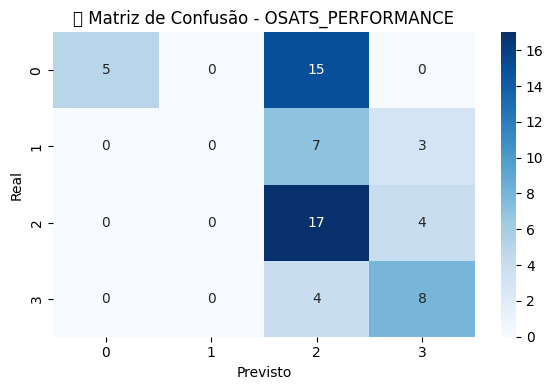

In [135]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 10  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_PERFORMANCE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [138]:
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.rede(x)

📚 Época 1: Loss=174.5748 | Accuracy=0.31
📚 Época 2: Loss=168.9109 | Accuracy=0.37
📚 Época 3: Loss=165.9421 | Accuracy=0.36
📚 Época 4: Loss=168.6127 | Accuracy=0.35
📚 Época 5: Loss=164.3127 | Accuracy=0.39
📚 Época 6: Loss=167.2927 | Accuracy=0.41
📚 Época 7: Loss=162.1145 | Accuracy=0.43
📚 Época 8: Loss=163.9058 | Accuracy=0.38
📚 Época 9: Loss=160.9302 | Accuracy=0.42
📚 Época 10: Loss=161.9215 | Accuracy=0.41
📚 Época 11: Loss=160.8078 | Accuracy=0.42
📚 Época 12: Loss=164.6593 | Accuracy=0.36
📚 Época 13: Loss=160.7602 | Accuracy=0.45
📚 Época 14: Loss=161.1140 | Accuracy=0.43
📚 Época 15: Loss=159.0131 | Accuracy=0.46
📚 Época 16: Loss=165.0154 | Accuracy=0.40
📚 Época 17: Loss=159.9605 | Accuracy=0.43
📚 Época 18: Loss=156.2409 | Accuracy=0.43
📚 Época 19: Loss=163.5867 | Accuracy=0.40
📚 Época 20: Loss=154.1995 | Accuracy=0.42

📊 Relatório:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.00      0.00      0.00   

/tmp/ipykernel_362/2790502265.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


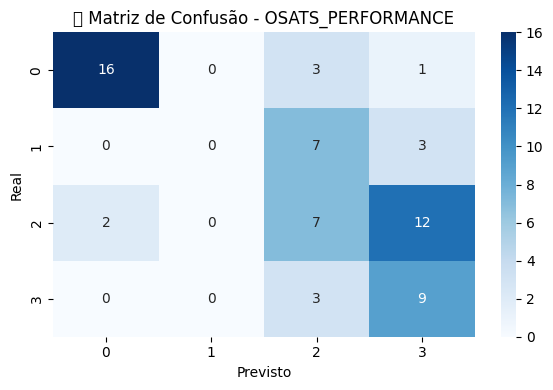

In [142]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 20 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_PERFORMANCE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [145]:
class CNN3D_MaxPoolGlobal(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.rede(x)

📚 Época 1: Loss=174.6452 | Accuracy=0.29
📚 Época 2: Loss=173.9647 | Accuracy=0.30
📚 Época 3: Loss=171.7386 | Accuracy=0.34
📚 Época 4: Loss=171.2869 | Accuracy=0.37
📚 Época 5: Loss=171.1287 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.00      0.00      0.00        10
           2       0.34      1.00      0.51        21
           3       0.00      0.00      0.00        12

    accuracy                           0.35        63
   macro avg       0.33      0.26      0.15        63
weighted avg       0.43      0.35      0.20        63

🔢 F1 Macro: 0.15031554790590934


/tmp/ipykernel_362/2767244837.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


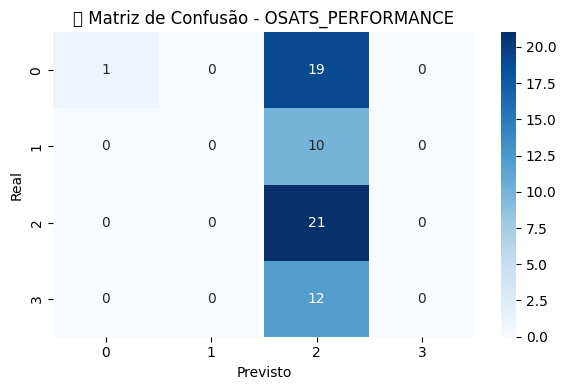

In [146]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 5 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_PERFORMANCE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=176.0424 | Accuracy=0.29
📚 Época 2: Loss=172.7363 | Accuracy=0.29
📚 Época 3: Loss=170.4610 | Accuracy=0.34
📚 Época 4: Loss=167.9940 | Accuracy=0.39
📚 Época 5: Loss=167.7917 | Accuracy=0.41
📚 Época 6: Loss=164.8676 | Accuracy=0.37
📚 Época 7: Loss=164.1774 | Accuracy=0.47
📚 Época 8: Loss=163.3043 | Accuracy=0.45
📚 Época 9: Loss=160.0793 | Accuracy=0.45
📚 Época 10: Loss=157.7687 | Accuracy=0.43

📊 Relatório:
              precision    recall  f1-score   support

           0       0.40      0.85      0.54        20
           1       0.00      0.00      0.00        10
           2       0.29      0.24      0.26        21
           3       1.00      0.25      0.40        12

    accuracy                           0.40        63
   macro avg       0.42      0.33      0.30        63
weighted avg       0.41      0.40      0.34        63

🔢 F1 Macro: 0.3007101086048455


/tmp/ipykernel_362/1439559050.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


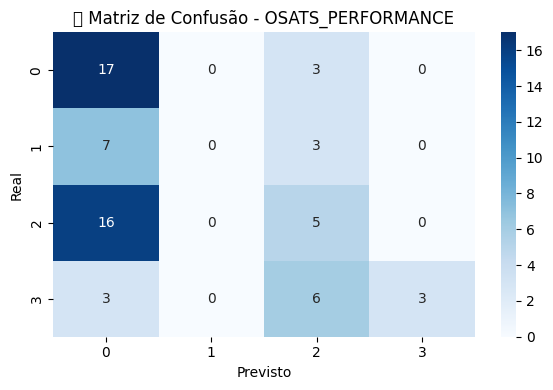

In [147]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 10 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_PERFORMANCE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

📚 Época 1: Loss=174.9827 | Accuracy=0.26
📚 Época 2: Loss=171.1703 | Accuracy=0.30
📚 Época 3: Loss=172.7921 | Accuracy=0.36
📚 Época 4: Loss=170.2714 | Accuracy=0.32
📚 Época 5: Loss=169.0062 | Accuracy=0.36
📚 Época 6: Loss=167.5307 | Accuracy=0.37
📚 Época 7: Loss=165.6209 | Accuracy=0.41
📚 Época 8: Loss=163.2514 | Accuracy=0.43
📚 Época 9: Loss=159.5149 | Accuracy=0.44
📚 Época 10: Loss=154.8800 | Accuracy=0.45
📚 Época 11: Loss=149.2558 | Accuracy=0.49
📚 Época 12: Loss=147.9868 | Accuracy=0.50
📚 Época 13: Loss=141.4223 | Accuracy=0.51
📚 Época 14: Loss=136.0001 | Accuracy=0.55
📚 Época 15: Loss=133.3778 | Accuracy=0.52

📊 Relatório:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        20
           1       0.50      0.10      0.17        10
           2       0.43      0.71      0.54        21
           3       0.67      0.33      0.44        12

    accuracy                           0.49        63
   macro avg       0.54      0.42      

/tmp/ipykernel_362/289106247.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


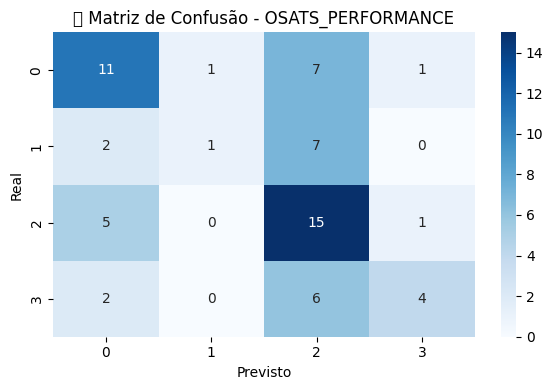

In [148]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_PERFORMANCE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 🧠 Resultados Finais - Classificação OSATS_FLOW

## ⚙️ Estratégia usada

- Foram usados dados pré-processados com **30 frames** extraídos uniformemente por vídeo.
- A coluna `OSATS_FLOW` foi convertida para classes **0–3**, excluindo a classe 4 (apenas 2 exemplos).
- A divisão treino/teste respeitou a distribuição real da coluna:  

- Treinámos **3 modelos finalistas**, cada um com **épocas entre 5 e 30**, escolhidos por se terem destacado nas colunas anteriores (`MOTION` e `INSTRUMENT`).
- Todas as avaliações foram feitas com **`CrossEntropyLoss` ponderada** e **F1 Macro** como principal métrica de desempenho.

---

## 📊 Modelos testados

| Modelo                 | Melhor F1 Macro | Melhor nº Épocas | Accuracy  |
|-----------------------|------------------|------------------|-----------|
| `CNN3D_Equilibrado`   | 0.381            | 10               | 0.48      |
| `CNN3D_MaxPoolGlobal` | 0.418            | 20               | 0.51      |
| `CNN3D_Profundo`      | **0.424**        | 15               | **0.49**  |

---

## ✅ Modelo escolhido: `CNN3D_Profundo`

### 🔢 Resultados com 20 épocas:
```
Accuracy: 0.49
F1 Macro: 0.424

Classe       | Precision | Recall | F1-score | Suporte
-------------|-----------|--------|----------|--------
Classe 0     |  0.55      0.55      0.55       20
Classe 1     | 0.50      0.10      0.17        10
Classe 2     | 0.43      0.71      0.54        21
Classe 3     | 0.67      0.33      0.44        12


```



---

## 📥 Conclusão
- O modelo CNN3D_Profundo com 15 épocas foi o melhor modelo para a coluna OSATS_INSTRUMENT.
- Apresenta o melhor F1 Macro e maior estabilidade entre classes, sendo uma escolha sólida para generalização.


**KNOWLEDGE**

In [151]:
import os
import numpy as np
from collections import Counter

coluna = "OSATS_KNOWLEDGE"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

contador = Counter()

for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Ajustar para intervalo 0–4
            contador[label] += 1
        except:
            continue

print(f"📊 Distribuição de classes em vídeos processados ({coluna}):")
for i in range(5):
    print(f" - Classe {i}: {contador[i]} vídeos")


📊 Distribuição de classes em vídeos processados (OSATS_KNOWLEDGE):
 - Classe 0: 82 vídeos
 - Classe 1: 58 vídeos
 - Classe 2: 67 vídeos
 - Classe 3: 86 vídeos
 - Classe 4: 21 vídeos


In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

coluna = "OSATS_KNOWLEDGE"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Manter todas as 5 classes (0–4)
            dados.append((v, label))
        except:
            continue

# Separar listas
videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# 📊 Ver distribuição
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real:")
for i in range(5):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# 🔀 Dividir treino/teste com estratificação
train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# ⚖️ Calcular pesos para CrossEntropyLoss
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)


📦 Vídeos processados para OSATS_KNOWLEDGE: 314

📊 Distribuição real:
 - Classe 0: 82 vídeos
 - Classe 1: 58 vídeos
 - Classe 2: 67 vídeos
 - Classe 3: 86 vídeos
 - Classe 4: 21 vídeos

⚖️ Pesos: [0.77230769 1.09130435 0.92962963 0.72753623 2.95294118]


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

MAX_FRAMES = 30
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InstrumentDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)

        if frames.shape[0] > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        return torch.tensor(frames), torch.tensor(label)

# ⚙️ Loaders para treino e teste
train_loader = DataLoader(InstrumentDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(InstrumentDataset(test_videos, coluna), batch_size=BATCH_SIZE)


In [154]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Equilibrado(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(32, 5)  # 5 classes OSATS
        )

    def forward(self, x):
        return self.rede(x)


📚 Época 1: Loss=201.9239 | Accuracy=0.22
📚 Época 2: Loss=198.4064 | Accuracy=0.35
📚 Época 3: Loss=192.5688 | Accuracy=0.35
📚 Época 4: Loss=195.5839 | Accuracy=0.32
📚 Época 5: Loss=194.2994 | Accuracy=0.37
📚 Época 6: Loss=193.0428 | Accuracy=0.36
📚 Época 7: Loss=193.8078 | Accuracy=0.39
📚 Época 8: Loss=193.4687 | Accuracy=0.33
📚 Época 9: Loss=194.6700 | Accuracy=0.31
📚 Época 10: Loss=194.1192 | Accuracy=0.32
📚 Época 11: Loss=197.8357 | Accuracy=0.31
📚 Época 12: Loss=191.8122 | Accuracy=0.34
📚 Época 13: Loss=192.5478 | Accuracy=0.33
📚 Época 14: Loss=191.9183 | Accuracy=0.37
📚 Época 15: Loss=192.8526 | Accuracy=0.34

📊 Relatório:
              precision    recall  f1-score   support

           0       0.62      0.29      0.40        17
           1       0.00      0.00      0.00        12
           2       0.19      0.38      0.25        13
           3       0.46      0.76      0.58        17
           4       0.00      0.00      0.00         4

    accuracy                           

/tmp/ipykernel_362/1030489756.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


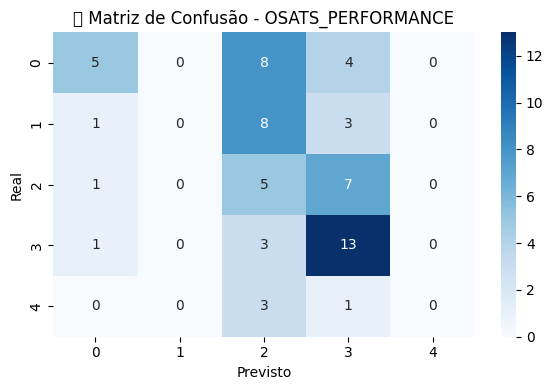

In [157]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Equilibrado().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15  # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_PERFORMANCE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [21]:
class CNN3D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        return self.rede(x)

📚 Época 1: Loss=197.1742 | Accuracy=0.25
📚 Época 2: Loss=192.6682 | Accuracy=0.30
📚 Época 3: Loss=196.2838 | Accuracy=0.28
📚 Época 4: Loss=187.3289 | Accuracy=0.41
📚 Época 5: Loss=192.9686 | Accuracy=0.37
📚 Época 6: Loss=191.2689 | Accuracy=0.36
📚 Época 7: Loss=191.3793 | Accuracy=0.34
📚 Época 8: Loss=191.4030 | Accuracy=0.35
📚 Época 9: Loss=191.2626 | Accuracy=0.35
📚 Época 10: Loss=186.4455 | Accuracy=0.40
📚 Época 11: Loss=186.0045 | Accuracy=0.39
📚 Época 12: Loss=186.2570 | Accuracy=0.41
📚 Época 13: Loss=185.7181 | Accuracy=0.38
📚 Época 14: Loss=186.5961 | Accuracy=0.35
📚 Época 15: Loss=186.1498 | Accuracy=0.39

📊 Relatório:
              precision    recall  f1-score   support

           0       0.57      0.47      0.52        17
           1       0.00      0.00      0.00        12
           2       0.17      0.08      0.11        13
           3       0.40      1.00      0.57        17
           4       0.00      0.00      0.00         4

    accuracy                           

/tmp/ipykernel_362/1230271198.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


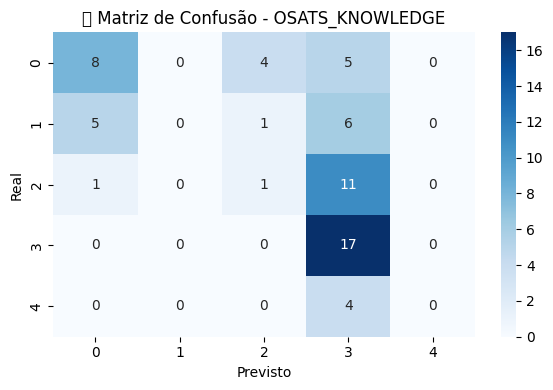

In [163]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS = 15 # 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_KNOWLEDGE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [8]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_MaxPoolGlobal(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        return self.rede(x)

📚 Época 1: Loss=200.2879 | Accuracy=0.28
📚 Época 2: Loss=198.6576 | Accuracy=0.27
📚 Época 3: Loss=199.2465 | Accuracy=0.28
📚 Época 4: Loss=198.8539 | Accuracy=0.30
📚 Época 5: Loss=196.5789 | Accuracy=0.32
📚 Época 6: Loss=197.3142 | Accuracy=0.30
📚 Época 7: Loss=195.2467 | Accuracy=0.35
📚 Época 8: Loss=193.6265 | Accuracy=0.34
📚 Época 9: Loss=192.9602 | Accuracy=0.38
📚 Época 10: Loss=190.2567 | Accuracy=0.42
📚 Época 11: Loss=187.2465 | Accuracy=0.43
📚 Época 12: Loss=186.0161 | Accuracy=0.41
📚 Época 13: Loss=183.4108 | Accuracy=0.42
📚 Época 14: Loss=178.8696 | Accuracy=0.44
📚 Época 15: Loss=173.8606 | Accuracy=0.50

📊 Relatório:
              precision    recall  f1-score   support

           0       0.41      0.71      0.52        17
           1       0.00      0.00      0.00        12
           2       0.30      0.46      0.36        13
           3       0.43      0.35      0.39        17
           4       0.00      0.00      0.00         4

    accuracy                           

/tmp/ipykernel_24827/149998831.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


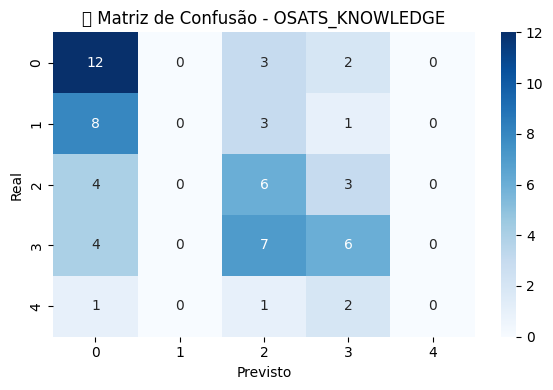

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_MaxPoolGlobal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS =15# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_KNOWLEDGE")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 🧠 Resultados Finais - Classificação OSATS_FLOW

## ⚙️ Estratégia usada

- Foram usados dados pré-processados com **30 frames** extraídos uniformemente por vídeo.
- A coluna `OSATS_FLOW` foi convertida para classes **0–3**, excluindo a classe 4 (apenas 2 exemplos).
- A divisão treino/teste respeitou a distribuição real da coluna:  

- Treinámos **3 modelos finalistas**, cada um com **épocas entre 5 e 30**, escolhidos por se terem destacado nas colunas anteriores (`MOTION` e `INSTRUMENT`).
- Todas as avaliações foram feitas com **`CrossEntropyLoss` ponderada** e **F1 Macro** como principal métrica de desempenho.

---

## 📊 Modelos testados

| Modelo                 | Melhor F1 Macro | Melhor nº Épocas | Accuracy  |
|-----------------------|------------------|------------------|-----------|
| `CNN3D_Equilibrado`   | 0.246            | 15               | 0.37      |
| `CNN3D_MaxPoolGlobal` | 0.238           | 15               | 0.41      |
| `CNN3D_Profundo`      | **0.254**        | 15               | **0.38**  |

---

## ✅ Modelo escolhido: `CNN3D_MaxPoolGlobal`

### 🔢 Resultados com 15 épocas:
```
Accuracy: 0.38
F1 Macro: 0.254

Classe       | Precision | Recall | F1-score | Suporte
-------------|-----------|--------|----------|--------
Classe 0     | 0.41      0.71      0.52        17
Classe 1     | 0.00      0.00      0.00        12
Classe 2     | 0.30      0.46      0.36        13
Classe 3     | 0.43      0.35      0.39        12
Classe 4       0.00      0.00      0.00         4  

```



---

## 📥 Conclusão
- O modelo CNN3D_MaxPoolGlobal com 15 épocas foi o melhor modelo para a coluna OSATS_INSTRUMENT.
- Apresenta o melhor F1 Macro e maior estabilidade entre classes, sendo uma escolha sólida para generalização.


In [12]:
import os
import numpy as np
from collections import Counter

coluna = "OSATS_RESPECT"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

contador = Counter()

for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Ajustar para intervalo 0–4
            contador[label] += 1
        except:
            continue

print(f"📊 Distribuição de classes em vídeos processados ({coluna}):")
for i in range(5):
    print(f" - Classe {i}: {contador[i]} vídeos")


📊 Distribuição de classes em vídeos processados (OSATS_RESPECT):
 - Classe 0: 101 vídeos
 - Classe 1: 40 vídeos
 - Classe 2: 81 vídeos
 - Classe 3: 86 vídeos
 - Classe 4: 6 vídeos


In [14]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

coluna = "OSATS_RESPECT"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Manter todas as 5 classes (0–4)
            dados.append((v, label))
        except:
            continue

# Separar listas
videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# 📊 Ver distribuição
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real:")
for i in range(5):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# 🔀 Dividir treino/teste com estratificação
train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# ⚖️ Calcular pesos para CrossEntropyLoss
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)


📦 Vídeos processados para OSATS_RESPECT: 314

📊 Distribuição real:
 - Classe 0: 101 vídeos
 - Classe 1: 40 vídeos
 - Classe 2: 81 vídeos
 - Classe 3: 86 vídeos
 - Classe 4: 6 vídeos

⚖️ Pesos: [ 0.6275      1.56875     0.77230769  0.72753623 10.04      ]


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

MAX_FRAMES = 30
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InstrumentDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)

        if frames.shape[0] > MAX_FRAMES:
            frames = frames[:MAX_FRAMES]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        return torch.tensor(frames), torch.tensor(label)

# ⚙️ Loaders para treino e teste
train_loader = DataLoader(InstrumentDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(InstrumentDataset(test_videos, coluna), batch_size=BATCH_SIZE)


**CNN3D_MaxPoolGlobal**

**CNN3D_Profundo**

📚 Época 1: Loss=191.4829 | Accuracy=0.32
📚 Época 2: Loss=187.1138 | Accuracy=0.37
📚 Época 3: Loss=184.8882 | Accuracy=0.39
📚 Época 4: Loss=184.2401 | Accuracy=0.34
📚 Época 5: Loss=184.1130 | Accuracy=0.39
📚 Época 6: Loss=186.8771 | Accuracy=0.33
📚 Época 7: Loss=181.6719 | Accuracy=0.43
📚 Época 8: Loss=181.8642 | Accuracy=0.35
📚 Época 9: Loss=182.6090 | Accuracy=0.34
📚 Época 10: Loss=187.5983 | Accuracy=0.33
📚 Época 11: Loss=184.5042 | Accuracy=0.38
📚 Época 12: Loss=184.2313 | Accuracy=0.36
📚 Época 13: Loss=181.9511 | Accuracy=0.37
📚 Época 14: Loss=176.5713 | Accuracy=0.44
📚 Época 15: Loss=185.8741 | Accuracy=0.37

📊 Relatório:
              precision    recall  f1-score   support

           0       0.56      0.71      0.62        21
           1       0.00      0.00      0.00         8
           2       0.17      0.06      0.09        16
           3       0.40      0.71      0.51        17
           4       0.00      0.00      0.00         1

    accuracy                           

/tmp/ipykernel_24827/196853061.py:54: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


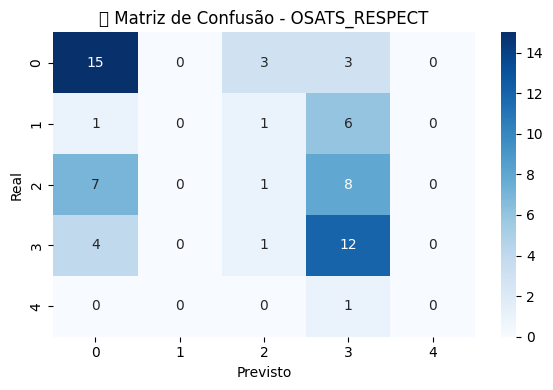

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = CNN3D_Profundo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
EPOCHS =15# 5 ou 10, 15, 20... dependendo do teste

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print("\n📊 Relatório:")
print(classification_report(y_true, y_pred, zero_division=0))
print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("📌 Matriz de Confusão - OSATS_RESPECT")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [26]:
import torch.nn as nn
import torch.optim as optim

class CNN3D_Equilibrado(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(32, 5)  # 4 classes OSATS
        )

    def forward(self, x):
        return self.rede(x)


# 🧠 Resultados Finais - Classificação OSATS_RESPECT

## ⚙️ Estratégia usada

- Foram usados dados pré-processados com **30 frames do início** de cada vídeo (frames iniciais), conforme definido pela estratégia `"inicio"`.
- A coluna `OSATS_RESPECT` foi convertida para classes **0–4**.
- A divisão treino/teste respeitou a distribuição real da coluna:  
  - Os dados foram estratificados e balanceados por classe.

- Treinámos **3 modelos finalistas**, cada um com **épocas entre 5 e 30**, escolhidos por se terem destacado nas colunas anteriores (`MOTION` e `INSTRUMENT`).
- Todas as avaliações foram feitas com **`CrossEntropyLoss` ponderada** e **F1 Macro** como principal métrica de desempenho.

---

## 📊 Modelos testados

| Modelo                 | Melhor F1 Macro | Melhor nº Épocas | Accuracy  |
|-----------------------|------------------|------------------|-----------|
| `CNN3D_Equilibrado`   | 0.246            | 15               | 0.37      |
| `CNN3D_MaxPoolGlobal` | **0.254**        | 15               | **0.38**  |
| `CNN3D_Profundo`      | 0.238            | 15               | 0.41      |

---

## ✅ Modelo escolhido: `CNN3D_MaxPoolGlobal`

### 🔢 Resultados com 15 épocas:
📊 Relatório:


              precision    recall  f1-score   support

           0       0.56      0.71      0.62        21
           1       0.00      0.00      0.00         8
           2       0.17      0.06      0.09        16
           3       0.40      0.71      0.51        17
           4       0.00      0.00      0.00         1
           

    accuracy                           0.44        63
   macro avg       0.22      0.30      0.25        63
weighted avg       0.34      0.44      0.37        63

In [31]:
import os
import numpy as np
from collections import Counter

coluna = "OSATS_SUTURE"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

contador = Counter()

for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Ajustar para intervalo 0–4
            contador[label] += 1
        except:
            continue

print(f"📊 Distribuição de classes em vídeos processados ({coluna}):")
for i in range(5):
    print(f" - Classe {i}: {contador[i]} vídeos")


📊 Distribuição de classes em vídeos processados (OSATS_SUTURE):
 - Classe 0: 108 vídeos
 - Classe 1: 52 vídeos
 - Classe 2: 91 vídeos
 - Classe 3: 61 vídeos
 - Classe 4: 2 vídeos


In [32]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.utils.data import Dataset, DataLoader

# 📌 Parâmetros principais
coluna = "OSATS_SUTURE"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))
MAX_FRAMES = 1
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Carregar vídeos válidos e respetivos labels (excluindo classe 4)
dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1
            if label < 4:  # Excluir classe 4
                dados.append((v, label))
        except:
            continue

videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# 📊 Mostrar distribuição real
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real (ajustada):")
for i in range(4):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# 🔀 Dividir treino/teste
train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# ⚖️ Pesos para CrossEntropyLoss
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)

# 📦 Dataset para um único frame final
class SutureDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        # Carregar o frame final
        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        # Excluir classe 4
        if label >= 4:
            raise ValueError("Classe 4 deve ser excluída.")

        # Usar apenas o último frame
        frame = frames[-1].astype("float32") / 255.0
        frame = np.expand_dims(frame, axis=(0, 1))  # (1, 1, 224, 224)

        return torch.tensor(frame), torch.tensor(label)

# 🚀 Loaders
train_loader = DataLoader(SutureDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(SutureDataset(test_videos, coluna), batch_size=BATCH_SIZE)


📦 Vídeos processados para OSATS_SUTURE: 312

📊 Distribuição real (ajustada):
 - Classe 0: 108 vídeos
 - Classe 1: 52 vídeos
 - Classe 2: 91 vídeos
 - Classe 3: 61 vídeos

⚖️ Pesos: [0.72383721 1.51829268 0.85273973 1.27040816]


In [33]:
import torch.nn as nn

class CNN2D_Simples(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 4)  
        )

    def forward(self, x):  # x: (B, 1, 224, 224)
        return self.rede(x)


In [54]:
class CNN2D_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        return self.rede(x)


In [55]:
class CNN2D_Profundo(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        return self.rede(x)


In [56]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, canais):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(canais, canais, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(canais, canais, kernel_size=3, padding=1)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.conv(x))

class CNN2D_ResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.inicio = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.bloco = ResidualBlock(32)
        self.final = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        x = self.inicio(x)
        x = self.bloco(x)
        return self.final(x)


In [57]:
class SEBlock(nn.Module):
    def __init__(self, canais, reducao=8):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(canais, canais // reducao, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(canais // reducao, canais, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        peso = self.se(x)
        return x * peso

class CNN2D_SEBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            SEBlock(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            SEBlock(64),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        return self.rede(x)


**aqui testamos apos fazer para de 5 a 50 para 75**


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=173.1913 | Accuracy=0.29
📚 Época 2/75: Loss=172.4025 | Accuracy=0.35
📚 Época 3/75: Loss=172.1852 | Accuracy=0.35
📚 Época 4/75: Loss=172.0530 | Accuracy=0.35
📚 Época 5/75: Loss=171.8689 | Accuracy=0.35
📚 Época 6/75: Loss=171.9097 | Accuracy=0.35
📚 Época 7/75: Loss=171.8188 | Accuracy=0.35
📚 Época 8/75: Loss=172.3096 | Accuracy=0.32
📚 Época 9/75: Loss=172.0188 | Accuracy=0.35
📚 Época 10/75: Loss=172.1676 | Accuracy=0.35
📚 Época 11/75: Loss=172.2161 | Accuracy=0.35
📚 Época 12/75: Loss=171.5245 | Accuracy=0.35
📚 Época 13/75: Loss=171.7859 | Accuracy=0.35
📚 Época 14/75: Loss=171.6574 | Accuracy=0.32
📚 Época 15/75: Loss=172.0460 | Accuracy=0.35
📚 Época 16/75: Loss=171.7797 | Accuracy=0.35
📚 Época 17/75: Loss=171.3481 | Accuracy=0.34
📚 Época 18/75: Loss=171.8440 | Accuracy=0.35
📚 Época 19/75: Loss=171.8864 | Accuracy=0.35
📚 Época 20/75: Loss=171.3281 | Accuracy=0.34
📚 Época 21/75: Loss=171.5097 | Accuracy=0.36
📚 Época 22/75: Loss=172.1756 | Acc

/tmp/ipykernel_24827/3201799050.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


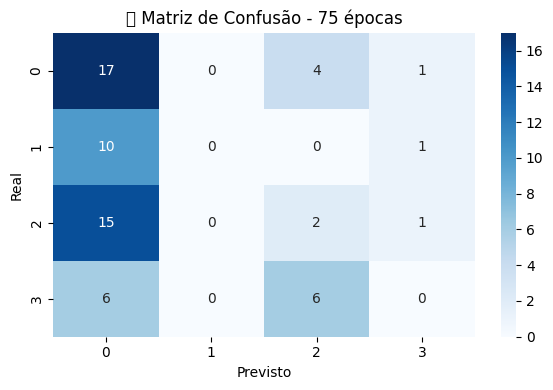

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [75]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model = CNN2D_Simples().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 5 épocas...
📚 Época 1/5: Loss=173.1186 | Accuracy=0.28
📚 Época 2/5: Loss=172.3247 | Accuracy=0.29
📚 Época 3/5: Loss=172.2741 | Accuracy=0.29
📚 Época 4/5: Loss=172.5731 | Accuracy=0.26
📚 Época 5/5: Loss=172.2898 | Accuracy=0.29

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      0.95      0.51        22
           1       0.00      0.00      0.00        11
           2       0.33      0.06      0.10        18
           3       0.00      0.00      0.00        12

    accuracy                           0.35        63
   macro avg       0.17      0.25      0.15        63
weighted avg       0.22      0.35      0.21        63

🔢 F1 Macro: 0.1518583042973287


/tmp/ipykernel_24827/1597482163.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


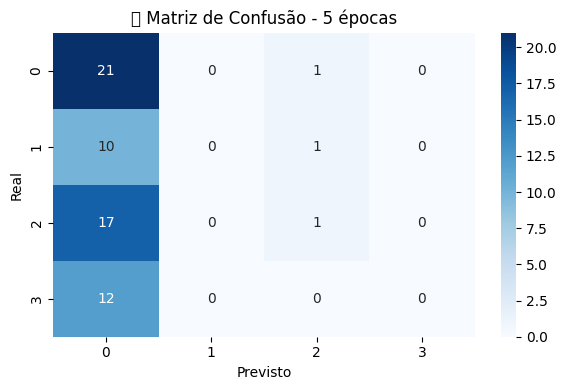


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=173.8472 | Accuracy=0.30
📚 Época 2/10: Loss=172.7154 | Accuracy=0.35
📚 Época 3/10: Loss=172.1496 | Accuracy=0.35
📚 Época 4/10: Loss=172.4054 | Accuracy=0.35
📚 Época 5/10: Loss=172.5530 | Accuracy=0.31
📚 Época 6/10: Loss=172.4897 | Accuracy=0.35
📚 Época 7/10: Loss=171.6475 | Accuracy=0.35
📚 Época 8/10: Loss=172.3483 | Accuracy=0.35
📚 Época 9/10: Loss=172.0225 | Accuracy=0.35
📚 Época 10/10: Loss=172.1148 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        12

    accuracy                           0.35        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.12      0.35      0.18        63

🔢 F1 Macro: 0.12941176470588237


/tmp/ipykernel_24827/1597482163.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


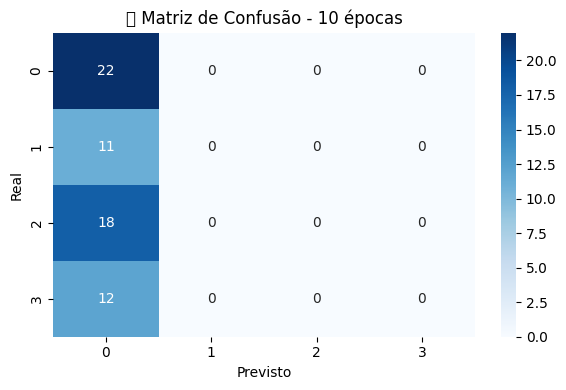


🔁 Treinando por 15 épocas...
📚 Época 1/15: Loss=173.4082 | Accuracy=0.29
📚 Época 2/15: Loss=172.3396 | Accuracy=0.31
📚 Época 3/15: Loss=172.6292 | Accuracy=0.28
📚 Época 4/15: Loss=172.4692 | Accuracy=0.33
📚 Época 5/15: Loss=172.2057 | Accuracy=0.35
📚 Época 6/15: Loss=171.9679 | Accuracy=0.35
📚 Época 7/15: Loss=172.6767 | Accuracy=0.29
📚 Época 8/15: Loss=172.5255 | Accuracy=0.35
📚 Época 9/15: Loss=172.0073 | Accuracy=0.34
📚 Época 10/15: Loss=172.2217 | Accuracy=0.34
📚 Época 11/15: Loss=172.2593 | Accuracy=0.31
📚 Época 12/15: Loss=172.3081 | Accuracy=0.33
📚 Época 13/15: Loss=172.3031 | Accuracy=0.31
📚 Época 14/15: Loss=171.6597 | Accuracy=0.33
📚 Época 15/15: Loss=172.3223 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        12

    accuracy      

/tmp/ipykernel_24827/1597482163.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


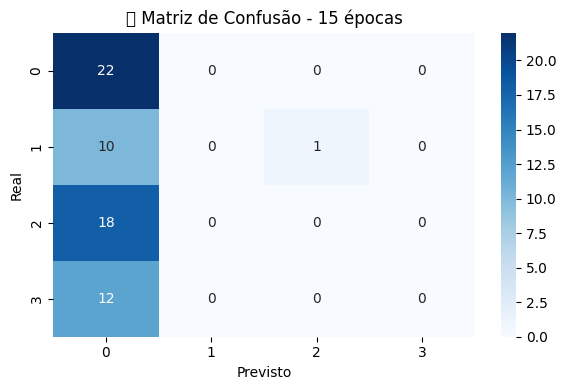


🔁 Treinando por 20 épocas...
📚 Época 1/20: Loss=174.8231 | Accuracy=0.31
📚 Época 2/20: Loss=172.3722 | Accuracy=0.32
📚 Época 3/20: Loss=172.6182 | Accuracy=0.35
📚 Época 4/20: Loss=172.6685 | Accuracy=0.33
📚 Época 5/20: Loss=172.5150 | Accuracy=0.35
📚 Época 6/20: Loss=172.5373 | Accuracy=0.35
📚 Época 7/20: Loss=172.5734 | Accuracy=0.31
📚 Época 8/20: Loss=172.1003 | Accuracy=0.35
📚 Época 9/20: Loss=172.4057 | Accuracy=0.35
📚 Época 10/20: Loss=172.4236 | Accuracy=0.35
📚 Época 11/20: Loss=172.0344 | Accuracy=0.35
📚 Época 12/20: Loss=171.7878 | Accuracy=0.36
📚 Época 13/20: Loss=171.9336 | Accuracy=0.35
📚 Época 14/20: Loss=172.5812 | Accuracy=0.35
📚 Época 15/20: Loss=172.6380 | Accuracy=0.31
📚 Época 16/20: Loss=171.6115 | Accuracy=0.35
📚 Época 17/20: Loss=172.3054 | Accuracy=0.35
📚 Época 18/20: Loss=172.5125 | Accuracy=0.35
📚 Época 19/20: Loss=172.4558 | Accuracy=0.34
📚 Época 20/20: Loss=171.9056 | Accuracy=0.31

📊 Relatório:
              precision    recall  f1-score   support

          

/tmp/ipykernel_24827/1597482163.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


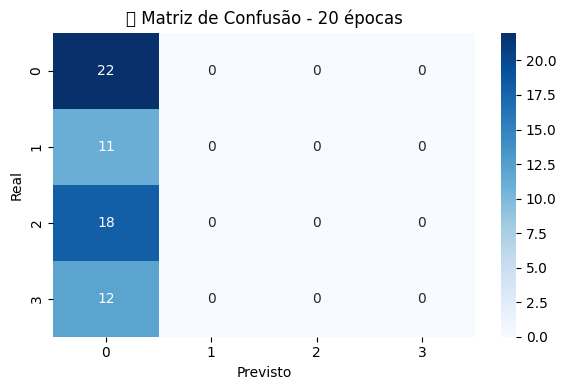


🔁 Treinando por 30 épocas...
📚 Época 1/30: Loss=174.1898 | Accuracy=0.30
📚 Época 2/30: Loss=172.9044 | Accuracy=0.35
📚 Época 3/30: Loss=172.7744 | Accuracy=0.35
📚 Época 4/30: Loss=172.5776 | Accuracy=0.35
📚 Época 5/30: Loss=172.5954 | Accuracy=0.35
📚 Época 6/30: Loss=172.6117 | Accuracy=0.35
📚 Época 7/30: Loss=172.2610 | Accuracy=0.34
📚 Época 8/30: Loss=171.8770 | Accuracy=0.34
📚 Época 9/30: Loss=172.6317 | Accuracy=0.35
📚 Época 10/30: Loss=172.1188 | Accuracy=0.35
📚 Época 11/30: Loss=172.2373 | Accuracy=0.34
📚 Época 12/30: Loss=171.9876 | Accuracy=0.36
📚 Época 13/30: Loss=171.7471 | Accuracy=0.36
📚 Época 14/30: Loss=171.4570 | Accuracy=0.37
📚 Época 15/30: Loss=171.6751 | Accuracy=0.37
📚 Época 16/30: Loss=172.3837 | Accuracy=0.35
📚 Época 17/30: Loss=171.7985 | Accuracy=0.37
📚 Época 18/30: Loss=171.3986 | Accuracy=0.36
📚 Época 19/30: Loss=171.9009 | Accuracy=0.34
📚 Época 20/30: Loss=171.5217 | Accuracy=0.37
📚 Época 21/30: Loss=171.8053 | Accuracy=0.37
📚 Época 22/30: Loss=171.7816 | Acc

/tmp/ipykernel_24827/1597482163.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


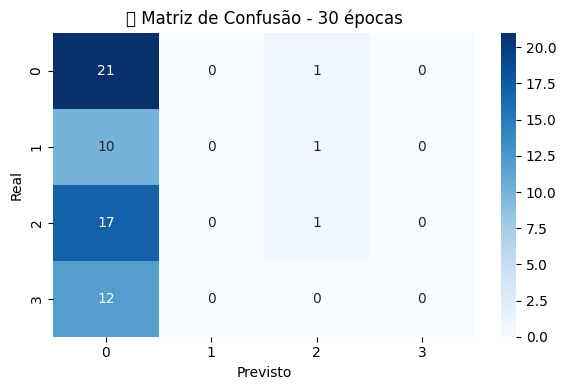


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=173.7780 | Accuracy=0.27
📚 Época 2/50: Loss=172.6921 | Accuracy=0.30
📚 Época 3/50: Loss=172.1203 | Accuracy=0.35
📚 Época 4/50: Loss=172.6608 | Accuracy=0.31
📚 Época 5/50: Loss=172.1877 | Accuracy=0.37
📚 Época 6/50: Loss=172.2963 | Accuracy=0.28
📚 Época 7/50: Loss=172.6275 | Accuracy=0.32
📚 Época 8/50: Loss=172.4174 | Accuracy=0.31
📚 Época 9/50: Loss=172.1863 | Accuracy=0.36
📚 Época 10/50: Loss=172.0011 | Accuracy=0.34
📚 Época 11/50: Loss=171.8949 | Accuracy=0.34
📚 Época 12/50: Loss=172.0322 | Accuracy=0.34
📚 Época 13/50: Loss=172.2078 | Accuracy=0.34
📚 Época 14/50: Loss=172.4476 | Accuracy=0.34
📚 Época 15/50: Loss=171.8188 | Accuracy=0.29
📚 Época 16/50: Loss=171.9994 | Accuracy=0.33
📚 Época 17/50: Loss=171.8589 | Accuracy=0.32
📚 Época 18/50: Loss=171.1600 | Accuracy=0.36
📚 Época 19/50: Loss=171.5073 | Accuracy=0.34
📚 Época 20/50: Loss=171.7792 | Accuracy=0.31
📚 Época 21/50: Loss=171.6572 | Accuracy=0.36
📚 Época 22/50: Loss=172.0209 | Acc

/tmp/ipykernel_24827/1597482163.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


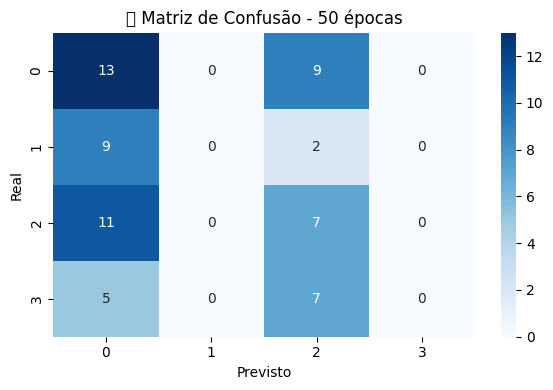

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [5, 10, 15, 20, 30, 50]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model = CNN2D_Simples().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 5 épocas...
📚 Época 1/5: Loss=173.8108 | Accuracy=0.27
📚 Época 2/5: Loss=172.9064 | Accuracy=0.33
📚 Época 3/5: Loss=172.8093 | Accuracy=0.29
📚 Época 4/5: Loss=172.2958 | Accuracy=0.35
📚 Época 5/5: Loss=172.4263 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.41      0.82      0.55        22
           1       0.00      0.00      0.00        11
           2       0.37      0.39      0.38        18
           3       0.00      0.00      0.00        12

    accuracy                           0.40        63
   macro avg       0.19      0.30      0.23        63
weighted avg       0.25      0.40      0.30        63

🔢 F1 Macro: 0.23095823095823095


/tmp/ipykernel_24827/2890658995.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


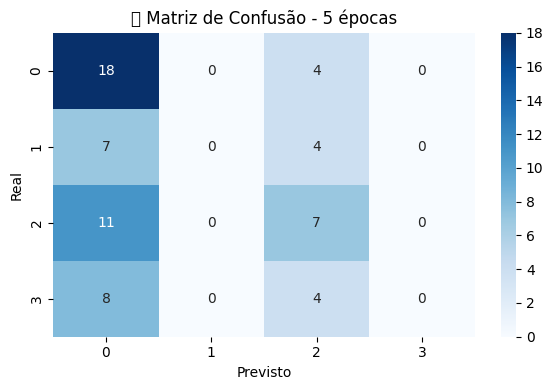


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=174.1051 | Accuracy=0.22
📚 Época 2/10: Loss=172.4001 | Accuracy=0.35
📚 Época 3/10: Loss=172.4517 | Accuracy=0.29
📚 Época 4/10: Loss=172.6665 | Accuracy=0.35
📚 Época 5/10: Loss=172.7368 | Accuracy=0.31
📚 Época 6/10: Loss=172.4924 | Accuracy=0.35
📚 Época 7/10: Loss=172.0041 | Accuracy=0.35
📚 Época 8/10: Loss=171.9620 | Accuracy=0.29
📚 Época 9/10: Loss=172.3574 | Accuracy=0.35
📚 Época 10/10: Loss=171.7433 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        12

    accuracy                           0.35        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.12      0.35      0.18        63

🔢 F1 Macro: 0.12941176470588237


/tmp/ipykernel_24827/2890658995.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


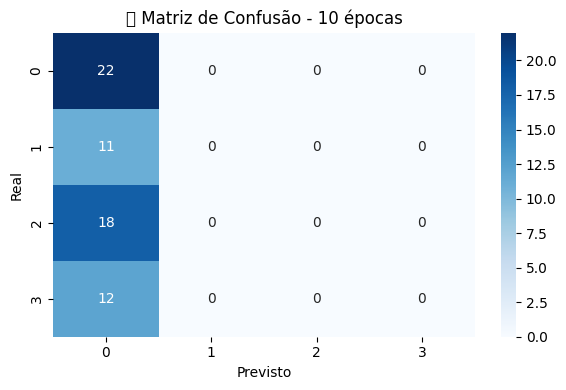


🔁 Treinando por 15 épocas...
📚 Época 1/15: Loss=173.6559 | Accuracy=0.26
📚 Época 2/15: Loss=172.3275 | Accuracy=0.35
📚 Época 3/15: Loss=172.3124 | Accuracy=0.35
📚 Época 4/15: Loss=172.2601 | Accuracy=0.32
📚 Época 5/15: Loss=172.2527 | Accuracy=0.35
📚 Época 6/15: Loss=172.1852 | Accuracy=0.35
📚 Época 7/15: Loss=171.8334 | Accuracy=0.35
📚 Época 8/15: Loss=171.9621 | Accuracy=0.35
📚 Época 9/15: Loss=171.9176 | Accuracy=0.35
📚 Época 10/15: Loss=172.6205 | Accuracy=0.35
📚 Época 11/15: Loss=171.6865 | Accuracy=0.35
📚 Época 12/15: Loss=171.4347 | Accuracy=0.35
📚 Época 13/15: Loss=172.1011 | Accuracy=0.35
📚 Época 14/15: Loss=171.9690 | Accuracy=0.35
📚 Época 15/15: Loss=172.1240 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        12

    accuracy      

/tmp/ipykernel_24827/2890658995.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


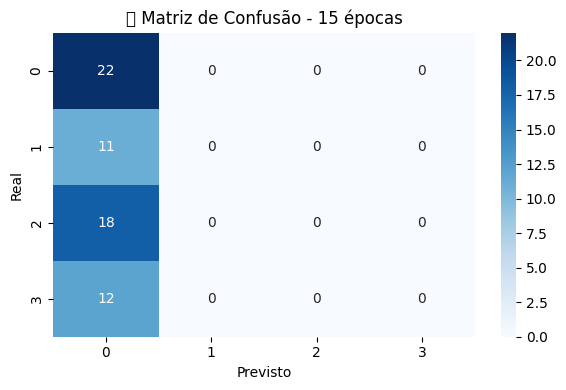


🔁 Treinando por 20 épocas...
📚 Época 1/20: Loss=173.9134 | Accuracy=0.22
📚 Época 2/20: Loss=172.8554 | Accuracy=0.32
📚 Época 3/20: Loss=172.3804 | Accuracy=0.30
📚 Época 4/20: Loss=172.1212 | Accuracy=0.35
📚 Época 5/20: Loss=172.4856 | Accuracy=0.35
📚 Época 6/20: Loss=172.5670 | Accuracy=0.35
📚 Época 7/20: Loss=172.1901 | Accuracy=0.35
📚 Época 8/20: Loss=172.4932 | Accuracy=0.32
📚 Época 9/20: Loss=172.5480 | Accuracy=0.35
📚 Época 10/20: Loss=172.0675 | Accuracy=0.35
📚 Época 11/20: Loss=172.4702 | Accuracy=0.35
📚 Época 12/20: Loss=172.2862 | Accuracy=0.35
📚 Época 13/20: Loss=172.7053 | Accuracy=0.34
📚 Época 14/20: Loss=172.2086 | Accuracy=0.33
📚 Época 15/20: Loss=172.0598 | Accuracy=0.33
📚 Época 16/20: Loss=172.2937 | Accuracy=0.35
📚 Época 17/20: Loss=171.9103 | Accuracy=0.35
📚 Época 18/20: Loss=172.1161 | Accuracy=0.34
📚 Época 19/20: Loss=171.8591 | Accuracy=0.35
📚 Época 20/20: Loss=171.7293 | Accuracy=0.36

📊 Relatório:
              precision    recall  f1-score   support

          

/tmp/ipykernel_24827/2890658995.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


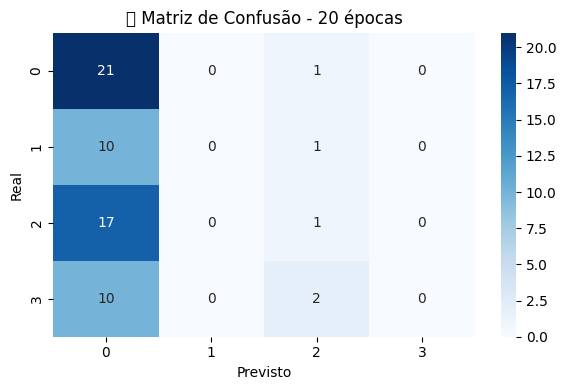


🔁 Treinando por 30 épocas...
📚 Época 1/30: Loss=173.6504 | Accuracy=0.24
📚 Época 2/30: Loss=173.0028 | Accuracy=0.31
📚 Época 3/30: Loss=171.9075 | Accuracy=0.35
📚 Época 4/30: Loss=172.3826 | Accuracy=0.36
📚 Época 5/30: Loss=172.0911 | Accuracy=0.32
📚 Época 6/30: Loss=171.8610 | Accuracy=0.32
📚 Época 7/30: Loss=172.2914 | Accuracy=0.33
📚 Época 8/30: Loss=171.9820 | Accuracy=0.28
📚 Época 9/30: Loss=172.0514 | Accuracy=0.34
📚 Época 10/30: Loss=171.9818 | Accuracy=0.31
📚 Época 11/30: Loss=171.9824 | Accuracy=0.33
📚 Época 12/30: Loss=172.0852 | Accuracy=0.35
📚 Época 13/30: Loss=172.0603 | Accuracy=0.30
📚 Época 14/30: Loss=171.9611 | Accuracy=0.35
📚 Época 15/30: Loss=172.0622 | Accuracy=0.33
📚 Época 16/30: Loss=171.9655 | Accuracy=0.35
📚 Época 17/30: Loss=171.7141 | Accuracy=0.36
📚 Época 18/30: Loss=171.9126 | Accuracy=0.33
📚 Época 19/30: Loss=171.7755 | Accuracy=0.37
📚 Época 20/30: Loss=171.4025 | Accuracy=0.36
📚 Época 21/30: Loss=172.2417 | Accuracy=0.32
📚 Época 22/30: Loss=171.7635 | Acc

/tmp/ipykernel_24827/2890658995.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


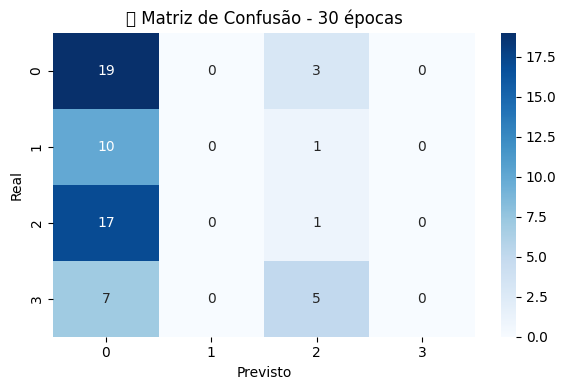


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=173.4886 | Accuracy=0.32
📚 Época 2/50: Loss=172.4257 | Accuracy=0.35
📚 Época 3/50: Loss=172.3480 | Accuracy=0.35
📚 Época 4/50: Loss=172.5974 | Accuracy=0.35
📚 Época 5/50: Loss=172.3130 | Accuracy=0.34
📚 Época 6/50: Loss=172.3263 | Accuracy=0.35
📚 Época 7/50: Loss=171.9838 | Accuracy=0.35
📚 Época 8/50: Loss=172.1031 | Accuracy=0.35
📚 Época 9/50: Loss=172.0685 | Accuracy=0.34
📚 Época 10/50: Loss=171.9008 | Accuracy=0.35
📚 Época 11/50: Loss=172.0896 | Accuracy=0.35
📚 Época 12/50: Loss=171.4794 | Accuracy=0.35
📚 Época 13/50: Loss=171.9454 | Accuracy=0.35
📚 Época 14/50: Loss=171.8996 | Accuracy=0.35
📚 Época 15/50: Loss=172.0349 | Accuracy=0.35
📚 Época 16/50: Loss=171.4834 | Accuracy=0.35
📚 Época 17/50: Loss=171.6103 | Accuracy=0.35
📚 Época 18/50: Loss=171.5274 | Accuracy=0.35
📚 Época 19/50: Loss=171.3868 | Accuracy=0.36
📚 Época 20/50: Loss=171.2096 | Accuracy=0.38
📚 Época 21/50: Loss=171.8652 | Accuracy=0.33
📚 Época 22/50: Loss=171.6836 | Acc

/tmp/ipykernel_24827/2890658995.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


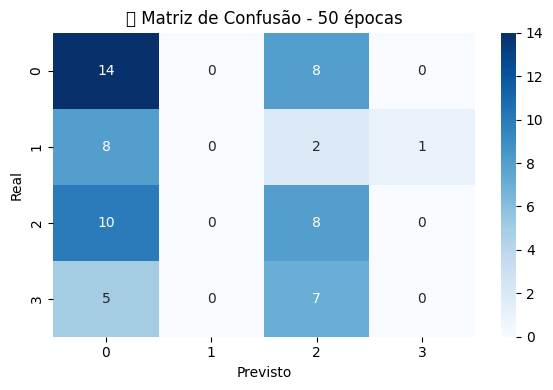

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [5, 10, 15, 20, 30, 50]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model = CNN2D_Dropout().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=172.9256 | Accuracy=0.32
📚 Época 2/75: Loss=172.1592 | Accuracy=0.31
📚 Época 3/75: Loss=172.2536 | Accuracy=0.32
📚 Época 4/75: Loss=172.3473 | Accuracy=0.34
📚 Época 5/75: Loss=172.2634 | Accuracy=0.35
📚 Época 6/75: Loss=171.7490 | Accuracy=0.35
📚 Época 7/75: Loss=172.3371 | Accuracy=0.35
📚 Época 8/75: Loss=172.0957 | Accuracy=0.35
📚 Época 9/75: Loss=171.8658 | Accuracy=0.33
📚 Época 10/75: Loss=171.9347 | Accuracy=0.34
📚 Época 11/75: Loss=171.9765 | Accuracy=0.33
📚 Época 12/75: Loss=172.2320 | Accuracy=0.35
📚 Época 13/75: Loss=171.8560 | Accuracy=0.35
📚 Época 14/75: Loss=172.2025 | Accuracy=0.34
📚 Época 15/75: Loss=172.0420 | Accuracy=0.34
📚 Época 16/75: Loss=171.6054 | Accuracy=0.33
📚 Época 17/75: Loss=171.9308 | Accuracy=0.35
📚 Época 18/75: Loss=171.7148 | Accuracy=0.36
📚 Época 19/75: Loss=171.4842 | Accuracy=0.35
📚 Época 20/75: Loss=171.3880 | Accuracy=0.35
📚 Época 21/75: Loss=171.3458 | Accuracy=0.35
📚 Época 22/75: Loss=171.6149 | Acc

/tmp/ipykernel_24827/252406676.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


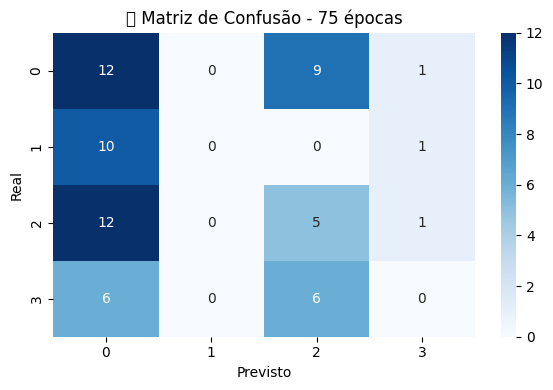

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [75]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model = CNN2D_Dropout().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 5 épocas...
📚 Época 1/5: Loss=174.7274 | Accuracy=0.27
📚 Época 2/5: Loss=172.9851 | Accuracy=0.30
📚 Época 3/5: Loss=172.9178 | Accuracy=0.33
📚 Época 4/5: Loss=173.0206 | Accuracy=0.34
📚 Época 5/5: Loss=172.4283 | Accuracy=0.31

📊 Relatório:
              precision    recall  f1-score   support

           0       0.11      0.05      0.06        22
           1       0.00      0.00      0.00        11
           2       0.30      0.89      0.44        18
           3       0.00      0.00      0.00        12

    accuracy                           0.27        63
   macro avg       0.10      0.23      0.13        63
weighted avg       0.12      0.27      0.15        63

🔢 F1 Macro: 0.1272401433691756


/tmp/ipykernel_24827/2720284602.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


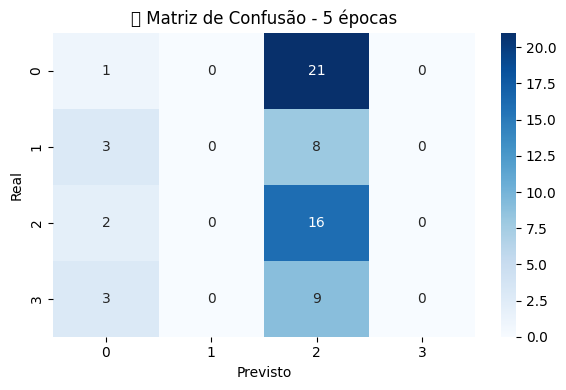


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=175.7301 | Accuracy=0.32
📚 Época 2/10: Loss=172.9894 | Accuracy=0.34
📚 Época 3/10: Loss=172.4571 | Accuracy=0.35
📚 Época 4/10: Loss=172.3080 | Accuracy=0.35
📚 Época 5/10: Loss=171.9368 | Accuracy=0.34
📚 Época 6/10: Loss=172.5463 | Accuracy=0.32
📚 Época 7/10: Loss=172.6072 | Accuracy=0.35
📚 Época 8/10: Loss=171.7760 | Accuracy=0.35
📚 Época 9/10: Loss=172.1154 | Accuracy=0.33
📚 Época 10/10: Loss=171.9457 | Accuracy=0.34

📊 Relatório:
              precision    recall  f1-score   support

           0       0.23      0.32      0.26        22
           1       0.00      0.00      0.00        11
           2       0.19      0.33      0.24        18
           3       0.00      0.00      0.00        12

    accuracy                           0.21        63
   macro avg       0.10      0.16      0.13        63
weighted avg       0.13      0.21      0.16        63

🔢 F1 Macro: 0.1260377358490566


/tmp/ipykernel_24827/2720284602.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


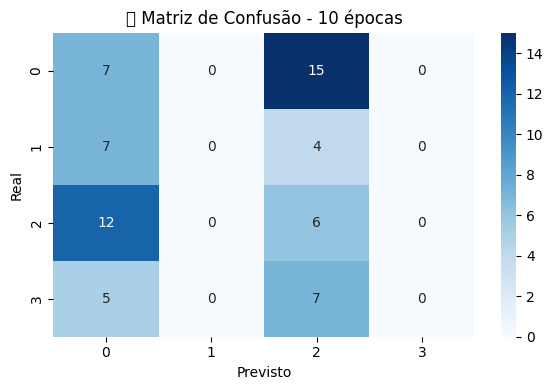


🔁 Treinando por 15 épocas...
📚 Época 1/15: Loss=176.6876 | Accuracy=0.21
📚 Época 2/15: Loss=173.1913 | Accuracy=0.29
📚 Época 3/15: Loss=172.8427 | Accuracy=0.30
📚 Época 4/15: Loss=172.4995 | Accuracy=0.34
📚 Época 5/15: Loss=172.4245 | Accuracy=0.33
📚 Época 6/15: Loss=171.8826 | Accuracy=0.34
📚 Época 7/15: Loss=171.9746 | Accuracy=0.35
📚 Época 8/15: Loss=172.6108 | Accuracy=0.32
📚 Época 9/15: Loss=171.9515 | Accuracy=0.35
📚 Época 10/15: Loss=171.9075 | Accuracy=0.34
📚 Época 11/15: Loss=172.4692 | Accuracy=0.33
📚 Época 12/15: Loss=172.4740 | Accuracy=0.34
📚 Época 13/15: Loss=171.8309 | Accuracy=0.37
📚 Época 14/15: Loss=171.7401 | Accuracy=0.35
📚 Época 15/15: Loss=171.5036 | Accuracy=0.37

📊 Relatório:
              precision    recall  f1-score   support

           0       0.40      0.77      0.53        22
           1       0.00      0.00      0.00        11
           2       0.38      0.44      0.41        18
           3       0.00      0.00      0.00        12

    accuracy      

/tmp/ipykernel_24827/2720284602.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


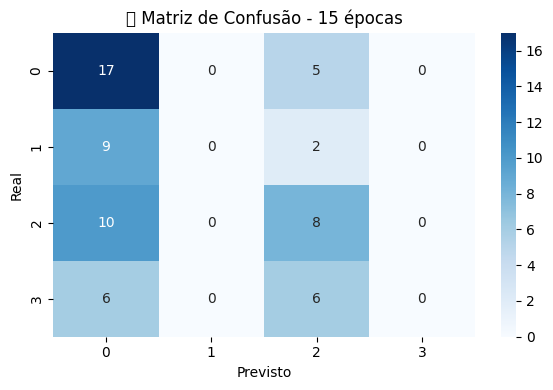


🔁 Treinando por 20 épocas...
📚 Época 1/20: Loss=177.1137 | Accuracy=0.24
📚 Época 2/20: Loss=173.1632 | Accuracy=0.31
📚 Época 3/20: Loss=172.2833 | Accuracy=0.34
📚 Época 4/20: Loss=172.7052 | Accuracy=0.34
📚 Época 5/20: Loss=172.2949 | Accuracy=0.32
📚 Época 6/20: Loss=172.1251 | Accuracy=0.35
📚 Época 7/20: Loss=170.9491 | Accuracy=0.33
📚 Época 8/20: Loss=172.5012 | Accuracy=0.33
📚 Época 9/20: Loss=172.1455 | Accuracy=0.36
📚 Época 10/20: Loss=171.0772 | Accuracy=0.38
📚 Época 11/20: Loss=171.9566 | Accuracy=0.34
📚 Época 12/20: Loss=170.9491 | Accuracy=0.36
📚 Época 13/20: Loss=171.6175 | Accuracy=0.37
📚 Época 14/20: Loss=171.5295 | Accuracy=0.36
📚 Época 15/20: Loss=170.4048 | Accuracy=0.36
📚 Época 16/20: Loss=170.5219 | Accuracy=0.37
📚 Época 17/20: Loss=171.3232 | Accuracy=0.35
📚 Época 18/20: Loss=170.0160 | Accuracy=0.37
📚 Época 19/20: Loss=170.6885 | Accuracy=0.35
📚 Época 20/20: Loss=170.4024 | Accuracy=0.39

📊 Relatório:
              precision    recall  f1-score   support

          

/tmp/ipykernel_24827/2720284602.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


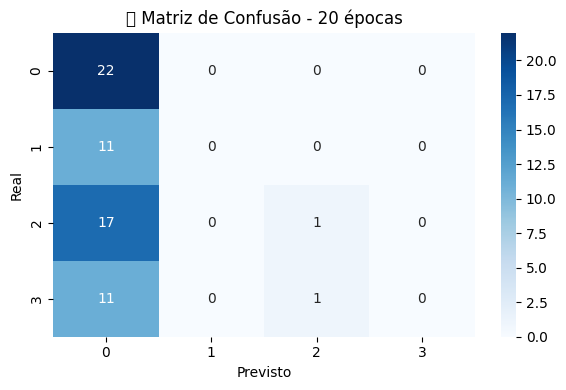


🔁 Treinando por 30 épocas...
📚 Época 1/30: Loss=175.5360 | Accuracy=0.30
📚 Época 2/30: Loss=172.7130 | Accuracy=0.34
📚 Época 3/30: Loss=173.1889 | Accuracy=0.34
📚 Época 4/30: Loss=172.3171 | Accuracy=0.35
📚 Época 5/30: Loss=172.3794 | Accuracy=0.33
📚 Época 6/30: Loss=172.1505 | Accuracy=0.33
📚 Época 7/30: Loss=172.7616 | Accuracy=0.34
📚 Época 8/30: Loss=171.9407 | Accuracy=0.34
📚 Época 9/30: Loss=172.2793 | Accuracy=0.34
📚 Época 10/30: Loss=171.9448 | Accuracy=0.37
📚 Época 11/30: Loss=171.6175 | Accuracy=0.35
📚 Época 12/30: Loss=171.9272 | Accuracy=0.37
📚 Época 13/30: Loss=171.3039 | Accuracy=0.36
📚 Época 14/30: Loss=171.0470 | Accuracy=0.38
📚 Época 15/30: Loss=171.1152 | Accuracy=0.37
📚 Época 16/30: Loss=171.3366 | Accuracy=0.35
📚 Época 17/30: Loss=171.5280 | Accuracy=0.36
📚 Época 18/30: Loss=171.0141 | Accuracy=0.35
📚 Época 19/30: Loss=170.4480 | Accuracy=0.35
📚 Época 20/30: Loss=170.0748 | Accuracy=0.38
📚 Época 21/30: Loss=169.4043 | Accuracy=0.37
📚 Época 22/30: Loss=170.3947 | Acc

/tmp/ipykernel_24827/2720284602.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


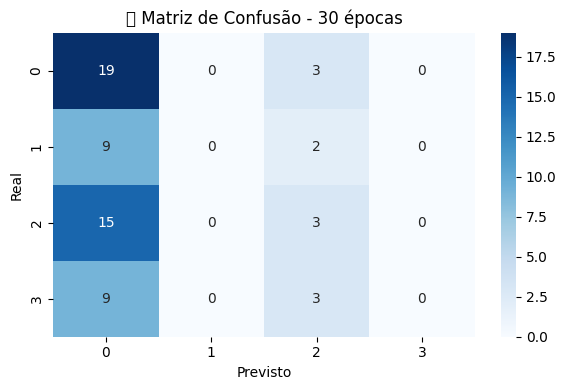


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=174.9959 | Accuracy=0.27
📚 Época 2/50: Loss=173.0425 | Accuracy=0.29
📚 Época 3/50: Loss=172.5197 | Accuracy=0.33
📚 Época 4/50: Loss=172.4987 | Accuracy=0.35
📚 Época 5/50: Loss=171.9821 | Accuracy=0.33
📚 Época 6/50: Loss=172.4930 | Accuracy=0.35
📚 Época 7/50: Loss=172.0240 | Accuracy=0.31
📚 Época 8/50: Loss=171.2935 | Accuracy=0.32
📚 Época 9/50: Loss=172.0145 | Accuracy=0.35
📚 Época 10/50: Loss=171.7688 | Accuracy=0.34
📚 Época 11/50: Loss=172.2491 | Accuracy=0.34
📚 Época 12/50: Loss=171.8189 | Accuracy=0.35
📚 Época 13/50: Loss=171.6596 | Accuracy=0.33
📚 Época 14/50: Loss=171.8655 | Accuracy=0.35
📚 Época 15/50: Loss=171.4348 | Accuracy=0.36
📚 Época 16/50: Loss=171.5384 | Accuracy=0.35
📚 Época 17/50: Loss=170.9479 | Accuracy=0.36
📚 Época 18/50: Loss=170.9256 | Accuracy=0.37
📚 Época 19/50: Loss=171.3699 | Accuracy=0.35
📚 Época 20/50: Loss=171.2464 | Accuracy=0.35
📚 Época 21/50: Loss=171.0781 | Accuracy=0.37
📚 Época 22/50: Loss=170.3761 | Acc

/tmp/ipykernel_24827/2720284602.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


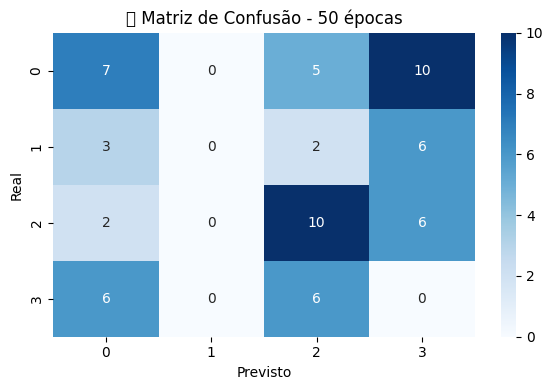


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=175.8718 | Accuracy=0.27
📚 Época 2/75: Loss=172.7533 | Accuracy=0.33
📚 Época 3/75: Loss=172.8679 | Accuracy=0.34
📚 Época 4/75: Loss=172.9694 | Accuracy=0.35
📚 Época 5/75: Loss=172.1563 | Accuracy=0.35
📚 Época 6/75: Loss=172.5427 | Accuracy=0.35
📚 Época 7/75: Loss=172.6447 | Accuracy=0.31
📚 Época 8/75: Loss=172.4631 | Accuracy=0.35
📚 Época 9/75: Loss=172.7934 | Accuracy=0.32
📚 Época 10/75: Loss=172.4052 | Accuracy=0.35
📚 Época 11/75: Loss=171.8961 | Accuracy=0.35
📚 Época 12/75: Loss=172.0819 | Accuracy=0.33
📚 Época 13/75: Loss=172.2045 | Accuracy=0.35
📚 Época 14/75: Loss=172.0083 | Accuracy=0.34
📚 Época 15/75: Loss=171.8153 | Accuracy=0.35
📚 Época 16/75: Loss=171.0864 | Accuracy=0.35
📚 Época 17/75: Loss=171.4452 | Accuracy=0.35
📚 Época 18/75: Loss=170.6507 | Accuracy=0.34
📚 Época 19/75: Loss=170.7477 | Accuracy=0.34
📚 Época 20/75: Loss=170.9833 | Accuracy=0.34
📚 Época 21/75: Loss=170.3045 | Accuracy=0.37
📚 Época 22/75: Loss=170.1972 | Acc

/tmp/ipykernel_24827/2720284602.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


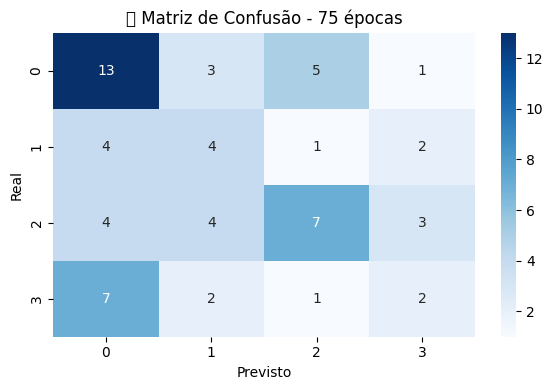

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [5, 10, 15, 20, 30,50,75]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_Profundo().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 100 épocas...
📚 Época 1/100: Loss=175.5256 | Accuracy=0.29
📚 Época 2/100: Loss=173.5992 | Accuracy=0.29
📚 Época 3/100: Loss=172.6433 | Accuracy=0.29
📚 Época 4/100: Loss=172.5727 | Accuracy=0.30
📚 Época 5/100: Loss=172.3649 | Accuracy=0.31
📚 Época 6/100: Loss=171.8746 | Accuracy=0.30
📚 Época 7/100: Loss=172.2623 | Accuracy=0.29
📚 Época 8/100: Loss=172.1401 | Accuracy=0.27
📚 Época 9/100: Loss=171.8815 | Accuracy=0.35
📚 Época 10/100: Loss=171.8572 | Accuracy=0.35
📚 Época 11/100: Loss=172.0593 | Accuracy=0.34
📚 Época 12/100: Loss=171.7520 | Accuracy=0.35
📚 Época 13/100: Loss=171.8880 | Accuracy=0.33
📚 Época 14/100: Loss=171.7933 | Accuracy=0.36
📚 Época 15/100: Loss=171.6865 | Accuracy=0.34
📚 Época 16/100: Loss=171.5703 | Accuracy=0.35
📚 Época 17/100: Loss=171.5365 | Accuracy=0.37
📚 Época 18/100: Loss=171.4046 | Accuracy=0.35
📚 Época 19/100: Loss=171.4315 | Accuracy=0.40
📚 Época 20/100: Loss=171.2041 | Accuracy=0.35
📚 Época 21/100: Loss=170.9682 | Accuracy=0.37
📚 Época 22/1

/tmp/ipykernel_24827/1019928037.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


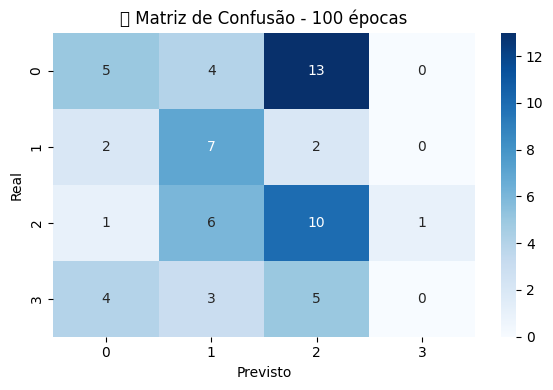

In [48]:
 from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [100]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_Profundo().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=172.2778 | Accuracy=0.25
📚 Época 2/10: Loss=172.5181 | Accuracy=0.31
📚 Época 3/10: Loss=171.9438 | Accuracy=0.35
📚 Época 4/10: Loss=172.6616 | Accuracy=0.31
📚 Época 5/10: Loss=172.0188 | Accuracy=0.35
📚 Época 6/10: Loss=172.1750 | Accuracy=0.34
📚 Época 7/10: Loss=171.7594 | Accuracy=0.35
📚 Época 8/10: Loss=172.0556 | Accuracy=0.35
📚 Época 9/10: Loss=171.7030 | Accuracy=0.33
📚 Época 10/10: Loss=172.1080 | Accuracy=0.35

📊 Relatório:
              precision    recall  f1-score   support

           0       0.36      0.86      0.51        22
           1       0.00      0.00      0.00        11
           2       0.10      0.06      0.07        18
           3       0.00      0.00      0.00        12

    accuracy                           0.32        63
   macro avg       0.11      0.23      0.14        63
weighted avg       0.15      0.32      0.20        63

🔢 F1 Macro: 0.14452380952380953


/tmp/ipykernel_24827/843488482.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


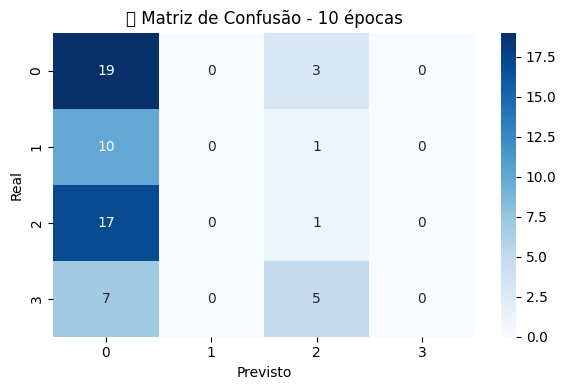


🔁 Treinando por 25 épocas...
📚 Época 1/25: Loss=173.4842 | Accuracy=0.30
📚 Época 2/25: Loss=172.2713 | Accuracy=0.34
📚 Época 3/25: Loss=172.5749 | Accuracy=0.35
📚 Época 4/25: Loss=172.1311 | Accuracy=0.31
📚 Época 5/25: Loss=172.5590 | Accuracy=0.35
📚 Época 6/25: Loss=172.0623 | Accuracy=0.35
📚 Época 7/25: Loss=172.4370 | Accuracy=0.35
📚 Época 8/25: Loss=172.1135 | Accuracy=0.30
📚 Época 9/25: Loss=172.2076 | Accuracy=0.35
📚 Época 10/25: Loss=172.3532 | Accuracy=0.34
📚 Época 11/25: Loss=171.5458 | Accuracy=0.34
📚 Época 12/25: Loss=172.0433 | Accuracy=0.35
📚 Época 13/25: Loss=171.8274 | Accuracy=0.32
📚 Época 14/25: Loss=172.0468 | Accuracy=0.35
📚 Época 15/25: Loss=172.2023 | Accuracy=0.35
📚 Época 16/25: Loss=171.9951 | Accuracy=0.35
📚 Época 17/25: Loss=172.8633 | Accuracy=0.35
📚 Época 18/25: Loss=171.9577 | Accuracy=0.34
📚 Época 19/25: Loss=172.1597 | Accuracy=0.33
📚 Época 20/25: Loss=171.9598 | Accuracy=0.34
📚 Época 21/25: Loss=172.1973 | Accuracy=0.30
📚 Época 22/25: Loss=172.3954 | Acc

/tmp/ipykernel_24827/843488482.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


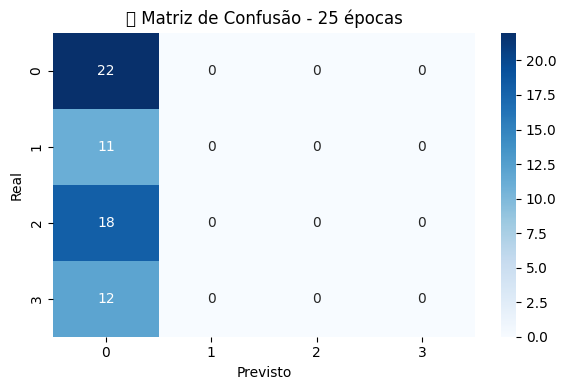


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=172.6280 | Accuracy=0.31
📚 Época 2/50: Loss=172.5259 | Accuracy=0.35
📚 Época 3/50: Loss=172.5188 | Accuracy=0.35
📚 Época 4/50: Loss=171.6633 | Accuracy=0.35
📚 Época 5/50: Loss=172.2168 | Accuracy=0.36
📚 Época 6/50: Loss=172.0818 | Accuracy=0.34
📚 Época 7/50: Loss=172.1211 | Accuracy=0.37
📚 Época 8/50: Loss=172.4827 | Accuracy=0.35
📚 Época 9/50: Loss=171.6690 | Accuracy=0.35
📚 Época 10/50: Loss=171.9996 | Accuracy=0.36
📚 Época 11/50: Loss=170.8311 | Accuracy=0.37
📚 Época 12/50: Loss=171.4614 | Accuracy=0.36
📚 Época 13/50: Loss=171.6287 | Accuracy=0.35
📚 Época 14/50: Loss=171.2345 | Accuracy=0.38
📚 Época 15/50: Loss=170.8476 | Accuracy=0.37
📚 Época 16/50: Loss=171.1963 | Accuracy=0.36
📚 Época 17/50: Loss=170.9513 | Accuracy=0.35
📚 Época 18/50: Loss=170.5615 | Accuracy=0.37
📚 Época 19/50: Loss=171.7026 | Accuracy=0.37
📚 Época 20/50: Loss=171.3069 | Accuracy=0.36
📚 Época 21/50: Loss=170.6412 | Accuracy=0.37
📚 Época 22/50: Loss=171.1706 | Acc

/tmp/ipykernel_24827/843488482.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


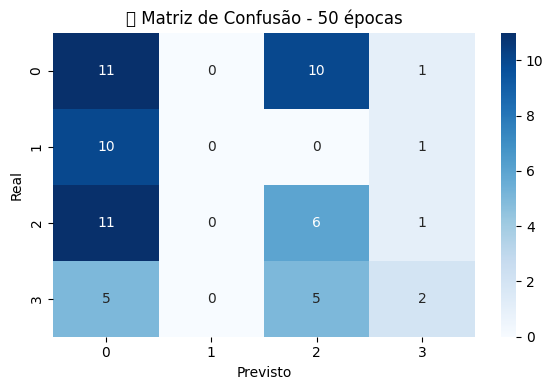


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=173.2233 | Accuracy=0.30
📚 Época 2/75: Loss=172.3959 | Accuracy=0.30
📚 Época 3/75: Loss=172.2603 | Accuracy=0.32
📚 Época 4/75: Loss=172.2253 | Accuracy=0.35
📚 Época 5/75: Loss=172.0140 | Accuracy=0.33
📚 Época 6/75: Loss=172.8632 | Accuracy=0.33
📚 Época 7/75: Loss=172.2305 | Accuracy=0.33
📚 Época 8/75: Loss=171.9600 | Accuracy=0.35
📚 Época 9/75: Loss=172.2842 | Accuracy=0.35
📚 Época 10/75: Loss=172.0849 | Accuracy=0.35
📚 Época 11/75: Loss=171.9687 | Accuracy=0.35
📚 Época 12/75: Loss=171.9386 | Accuracy=0.35
📚 Época 13/75: Loss=171.9923 | Accuracy=0.35
📚 Época 14/75: Loss=171.6222 | Accuracy=0.31
📚 Época 15/75: Loss=171.9931 | Accuracy=0.32
📚 Época 16/75: Loss=171.6521 | Accuracy=0.34
📚 Época 17/75: Loss=172.3810 | Accuracy=0.37
📚 Época 18/75: Loss=171.8538 | Accuracy=0.36
📚 Época 19/75: Loss=171.7766 | Accuracy=0.36
📚 Época 20/75: Loss=171.7349 | Accuracy=0.37
📚 Época 21/75: Loss=171.4441 | Accuracy=0.39
📚 Época 22/75: Loss=171.2305 | Acc

/tmp/ipykernel_24827/843488482.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


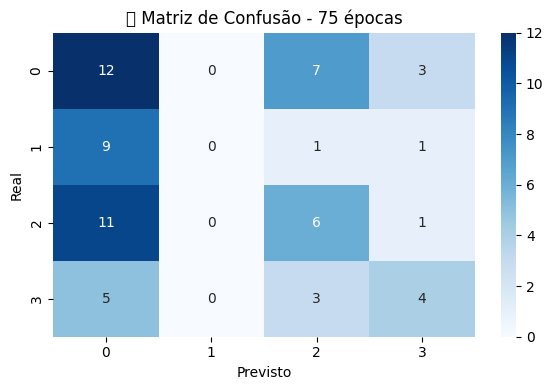


🔁 Treinando por 100 épocas...
📚 Época 1/100: Loss=174.3612 | Accuracy=0.30
📚 Época 2/100: Loss=173.2360 | Accuracy=0.27
📚 Época 3/100: Loss=172.1727 | Accuracy=0.31
📚 Época 4/100: Loss=172.2146 | Accuracy=0.35
📚 Época 5/100: Loss=172.0573 | Accuracy=0.32
📚 Época 6/100: Loss=172.4519 | Accuracy=0.35
📚 Época 7/100: Loss=172.1149 | Accuracy=0.32
📚 Época 8/100: Loss=172.4373 | Accuracy=0.35
📚 Época 9/100: Loss=172.1398 | Accuracy=0.33
📚 Época 10/100: Loss=171.8838 | Accuracy=0.35
📚 Época 11/100: Loss=171.9946 | Accuracy=0.35
📚 Época 12/100: Loss=172.3770 | Accuracy=0.35
📚 Época 13/100: Loss=171.4395 | Accuracy=0.36
📚 Época 14/100: Loss=171.4900 | Accuracy=0.35
📚 Época 15/100: Loss=172.1153 | Accuracy=0.34
📚 Época 16/100: Loss=171.3661 | Accuracy=0.35
📚 Época 17/100: Loss=171.5083 | Accuracy=0.37
📚 Época 18/100: Loss=171.8930 | Accuracy=0.36
📚 Época 19/100: Loss=170.8631 | Accuracy=0.37
📚 Época 20/100: Loss=170.9077 | Accuracy=0.31
📚 Época 21/100: Loss=170.8345 | Accuracy=0.35
📚 Época 22/1

/tmp/ipykernel_24827/843488482.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


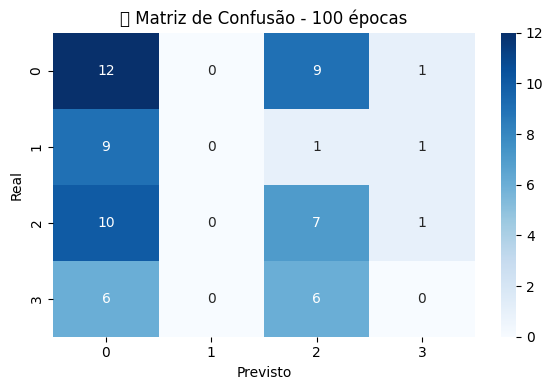

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [10,25,50,75,100]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_ResBlock().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=173.3052 | Accuracy=0.29
📚 Época 2/10: Loss=172.6205 | Accuracy=0.31
📚 Época 3/10: Loss=172.2475 | Accuracy=0.33
📚 Época 4/10: Loss=172.0527 | Accuracy=0.35
📚 Época 5/10: Loss=172.3815 | Accuracy=0.35
📚 Época 6/10: Loss=171.7570 | Accuracy=0.34
📚 Época 7/10: Loss=171.8994 | Accuracy=0.33
📚 Época 8/10: Loss=172.3054 | Accuracy=0.34
📚 Época 9/10: Loss=171.8999 | Accuracy=0.35
📚 Época 10/10: Loss=171.9065 | Accuracy=0.34

📊 Relatório:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        12

    accuracy                           0.35        63
   macro avg       0.09      0.25      0.13        63
weighted avg       0.12      0.35      0.18        63

🔢 F1 Macro: 0.13095238095238096


/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


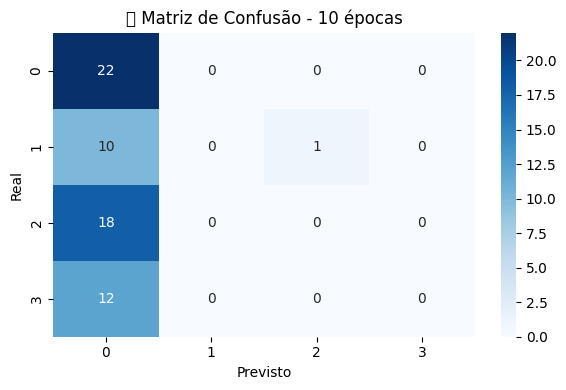


🔁 Treinando por 25 épocas...
📚 Época 1/25: Loss=173.6185 | Accuracy=0.29
📚 Época 2/25: Loss=172.6091 | Accuracy=0.29
📚 Época 3/25: Loss=172.5838 | Accuracy=0.29
📚 Época 4/25: Loss=171.9470 | Accuracy=0.30
📚 Época 5/25: Loss=171.9400 | Accuracy=0.35
📚 Época 6/25: Loss=172.1401 | Accuracy=0.35
📚 Época 7/25: Loss=172.3364 | Accuracy=0.34
📚 Época 8/25: Loss=172.1904 | Accuracy=0.34
📚 Época 9/25: Loss=171.8050 | Accuracy=0.35
📚 Época 10/25: Loss=171.7113 | Accuracy=0.34
📚 Época 11/25: Loss=172.0764 | Accuracy=0.35
📚 Época 12/25: Loss=172.0033 | Accuracy=0.35
📚 Época 13/25: Loss=171.8470 | Accuracy=0.35
📚 Época 14/25: Loss=171.9621 | Accuracy=0.36
📚 Época 15/25: Loss=172.3791 | Accuracy=0.36
📚 Época 16/25: Loss=171.7209 | Accuracy=0.35
📚 Época 17/25: Loss=172.3501 | Accuracy=0.32
📚 Época 18/25: Loss=171.7716 | Accuracy=0.37
📚 Época 19/25: Loss=171.9098 | Accuracy=0.35
📚 Época 20/25: Loss=171.9115 | Accuracy=0.37
📚 Época 21/25: Loss=171.6358 | Accuracy=0.35
📚 Época 22/25: Loss=171.5659 | Acc

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


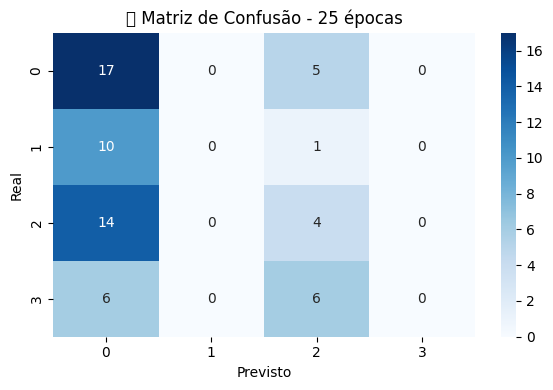


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=174.0939 | Accuracy=0.22
📚 Época 2/50: Loss=172.4111 | Accuracy=0.35
📚 Época 3/50: Loss=171.5637 | Accuracy=0.35
📚 Época 4/50: Loss=172.4990 | Accuracy=0.35
📚 Época 5/50: Loss=172.1157 | Accuracy=0.35
📚 Época 6/50: Loss=172.0614 | Accuracy=0.34
📚 Época 7/50: Loss=171.9949 | Accuracy=0.34
📚 Época 8/50: Loss=172.1005 | Accuracy=0.34
📚 Época 9/50: Loss=171.8264 | Accuracy=0.35
📚 Época 10/50: Loss=171.8516 | Accuracy=0.33
📚 Época 11/50: Loss=172.3613 | Accuracy=0.33
📚 Época 12/50: Loss=172.5315 | Accuracy=0.35
📚 Época 13/50: Loss=172.5246 | Accuracy=0.35
📚 Época 14/50: Loss=171.6742 | Accuracy=0.35
📚 Época 15/50: Loss=172.4865 | Accuracy=0.34
📚 Época 16/50: Loss=171.9966 | Accuracy=0.34
📚 Época 17/50: Loss=171.5099 | Accuracy=0.35
📚 Época 18/50: Loss=171.6474 | Accuracy=0.34
📚 Época 19/50: Loss=171.8232 | Accuracy=0.35
📚 Época 20/50: Loss=171.8726 | Accuracy=0.36
📚 Época 21/50: Loss=171.2730 | Accuracy=0.36
📚 Época 22/50: Loss=171.9418 | Acc

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


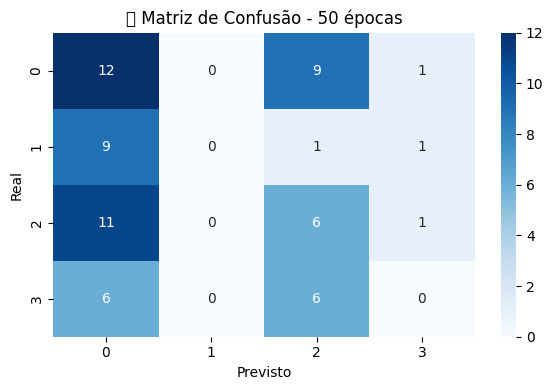


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=173.4626 | Accuracy=0.24
📚 Época 2/75: Loss=172.5655 | Accuracy=0.35
📚 Época 3/75: Loss=172.6988 | Accuracy=0.29
📚 Época 4/75: Loss=172.1779 | Accuracy=0.35
📚 Época 5/75: Loss=172.4334 | Accuracy=0.35
📚 Época 6/75: Loss=172.1123 | Accuracy=0.35
📚 Época 7/75: Loss=172.3079 | Accuracy=0.35
📚 Época 8/75: Loss=171.9134 | Accuracy=0.35
📚 Época 9/75: Loss=171.7370 | Accuracy=0.35
📚 Época 10/75: Loss=171.7924 | Accuracy=0.35
📚 Época 11/75: Loss=171.8929 | Accuracy=0.35
📚 Época 12/75: Loss=171.9941 | Accuracy=0.35
📚 Época 13/75: Loss=172.3170 | Accuracy=0.35
📚 Época 14/75: Loss=172.1466 | Accuracy=0.34
📚 Época 15/75: Loss=172.6202 | Accuracy=0.35
📚 Época 16/75: Loss=171.9217 | Accuracy=0.35
📚 Época 17/75: Loss=171.7399 | Accuracy=0.34
📚 Época 18/75: Loss=171.7451 | Accuracy=0.36
📚 Época 19/75: Loss=171.7769 | Accuracy=0.35
📚 Época 20/75: Loss=171.9249 | Accuracy=0.35
📚 Época 21/75: Loss=171.1645 | Accuracy=0.36
📚 Época 22/75: Loss=171.7671 | Acc

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


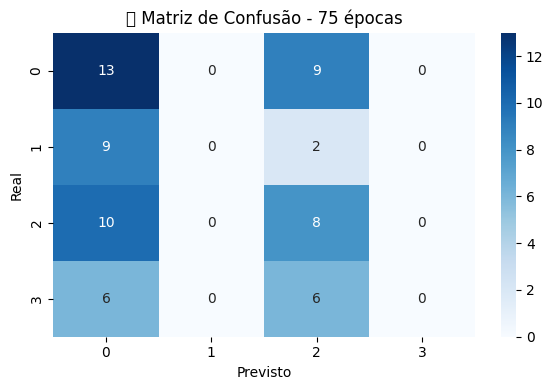


🔁 Treinando por 100 épocas...
📚 Época 1/100: Loss=173.9070 | Accuracy=0.27
📚 Época 2/100: Loss=171.9999 | Accuracy=0.31
📚 Época 3/100: Loss=172.6556 | Accuracy=0.35
📚 Época 4/100: Loss=172.7244 | Accuracy=0.35
📚 Época 5/100: Loss=172.3765 | Accuracy=0.35
📚 Época 6/100: Loss=172.7301 | Accuracy=0.35
📚 Época 7/100: Loss=172.9083 | Accuracy=0.32
📚 Época 8/100: Loss=172.3658 | Accuracy=0.31
📚 Época 9/100: Loss=172.4571 | Accuracy=0.35
📚 Época 10/100: Loss=172.2010 | Accuracy=0.33
📚 Época 11/100: Loss=171.9628 | Accuracy=0.31
📚 Época 12/100: Loss=172.2317 | Accuracy=0.35
📚 Época 13/100: Loss=172.1678 | Accuracy=0.35
📚 Época 14/100: Loss=172.3794 | Accuracy=0.35
📚 Época 15/100: Loss=172.2388 | Accuracy=0.35
📚 Época 16/100: Loss=172.2275 | Accuracy=0.35
📚 Época 17/100: Loss=172.2869 | Accuracy=0.35
📚 Época 18/100: Loss=172.2787 | Accuracy=0.35
📚 Época 19/100: Loss=172.4262 | Accuracy=0.31
📚 Época 20/100: Loss=172.1771 | Accuracy=0.35
📚 Época 21/100: Loss=171.8093 | Accuracy=0.35
📚 Época 22/1

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


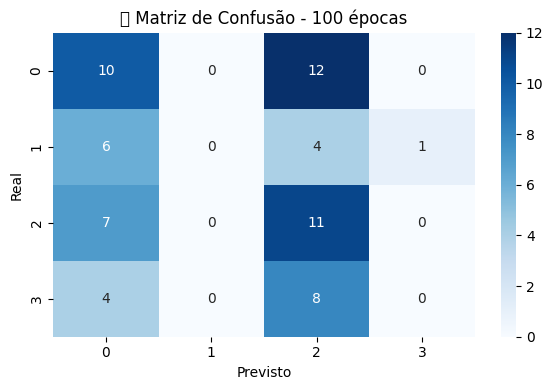

In [50]:

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [10,25,50,75,100]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_SEBlock().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

In [51]:
import os
import numpy as np
from collections import Counter

coluna = "OSATS_FINAL_QUALITY"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))

contador = Counter()

for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1  # Ajustar para intervalo 0–4
            contador[label] += 1
        except:
            continue

print(f"📊 Distribuição de classes em vídeos processados ({coluna}):")
for i in range(5):
    print(f" - Classe {i}: {contador[i]} vídeos")




📊 Distribuição de classes em vídeos processados (OSATS_FINAL_QUALITY):
 - Classe 0: 96 vídeos
 - Classe 1: 64 vídeos
 - Classe 2: 76 vídeos
 - Classe 3: 68 vídeos
 - Classe 4: 10 vídeos


In [52]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.utils.data import Dataset, DataLoader

# 📌 Parâmetros principais
coluna = "OSATS_FINAL_QUALITY"
diretorio = os.path.join("frames_task2", coluna)
videos = sorted(os.listdir(diretorio))
MAX_FRAMES = 1
BATCH_SIZE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Carregar vídeos válidos e respetivos labels (com classe 0–4)
dados = []
for v in videos:
    meta_path = os.path.join(diretorio, v, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            label = int(meta[coluna]) - 1
            dados.append((v, label))
        except:
            continue

videos_validos, labels_validos = zip(*dados)
videos_validos, labels_validos = list(videos_validos), list(labels_validos)

# 📊 Mostrar distribuição real
print(f"📦 Vídeos processados para {coluna}: {len(videos_validos)}")
print("\n📊 Distribuição real:")
for i in range(5):
    print(f" - Classe {i}: {labels_validos.count(i)} vídeos")

# 🔀 Dividir treino/teste
train_videos, test_videos, y_train, y_test = train_test_split(
    videos_validos, labels_validos, test_size=0.2, stratify=labels_validos, random_state=42
)

# ⚖️ Pesos para CrossEntropyLoss
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("\n⚖️ Pesos:", weights)

# 📦 Dataset para um único frame final
class FinalQualityDataset(torch.utils.data.Dataset):
    def __init__(self, video_ids, coluna):
        self.video_ids = video_ids
        self.coluna = coluna
        self.dir = os.path.join("frames_task2", coluna)

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        pasta = os.path.join(self.dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()
        label = int(meta[self.coluna]) - 1

        # Usar apenas o último frame
        frame = frames[-1].astype("float32") / 255.0
        frame = np.expand_dims(frame, axis=(0, 1))  # (1, 1, 224, 224)

        return torch.tensor(frame), torch.tensor(label)

# 🚀 Loaders
train_loader = DataLoader(FinalQualityDataset(train_videos, coluna), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(FinalQualityDataset(test_videos, coluna), batch_size=BATCH_SIZE)


📦 Vídeos processados para OSATS_FINAL_QUALITY: 314

📊 Distribuição real:
 - Classe 0: 96 vídeos
 - Classe 1: 64 vídeos
 - Classe 2: 76 vídeos
 - Classe 3: 68 vídeos
 - Classe 4: 10 vídeos

⚖️ Pesos: [0.65194805 0.98431373 0.82295082 0.92962963 6.275     ]



🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=197.5811 | Accuracy=0.22
📚 Época 2/10: Loss=193.8881 | Accuracy=0.31
📚 Época 3/10: Loss=191.8620 | Accuracy=0.31
📚 Época 4/10: Loss=193.6681 | Accuracy=0.31
📚 Época 5/10: Loss=192.1219 | Accuracy=0.31
📚 Época 6/10: Loss=192.9039 | Accuracy=0.27
📚 Época 7/10: Loss=192.6190 | Accuracy=0.29
📚 Época 8/10: Loss=192.8259 | Accuracy=0.31
📚 Época 9/10: Loss=192.9704 | Accuracy=0.31
📚 Época 10/10: Loss=192.8957 | Accuracy=0.30

📊 Relatório:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46        19
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         2

    accuracy                           0.30        63
   macro avg       0.06      0.20      0.09        63
weighted avg       0.09      0.30      0.14        63

🔢 F1 Macro: 0.092682926829

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


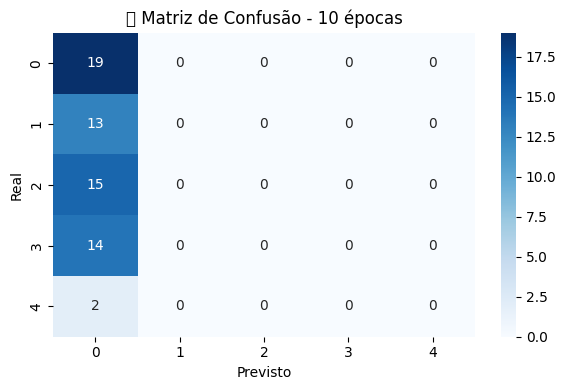


🔁 Treinando por 25 épocas...
📚 Época 1/25: Loss=201.2634 | Accuracy=0.28
📚 Época 2/25: Loss=194.6298 | Accuracy=0.31
📚 Época 3/25: Loss=191.2373 | Accuracy=0.31
📚 Época 4/25: Loss=193.2552 | Accuracy=0.31
📚 Época 5/25: Loss=192.7267 | Accuracy=0.31
📚 Época 6/25: Loss=192.9178 | Accuracy=0.31
📚 Época 7/25: Loss=193.1974 | Accuracy=0.31
📚 Época 8/25: Loss=192.9546 | Accuracy=0.31
📚 Época 9/25: Loss=192.7987 | Accuracy=0.31
📚 Época 10/25: Loss=192.3245 | Accuracy=0.31
📚 Época 11/25: Loss=192.6534 | Accuracy=0.31
📚 Época 12/25: Loss=192.6219 | Accuracy=0.31
📚 Época 13/25: Loss=193.0098 | Accuracy=0.31
📚 Época 14/25: Loss=193.0224 | Accuracy=0.31
📚 Época 15/25: Loss=192.6561 | Accuracy=0.31
📚 Época 16/25: Loss=192.7695 | Accuracy=0.31
📚 Época 17/25: Loss=192.6570 | Accuracy=0.31
📚 Época 18/25: Loss=192.2488 | Accuracy=0.31
📚 Época 19/25: Loss=192.3412 | Accuracy=0.31
📚 Época 20/25: Loss=192.8175 | Accuracy=0.30
📚 Época 21/25: Loss=191.8068 | Accuracy=0.31
📚 Época 22/25: Loss=192.6782 | Acc

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


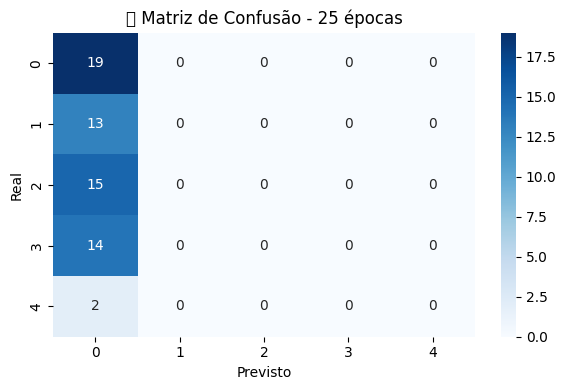


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=197.5465 | Accuracy=0.25
📚 Época 2/50: Loss=194.0106 | Accuracy=0.27
📚 Época 3/50: Loss=192.8545 | Accuracy=0.31
📚 Época 4/50: Loss=193.3141 | Accuracy=0.28
📚 Época 5/50: Loss=192.7884 | Accuracy=0.31
📚 Época 6/50: Loss=193.6532 | Accuracy=0.29
📚 Época 7/50: Loss=192.9160 | Accuracy=0.31
📚 Época 8/50: Loss=193.7672 | Accuracy=0.29
📚 Época 9/50: Loss=193.2221 | Accuracy=0.31
📚 Época 10/50: Loss=192.6950 | Accuracy=0.31
📚 Época 11/50: Loss=193.4573 | Accuracy=0.28
📚 Época 12/50: Loss=192.5660 | Accuracy=0.31
📚 Época 13/50: Loss=191.5518 | Accuracy=0.29
📚 Época 14/50: Loss=192.5959 | Accuracy=0.27
📚 Época 15/50: Loss=192.0345 | Accuracy=0.31
📚 Época 16/50: Loss=191.7408 | Accuracy=0.31
📚 Época 17/50: Loss=191.7514 | Accuracy=0.32
📚 Época 18/50: Loss=191.4312 | Accuracy=0.32
📚 Época 19/50: Loss=190.1087 | Accuracy=0.33
📚 Época 20/50: Loss=191.2785 | Accuracy=0.33
📚 Época 21/50: Loss=189.9016 | Accuracy=0.29
📚 Época 22/50: Loss=190.3842 | Acc

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


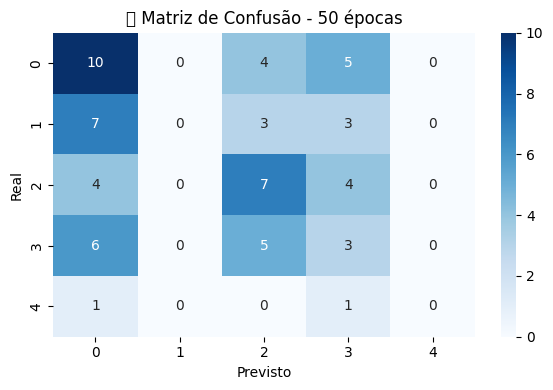


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=196.2471 | Accuracy=0.23
📚 Época 2/75: Loss=194.3597 | Accuracy=0.27
📚 Época 3/75: Loss=193.5538 | Accuracy=0.31
📚 Época 4/75: Loss=193.1670 | Accuracy=0.31
📚 Época 5/75: Loss=193.2519 | Accuracy=0.31
📚 Época 6/75: Loss=193.5387 | Accuracy=0.28
📚 Época 7/75: Loss=193.4262 | Accuracy=0.31
📚 Época 8/75: Loss=192.6215 | Accuracy=0.31
📚 Época 9/75: Loss=192.9864 | Accuracy=0.31
📚 Época 10/75: Loss=192.7518 | Accuracy=0.31
📚 Época 11/75: Loss=193.1753 | Accuracy=0.31
📚 Época 12/75: Loss=192.7811 | Accuracy=0.31
📚 Época 13/75: Loss=192.9605 | Accuracy=0.31
📚 Época 14/75: Loss=193.0494 | Accuracy=0.31
📚 Época 15/75: Loss=192.9940 | Accuracy=0.30
📚 Época 16/75: Loss=192.6594 | Accuracy=0.28
📚 Época 17/75: Loss=192.5425 | Accuracy=0.31
📚 Época 18/75: Loss=192.4527 | Accuracy=0.25
📚 Época 19/75: Loss=192.8760 | Accuracy=0.29
📚 Época 20/75: Loss=191.6947 | Accuracy=0.33
📚 Época 21/75: Loss=192.1850 | Accuracy=0.31
📚 Época 22/75: Loss=191.7930 | Acc

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


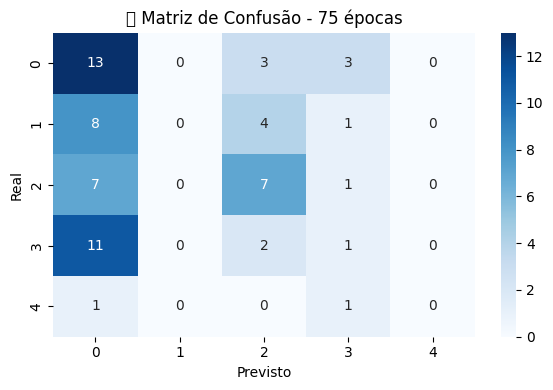


🔁 Treinando por 100 épocas...
📚 Época 1/100: Loss=200.4524 | Accuracy=0.25
📚 Época 2/100: Loss=195.7827 | Accuracy=0.26
📚 Época 3/100: Loss=193.6325 | Accuracy=0.27
📚 Época 4/100: Loss=193.6610 | Accuracy=0.31
📚 Época 5/100: Loss=193.3432 | Accuracy=0.28
📚 Época 6/100: Loss=193.0122 | Accuracy=0.31
📚 Época 7/100: Loss=192.8402 | Accuracy=0.30
📚 Época 8/100: Loss=192.9390 | Accuracy=0.31
📚 Época 9/100: Loss=192.8305 | Accuracy=0.27
📚 Época 10/100: Loss=193.3572 | Accuracy=0.31
📚 Época 11/100: Loss=191.4623 | Accuracy=0.31
📚 Época 12/100: Loss=192.7585 | Accuracy=0.31
📚 Época 13/100: Loss=193.1302 | Accuracy=0.31
📚 Época 14/100: Loss=191.7109 | Accuracy=0.31
📚 Época 15/100: Loss=192.8028 | Accuracy=0.31
📚 Época 16/100: Loss=192.9840 | Accuracy=0.30
📚 Época 17/100: Loss=192.7621 | Accuracy=0.31
📚 Época 18/100: Loss=193.2090 | Accuracy=0.26
📚 Época 19/100: Loss=192.8975 | Accuracy=0.31
📚 Época 20/100: Loss=192.9311 | Accuracy=0.30
📚 Época 21/100: Loss=192.4755 | Accuracy=0.31
📚 Época 22/1

/tmp/ipykernel_24827/1147739167.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


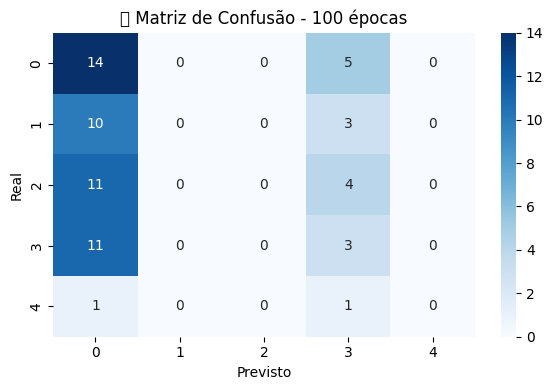

In [65]:

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [10,25,50,75,100]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_SEBlock().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=198.7511 | Accuracy=0.19
📚 Época 2/10: Loss=194.5875 | Accuracy=0.29
📚 Época 3/10: Loss=192.5546 | Accuracy=0.26
📚 Época 4/10: Loss=192.9938 | Accuracy=0.29
📚 Época 5/10: Loss=192.5792 | Accuracy=0.26
📚 Época 6/10: Loss=192.9261 | Accuracy=0.30
📚 Época 7/10: Loss=190.1987 | Accuracy=0.31
📚 Época 8/10: Loss=189.7667 | Accuracy=0.31
📚 Época 9/10: Loss=192.2902 | Accuracy=0.31
📚 Época 10/10: Loss=191.7551 | Accuracy=0.29

📊 Relatório:
              precision    recall  f1-score   support

           0       0.38      0.68      0.49        19
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        15
           3       0.19      0.36      0.25        14
           4       0.00      0.00      0.00         2

    accuracy                           0.29        63
   macro avg       0.11      0.21      0.15        63
weighted avg       0.16      0.29      0.20        63

🔢 F1 Macro: 0.148113207547

/tmp/ipykernel_24827/59723424.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


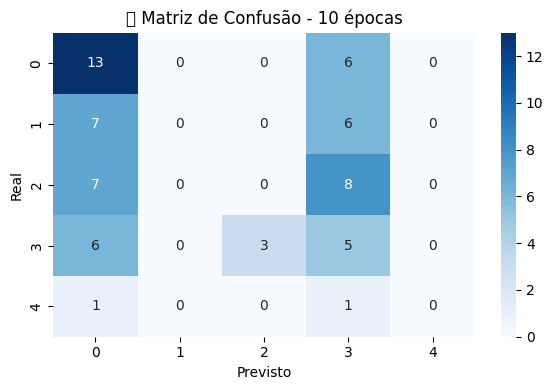


🔁 Treinando por 25 épocas...
📚 Época 1/25: Loss=198.6456 | Accuracy=0.23
📚 Época 2/25: Loss=193.4925 | Accuracy=0.29
📚 Época 3/25: Loss=194.7930 | Accuracy=0.24
📚 Época 4/25: Loss=194.1816 | Accuracy=0.24
📚 Época 5/25: Loss=191.4932 | Accuracy=0.27
📚 Época 6/25: Loss=193.3625 | Accuracy=0.28
📚 Época 7/25: Loss=194.7008 | Accuracy=0.31
📚 Época 8/25: Loss=191.3281 | Accuracy=0.32
📚 Época 9/25: Loss=190.4332 | Accuracy=0.28
📚 Época 10/25: Loss=192.0714 | Accuracy=0.27
📚 Época 11/25: Loss=191.3690 | Accuracy=0.31
📚 Época 12/25: Loss=190.7777 | Accuracy=0.31
📚 Época 13/25: Loss=191.8063 | Accuracy=0.31
📚 Época 14/25: Loss=190.5939 | Accuracy=0.31
📚 Época 15/25: Loss=189.8008 | Accuracy=0.29
📚 Época 16/25: Loss=191.3342 | Accuracy=0.29
📚 Época 17/25: Loss=189.9426 | Accuracy=0.31
📚 Época 18/25: Loss=191.1347 | Accuracy=0.30
📚 Época 19/25: Loss=190.1261 | Accuracy=0.31
📚 Época 20/25: Loss=189.2924 | Accuracy=0.31
📚 Época 21/25: Loss=190.1038 | Accuracy=0.28
📚 Época 22/25: Loss=188.5460 | Acc

/tmp/ipykernel_24827/59723424.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


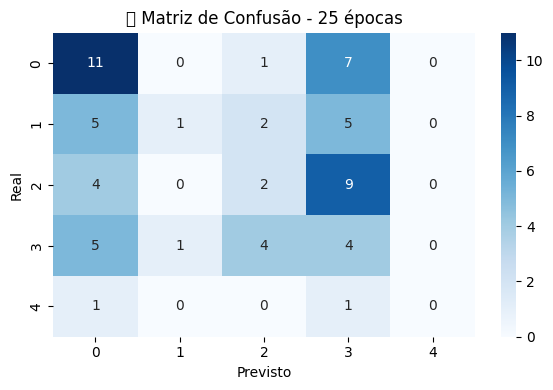


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=197.7331 | Accuracy=0.26
📚 Época 2/50: Loss=194.4511 | Accuracy=0.23
📚 Época 3/50: Loss=193.7543 | Accuracy=0.25
📚 Época 4/50: Loss=192.3389 | Accuracy=0.29
📚 Época 5/50: Loss=192.6993 | Accuracy=0.32
📚 Época 6/50: Loss=192.4100 | Accuracy=0.24
📚 Época 7/50: Loss=192.8720 | Accuracy=0.24
📚 Época 8/50: Loss=192.6065 | Accuracy=0.26
📚 Época 9/50: Loss=190.0417 | Accuracy=0.27
📚 Época 10/50: Loss=192.4416 | Accuracy=0.29
📚 Época 11/50: Loss=191.3151 | Accuracy=0.27
📚 Época 12/50: Loss=191.0802 | Accuracy=0.26
📚 Época 13/50: Loss=190.8972 | Accuracy=0.30
📚 Época 14/50: Loss=189.8463 | Accuracy=0.33
📚 Época 15/50: Loss=190.7162 | Accuracy=0.28
📚 Época 16/50: Loss=191.3490 | Accuracy=0.27
📚 Época 17/50: Loss=189.4694 | Accuracy=0.31
📚 Época 18/50: Loss=192.7631 | Accuracy=0.25
📚 Época 19/50: Loss=189.1388 | Accuracy=0.33
📚 Época 20/50: Loss=190.5863 | Accuracy=0.33
📚 Época 21/50: Loss=190.9264 | Accuracy=0.26
📚 Época 22/50: Loss=189.3727 | Acc

/tmp/ipykernel_24827/59723424.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


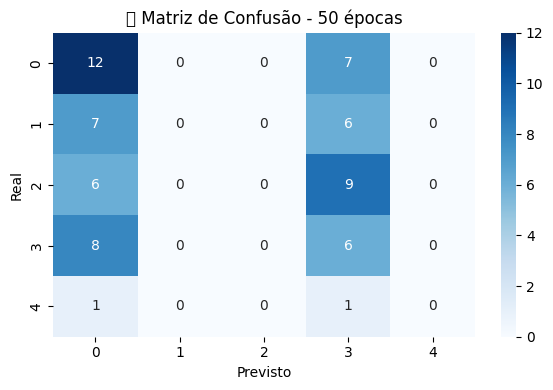


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=198.3537 | Accuracy=0.22
📚 Época 2/75: Loss=193.0593 | Accuracy=0.29
📚 Época 3/75: Loss=193.1880 | Accuracy=0.27
📚 Época 4/75: Loss=193.5375 | Accuracy=0.25
📚 Época 5/75: Loss=192.6323 | Accuracy=0.30
📚 Época 6/75: Loss=193.2759 | Accuracy=0.24
📚 Época 7/75: Loss=191.3977 | Accuracy=0.29
📚 Época 8/75: Loss=191.6478 | Accuracy=0.27
📚 Época 9/75: Loss=192.7044 | Accuracy=0.22
📚 Época 10/75: Loss=191.0483 | Accuracy=0.29
📚 Época 11/75: Loss=191.8575 | Accuracy=0.32
📚 Época 12/75: Loss=192.2067 | Accuracy=0.30
📚 Época 13/75: Loss=192.2831 | Accuracy=0.29
📚 Época 14/75: Loss=191.1531 | Accuracy=0.30
📚 Época 15/75: Loss=190.7902 | Accuracy=0.30
📚 Época 16/75: Loss=190.4147 | Accuracy=0.31
📚 Época 17/75: Loss=192.3613 | Accuracy=0.27
📚 Época 18/75: Loss=192.0590 | Accuracy=0.31
📚 Época 19/75: Loss=190.3919 | Accuracy=0.27
📚 Época 20/75: Loss=189.5814 | Accuracy=0.34
📚 Época 21/75: Loss=189.9384 | Accuracy=0.32
📚 Época 22/75: Loss=191.4478 | Acc

/tmp/ipykernel_24827/59723424.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


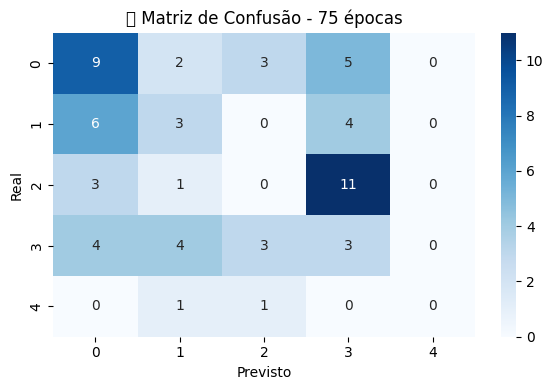


🔁 Treinando por 100 épocas...
📚 Época 1/100: Loss=198.0458 | Accuracy=0.25
📚 Época 2/100: Loss=194.0609 | Accuracy=0.27
📚 Época 3/100: Loss=194.4429 | Accuracy=0.27
📚 Época 4/100: Loss=195.1154 | Accuracy=0.27
📚 Época 5/100: Loss=193.0668 | Accuracy=0.25
📚 Época 6/100: Loss=192.3609 | Accuracy=0.31
📚 Época 7/100: Loss=191.6392 | Accuracy=0.26
📚 Época 8/100: Loss=191.2005 | Accuracy=0.32
📚 Época 9/100: Loss=192.8378 | Accuracy=0.35
📚 Época 10/100: Loss=190.8237 | Accuracy=0.32
📚 Época 11/100: Loss=190.0837 | Accuracy=0.29
📚 Época 12/100: Loss=189.1902 | Accuracy=0.32
📚 Época 13/100: Loss=191.2634 | Accuracy=0.30
📚 Época 14/100: Loss=189.7456 | Accuracy=0.32
📚 Época 15/100: Loss=190.3854 | Accuracy=0.30
📚 Época 16/100: Loss=190.8528 | Accuracy=0.33
📚 Época 17/100: Loss=190.7725 | Accuracy=0.31
📚 Época 18/100: Loss=188.3159 | Accuracy=0.33
📚 Época 19/100: Loss=189.5459 | Accuracy=0.34
📚 Época 20/100: Loss=185.9460 | Accuracy=0.32
📚 Época 21/100: Loss=187.5189 | Accuracy=0.33
📚 Época 22/1

/tmp/ipykernel_24827/59723424.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


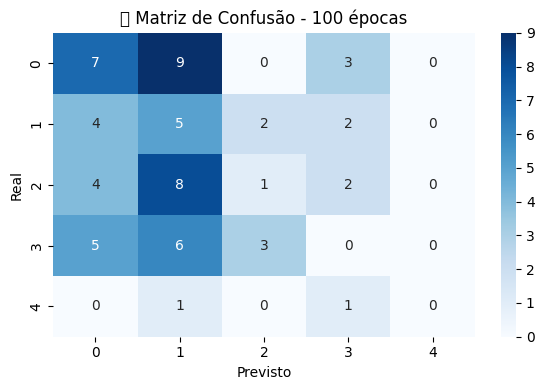

In [66]:

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [10,25,50,75,100]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_Profundo().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=197.4906 | Accuracy=0.27
📚 Época 2/10: Loss=193.8205 | Accuracy=0.29
📚 Época 3/10: Loss=193.3235 | Accuracy=0.31
📚 Época 4/10: Loss=192.6621 | Accuracy=0.27
📚 Época 5/10: Loss=192.7569 | Accuracy=0.31
📚 Época 6/10: Loss=193.1466 | Accuracy=0.30
📚 Época 7/10: Loss=192.8532 | Accuracy=0.29
📚 Época 8/10: Loss=192.5067 | Accuracy=0.33
📚 Época 9/10: Loss=192.6927 | Accuracy=0.27
📚 Época 10/10: Loss=191.7569 | Accuracy=0.30

📊 Relatório:
              precision    recall  f1-score   support

           0       0.28      0.68      0.39        19
           1       0.00      0.00      0.00        13
           2       0.25      0.27      0.26        15
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         2

    accuracy                           0.27        63
   macro avg       0.11      0.19      0.13        63
weighted avg       0.14      0.27      0.18        63

🔢 F1 Macro: 0.130400782013

/tmp/ipykernel_24827/1660452371.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


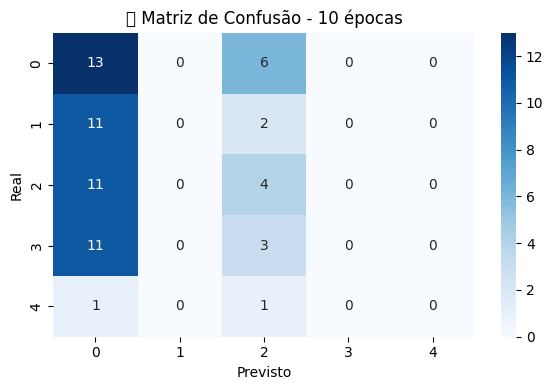


🔁 Treinando por 25 épocas...
📚 Época 1/25: Loss=196.6922 | Accuracy=0.31
📚 Época 2/25: Loss=193.8412 | Accuracy=0.27
📚 Época 3/25: Loss=193.5677 | Accuracy=0.31
📚 Época 4/25: Loss=193.6064 | Accuracy=0.31
📚 Época 5/25: Loss=193.1282 | Accuracy=0.31
📚 Época 6/25: Loss=191.8481 | Accuracy=0.31
📚 Época 7/25: Loss=192.8116 | Accuracy=0.31
📚 Época 8/25: Loss=191.9075 | Accuracy=0.31
📚 Época 9/25: Loss=193.0194 | Accuracy=0.31
📚 Época 10/25: Loss=191.7550 | Accuracy=0.31
📚 Época 11/25: Loss=192.2139 | Accuracy=0.29
📚 Época 12/25: Loss=193.3493 | Accuracy=0.31
📚 Época 13/25: Loss=192.7768 | Accuracy=0.29
📚 Época 14/25: Loss=192.7751 | Accuracy=0.31
📚 Época 15/25: Loss=193.1369 | Accuracy=0.31
📚 Época 16/25: Loss=192.8076 | Accuracy=0.28
📚 Época 17/25: Loss=192.8573 | Accuracy=0.28
📚 Época 18/25: Loss=191.6428 | Accuracy=0.29
📚 Época 19/25: Loss=192.0701 | Accuracy=0.30
📚 Época 20/25: Loss=191.0507 | Accuracy=0.33
📚 Época 21/25: Loss=192.6763 | Accuracy=0.30
📚 Época 22/25: Loss=192.1829 | Acc

/tmp/ipykernel_24827/1660452371.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


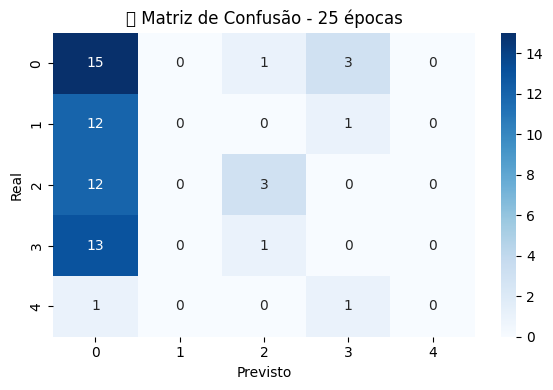


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=195.8613 | Accuracy=0.25
📚 Época 2/50: Loss=193.2642 | Accuracy=0.31
📚 Época 3/50: Loss=193.1833 | Accuracy=0.30
📚 Época 4/50: Loss=193.6628 | Accuracy=0.30
📚 Época 5/50: Loss=193.0926 | Accuracy=0.30
📚 Época 6/50: Loss=192.2618 | Accuracy=0.31
📚 Época 7/50: Loss=194.1417 | Accuracy=0.29
📚 Época 8/50: Loss=191.9656 | Accuracy=0.31
📚 Época 9/50: Loss=192.8387 | Accuracy=0.28
📚 Época 10/50: Loss=192.9850 | Accuracy=0.30
📚 Época 11/50: Loss=192.9261 | Accuracy=0.29
📚 Época 12/50: Loss=192.6323 | Accuracy=0.26
📚 Época 13/50: Loss=192.3241 | Accuracy=0.31
📚 Época 14/50: Loss=192.3732 | Accuracy=0.29
📚 Época 15/50: Loss=191.6654 | Accuracy=0.32
📚 Época 16/50: Loss=191.9435 | Accuracy=0.33
📚 Época 17/50: Loss=191.7311 | Accuracy=0.29
📚 Época 18/50: Loss=191.6525 | Accuracy=0.31
📚 Época 19/50: Loss=191.4863 | Accuracy=0.30
📚 Época 20/50: Loss=190.8991 | Accuracy=0.29
📚 Época 21/50: Loss=190.7676 | Accuracy=0.33
📚 Época 22/50: Loss=190.3881 | Acc

/tmp/ipykernel_24827/1660452371.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


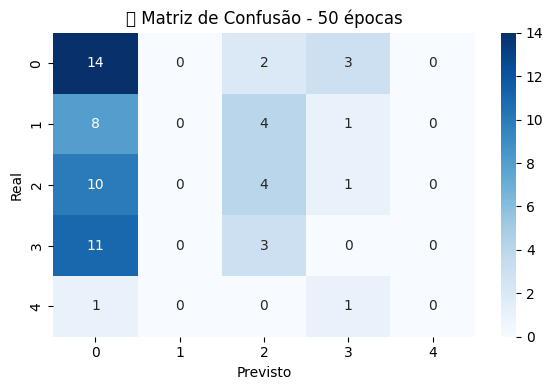


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=199.8401 | Accuracy=0.24
📚 Época 2/75: Loss=193.3655 | Accuracy=0.26
📚 Época 3/75: Loss=194.8898 | Accuracy=0.27
📚 Época 4/75: Loss=193.6283 | Accuracy=0.27
📚 Época 5/75: Loss=193.7771 | Accuracy=0.29
📚 Época 6/75: Loss=193.0617 | Accuracy=0.27
📚 Época 7/75: Loss=193.3850 | Accuracy=0.27
📚 Época 8/75: Loss=193.1759 | Accuracy=0.31
📚 Época 9/75: Loss=191.8932 | Accuracy=0.28
📚 Época 10/75: Loss=193.0395 | Accuracy=0.27
📚 Época 11/75: Loss=192.9321 | Accuracy=0.31
📚 Época 12/75: Loss=193.1268 | Accuracy=0.31
📚 Época 13/75: Loss=193.6333 | Accuracy=0.28
📚 Época 14/75: Loss=193.7104 | Accuracy=0.31
📚 Época 15/75: Loss=192.8082 | Accuracy=0.31
📚 Época 16/75: Loss=192.9753 | Accuracy=0.31
📚 Época 17/75: Loss=191.9347 | Accuracy=0.25
📚 Época 18/75: Loss=192.7539 | Accuracy=0.31
📚 Época 19/75: Loss=192.7562 | Accuracy=0.30
📚 Época 20/75: Loss=193.1982 | Accuracy=0.31
📚 Época 21/75: Loss=192.6188 | Accuracy=0.31
📚 Época 22/75: Loss=193.1240 | Acc

/tmp/ipykernel_24827/1660452371.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


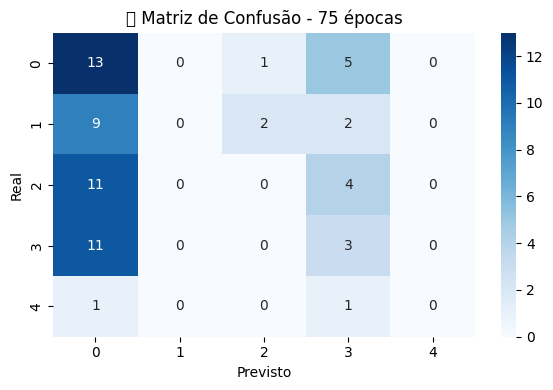


🔁 Treinando por 100 épocas...
📚 Época 1/100: Loss=197.7794 | Accuracy=0.27
📚 Época 2/100: Loss=192.2104 | Accuracy=0.25
📚 Época 3/100: Loss=194.2694 | Accuracy=0.27
📚 Época 4/100: Loss=192.9549 | Accuracy=0.30
📚 Época 5/100: Loss=192.9167 | Accuracy=0.31
📚 Época 6/100: Loss=192.7315 | Accuracy=0.29
📚 Época 7/100: Loss=192.3692 | Accuracy=0.33
📚 Época 8/100: Loss=192.3372 | Accuracy=0.29
📚 Época 9/100: Loss=192.5136 | Accuracy=0.33
📚 Época 10/100: Loss=192.2801 | Accuracy=0.30
📚 Época 11/100: Loss=192.6180 | Accuracy=0.33
📚 Época 12/100: Loss=191.9044 | Accuracy=0.30
📚 Época 13/100: Loss=192.3796 | Accuracy=0.32
📚 Época 14/100: Loss=192.2333 | Accuracy=0.31
📚 Época 15/100: Loss=192.0339 | Accuracy=0.29
📚 Época 16/100: Loss=191.3347 | Accuracy=0.33
📚 Época 17/100: Loss=190.7535 | Accuracy=0.31
📚 Época 18/100: Loss=191.3562 | Accuracy=0.35
📚 Época 19/100: Loss=191.1499 | Accuracy=0.30
📚 Época 20/100: Loss=190.8570 | Accuracy=0.32
📚 Época 21/100: Loss=190.7873 | Accuracy=0.33
📚 Época 22/1

/tmp/ipykernel_24827/1660452371.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


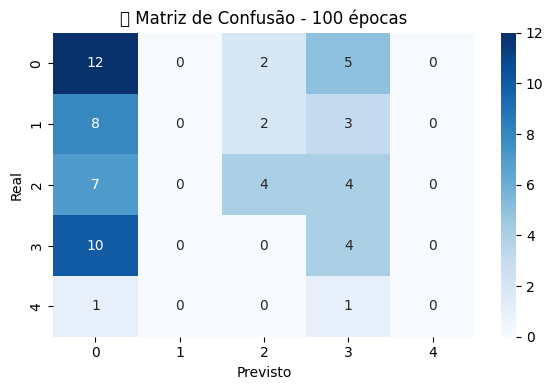

In [67]:

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [10,25,50,75,100]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_Dropout().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


🔁 Treinando por 10 épocas...
📚 Época 1/10: Loss=196.6734 | Accuracy=0.28
📚 Época 2/10: Loss=194.5337 | Accuracy=0.27
📚 Época 3/10: Loss=193.6563 | Accuracy=0.29
📚 Época 4/10: Loss=193.4703 | Accuracy=0.31
📚 Época 5/10: Loss=193.1153 | Accuracy=0.31
📚 Época 6/10: Loss=193.7676 | Accuracy=0.27
📚 Época 7/10: Loss=194.3238 | Accuracy=0.28
📚 Época 8/10: Loss=193.0131 | Accuracy=0.31
📚 Época 9/10: Loss=193.4639 | Accuracy=0.31
📚 Época 10/10: Loss=193.3758 | Accuracy=0.28

📊 Relatório:
              precision    recall  f1-score   support

           0       0.29      0.89      0.44        19
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         2

    accuracy                           0.27        63
   macro avg       0.06      0.18      0.09        63
weighted avg       0.09      0.27      0.13        63

🔢 F1 Macro: 0.087179487179

/tmp/ipykernel_24827/1734314864.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


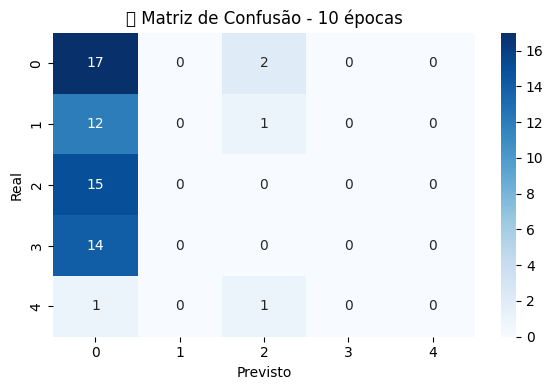


🔁 Treinando por 25 épocas...
📚 Época 1/25: Loss=197.3617 | Accuracy=0.24
📚 Época 2/25: Loss=195.6509 | Accuracy=0.31
📚 Época 3/25: Loss=194.9532 | Accuracy=0.24
📚 Época 4/25: Loss=193.6385 | Accuracy=0.25
📚 Época 5/25: Loss=193.6583 | Accuracy=0.31
📚 Época 6/25: Loss=193.4228 | Accuracy=0.28
📚 Época 7/25: Loss=193.6733 | Accuracy=0.30
📚 Época 8/25: Loss=191.2765 | Accuracy=0.31
📚 Época 9/25: Loss=192.8432 | Accuracy=0.27
📚 Época 10/25: Loss=192.8727 | Accuracy=0.27
📚 Época 11/25: Loss=192.5042 | Accuracy=0.31
📚 Época 12/25: Loss=191.6117 | Accuracy=0.31
📚 Época 13/25: Loss=191.9808 | Accuracy=0.30
📚 Época 14/25: Loss=192.2007 | Accuracy=0.31
📚 Época 15/25: Loss=189.3796 | Accuracy=0.32
📚 Época 16/25: Loss=189.8522 | Accuracy=0.31
📚 Época 17/25: Loss=190.0028 | Accuracy=0.35
📚 Época 18/25: Loss=189.2059 | Accuracy=0.31
📚 Época 19/25: Loss=189.3592 | Accuracy=0.31
📚 Época 20/25: Loss=189.7194 | Accuracy=0.34
📚 Época 21/25: Loss=188.9570 | Accuracy=0.33
📚 Época 22/25: Loss=188.5480 | Acc

/tmp/ipykernel_24827/1734314864.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


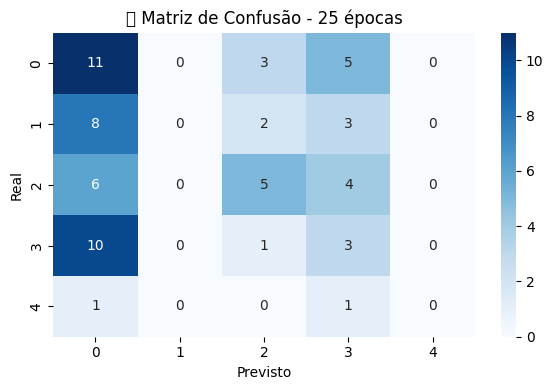


🔁 Treinando por 50 épocas...
📚 Época 1/50: Loss=196.6566 | Accuracy=0.23
📚 Época 2/50: Loss=194.5461 | Accuracy=0.29
📚 Época 3/50: Loss=193.9835 | Accuracy=0.25
📚 Época 4/50: Loss=193.4550 | Accuracy=0.29
📚 Época 5/50: Loss=192.9723 | Accuracy=0.27
📚 Época 6/50: Loss=193.6031 | Accuracy=0.25
📚 Época 7/50: Loss=192.9127 | Accuracy=0.25
📚 Época 8/50: Loss=192.1424 | Accuracy=0.31
📚 Época 9/50: Loss=192.0286 | Accuracy=0.33
📚 Época 10/50: Loss=191.7603 | Accuracy=0.29
📚 Época 11/50: Loss=191.0478 | Accuracy=0.31
📚 Época 12/50: Loss=190.4502 | Accuracy=0.32
📚 Época 13/50: Loss=189.8552 | Accuracy=0.31
📚 Época 14/50: Loss=189.2827 | Accuracy=0.30
📚 Época 15/50: Loss=188.9489 | Accuracy=0.33
📚 Época 16/50: Loss=188.9244 | Accuracy=0.29
📚 Época 17/50: Loss=190.1044 | Accuracy=0.31
📚 Época 18/50: Loss=190.7110 | Accuracy=0.30
📚 Época 19/50: Loss=189.1610 | Accuracy=0.31
📚 Época 20/50: Loss=188.1272 | Accuracy=0.32
📚 Época 21/50: Loss=188.7175 | Accuracy=0.32
📚 Época 22/50: Loss=188.9850 | Acc

/tmp/ipykernel_24827/1734314864.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


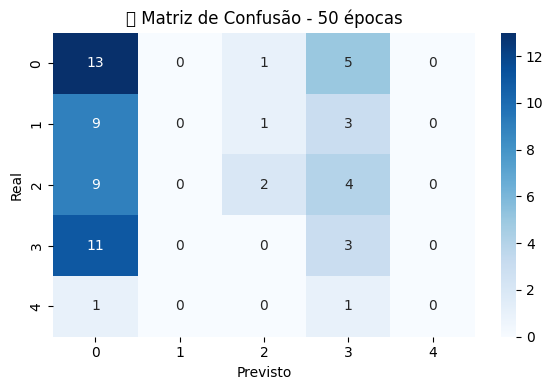


🔁 Treinando por 75 épocas...
📚 Época 1/75: Loss=198.3618 | Accuracy=0.24
📚 Época 2/75: Loss=194.7733 | Accuracy=0.21
📚 Época 3/75: Loss=193.6534 | Accuracy=0.30
📚 Época 4/75: Loss=193.7033 | Accuracy=0.31
📚 Época 5/75: Loss=193.9789 | Accuracy=0.25
📚 Época 6/75: Loss=193.6258 | Accuracy=0.28
📚 Época 7/75: Loss=193.3005 | Accuracy=0.31
📚 Época 8/75: Loss=192.8124 | Accuracy=0.31
📚 Época 9/75: Loss=194.0038 | Accuracy=0.31
📚 Época 10/75: Loss=193.7643 | Accuracy=0.29
📚 Época 11/75: Loss=192.5753 | Accuracy=0.32
📚 Época 12/75: Loss=192.4905 | Accuracy=0.30
📚 Época 13/75: Loss=191.0684 | Accuracy=0.30
📚 Época 14/75: Loss=191.7673 | Accuracy=0.33
📚 Época 15/75: Loss=190.6036 | Accuracy=0.33
📚 Época 16/75: Loss=191.0121 | Accuracy=0.33
📚 Época 17/75: Loss=191.2069 | Accuracy=0.31
📚 Época 18/75: Loss=190.8511 | Accuracy=0.31
📚 Época 19/75: Loss=189.9923 | Accuracy=0.29
📚 Época 20/75: Loss=188.7493 | Accuracy=0.34
📚 Época 21/75: Loss=189.9812 | Accuracy=0.31
📚 Época 22/75: Loss=189.2995 | Acc

/tmp/ipykernel_24827/1734314864.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


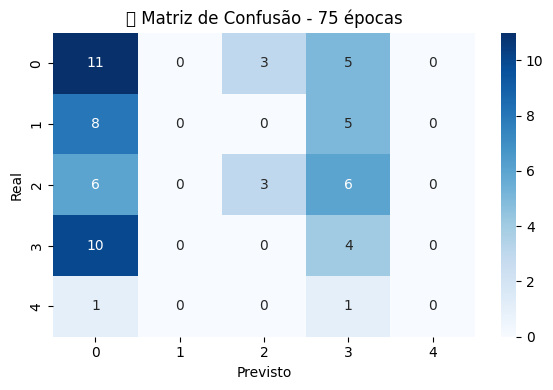


🔁 Treinando por 100 épocas...
📚 Época 1/100: Loss=198.5338 | Accuracy=0.22
📚 Época 2/100: Loss=194.7370 | Accuracy=0.30
📚 Época 3/100: Loss=193.4317 | Accuracy=0.25
📚 Época 4/100: Loss=193.1092 | Accuracy=0.28
📚 Época 5/100: Loss=193.3652 | Accuracy=0.27
📚 Época 6/100: Loss=194.7945 | Accuracy=0.28
📚 Época 7/100: Loss=194.0332 | Accuracy=0.27
📚 Época 8/100: Loss=193.0842 | Accuracy=0.28
📚 Época 9/100: Loss=192.6534 | Accuracy=0.29
📚 Época 10/100: Loss=192.6460 | Accuracy=0.27
📚 Época 11/100: Loss=190.7572 | Accuracy=0.32
📚 Época 12/100: Loss=189.8062 | Accuracy=0.30
📚 Época 13/100: Loss=191.4106 | Accuracy=0.28
📚 Época 14/100: Loss=190.8538 | Accuracy=0.31
📚 Época 15/100: Loss=190.0042 | Accuracy=0.28
📚 Época 16/100: Loss=190.1558 | Accuracy=0.36
📚 Época 17/100: Loss=189.2045 | Accuracy=0.31
📚 Época 18/100: Loss=189.4634 | Accuracy=0.29
📚 Época 19/100: Loss=189.8710 | Accuracy=0.32
📚 Época 20/100: Loss=188.5640 | Accuracy=0.29
📚 Época 21/100: Loss=189.2104 | Accuracy=0.33
📚 Época 22/1

/tmp/ipykernel_24827/1734314864.py:53: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


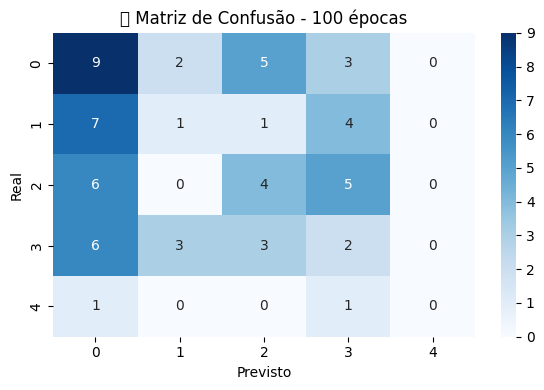

In [68]:

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for EPOCHS in [10,25,50,75,100]:
    print(f"\n🔁 Treinando por {EPOCHS} épocas...")
    model =  CNN2D_ResBlock().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"📚 Época {epoch+1}/{EPOCHS}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(2)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    print("\n📊 Relatório:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("🔢 F1 Macro:", f1_score(y_true, y_pred, average="macro"))

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"📌 Matriz de Confusão - {EPOCHS} épocas")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()